# 🧠 Predictive Modeling 🧠

---

<div class="alert alert-block alert-info">
Table of Contents: <br>
    
<ul>
    <li>1. <a href="#1.-Setup">Setup</a></li>
    <li>📂 2. <a href="#%F0%9F%93%82-2.-Load-&-Preview-Data">Load & Preview Data</a></li>
    <li>🔧 3. <a href="#%F0%9F%94%A7-3.-Preprocessing">Preprocessing</a>
        <ul>
            <li>3.1. <a href="#3.1.-Splitting-the-Data">Splitting the Data</a></li>
            <li>3.2. <a href="#3.2.-Pipeline">Pipeline</a></li>
        </ul>
    </li>
    <li>😶‍🌫️ 4. <a href="#%F0%9F%98%B6%E2%80%8D%F0%9F%8C%AB%EF%B8%8F-4.-Baseline">Baseline</a></li>
    <li>🤔 5. <a href="#%F0%9F%A4%94-5.-Coarse-Model-Selection">Coarse Model Selection</a>
        <ul>
            <li>5.1. <a href="#5.1.-Decision-Tree">Decision Tree</a></li>
            <li>5.2. <a href="#5.2.-Random-Forest">Random Forest</a></li>
            <li>5.3. <a href="#5.3.-Extra-Trees">Extra Trees</a></li>
            <li>5.4. <a href="#5.4.-Support-Vector-Machine-(SVM)">Support Vector Machine (SVM)</a></li>
            <li>5.5. <a href="#5.5.-XGBoost">XGBoost</a></li>
            <li>5.6. <a href="#5.6.-CatBoost">CatBoost</a></li>
            <li>5.7. <a href="#5.7.-LightGBM">LightGBM</a></li>
            <li>5.8. <a href="#5.8.-Shallow-Neural-Network">Shallow Neural Network</a></li>
        </ul>
    </li>
    <li>🧪 6. <a href="#%F0%9F%A7%AA-6.-CV-Experiments">CV Experiments</a>
        <ul>
            <li>6.1. <a href="#6.1.-Feature-Engineering-&-Dimensionality-Reduction">Feature Engineering & Dimensionality Reduction</a></li>
            <li>6.2. <a href="#6.2.-Hyperparameter-Sweeping">Hyperparameter Sweeping</a></li>
        </ul>
    </li>
    <li>🔬 7. <a href="#%F0%9F%94%AC-7.-Ensembling">Ensembling</a></li>
    <li>🚧 8. <a href="#%F0%9F%9A%A7-8.-Deployment">Deployment</a></li>
    <li>9. <a href="#9.-Conclusion">Conclusion</a></li>
</ul>
</div>

<h3><center>🛑 <b>Disclaimer</b> 🛑</center></h3>

From my understanding, predictive modeling is more than just taking whatever data is available and passing it through a random model. I'm still learning lots about this! Here's what I know:

* it all goes back to the data and the quality of data; models are limited by their data
* there is no free lunch; no one model works perfectly
* generally larger datasets improve performance (at least in DL)
* rather than optimize for performance, business context and use case and other real-world trade-offs have to be considered
    * is this model interpretable?
    * how fast is it?
    * how well does it integrate into the existing infrastructure?
    * does this model achieve comparable performance?
    * is it ethical? where was the data sourced? is it ok to use this data?
    * are there unintended effects?
* are there ways to solve/tackle this problem *without* machine learning?
* any hardware or financial or other limitations?

The list goes on, but generally these considerations fall into data, model, context, or deployment problems (from what I understand).

For this particular dataset, we face the following problems:
* insufficient sample size
* not enough predictive features
* a few imbalanced classes (full-time vs internships, etc)
* data based largely in CA
* some roles aren't data scientist roles
* revenue has large amount of unknown
* (my guess) the current features are not predictive enough for salary estimate
* categorical columns have very rare unique values

**Note**: Though I don't believe this dataset to be suitable for modeling, I will still treat this like a model-able task.

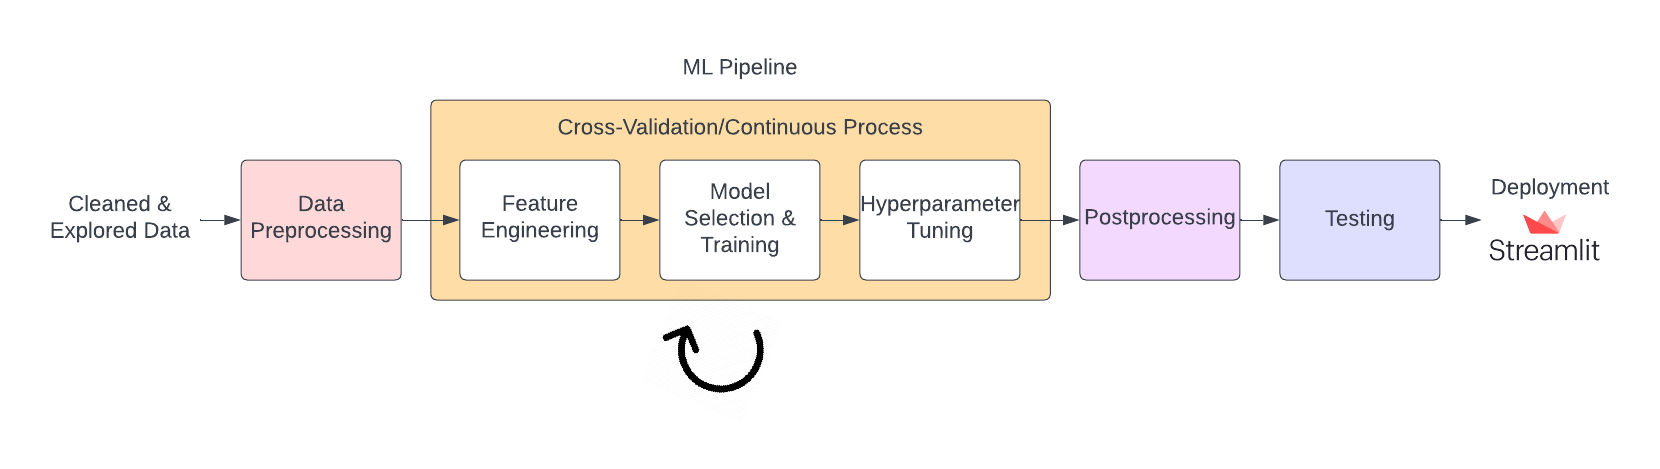 <br>
_Figure 1. My ML pipeline for this project._

My machine learning pipeline detailed in Figure 1 will be the skeleton of this notebook. I showed the cross-validation framework for fast, iterative experimenting here because it's often the case that development is a cyclic process (especially in Kaggle competitions where fast and effective experiments are key to success!). For this particular project, I will go back and forth testing models and running experiments.

## 1. Setup

In [287]:
# General imports.
import os
import time
import joblib

# Specific imports.
from pprint import pprint
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import category_encoders as ce
from category_encoders import HashingEncoder

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.base import clone

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor

import evalml
from evalml.automl import AutoMLSearch
from autofeat import FeatureSelector, AutoFeatRegressor
from lofo import Dataset, LOFOImportance, plot_importance

import tensorflow as tf
from tensorflow import keras

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import optuna
import ray
from ray.tune.sklearn import TuneSearchCV

## 📂 2. Load & Preview Data

Let's load in our data and check if there are any immediate problems.

In [2]:
df = pd.read_csv("./input/joblisting_cleaned.csv")

In [3]:
df

,company,rating,headquarters,salary estimate,job type,size,type,sector,revenue
0,Indeed,4.3,"San Francisco, CA",209.0,Full-time,10000+ employees,company - private,information technology,$2 to $5 billion (usd)
1,Indeed,4.3,"San Francisco, CA",143.0,Full-time,10000+ employees,company - private,information technology,$2 to $5 billion (usd)
2,Abl Schools,4.1,"San Francisco, CA",140.0,Full-time,1 to 50 employees,company - private,business services,unknown / non-applicable
3,Amazon,3.8,"Palo Alto, CA",115.0,Full-time,10000+ employees,company - public,information technology,$10+ billion (usd)
4,Thermo Fisher - America,3.8,"San Francisco, CA",134.5,Full-time,10000+ employees,company - public,biotech & pharmaceuticals,$10+ billion (usd)
...,...,...,...,...,...,...,...,...,...
1696,Kaiser Permanente,4.0,"Oakland, CA",101.5,Full-time,10000+ employees,nonprofit organization,health care,$10+ billion (usd)
1697,California State University,4.3,"San Francisco, CA",81.0,Full-time,201 to 500 employees,college / university,education,$1 to $5 million (usd)
1698,Adobe,4.4,"San Francisco, CA",151.5,Full-time,10000+ employees,company - public,information technology,$5 to $10 billion (usd)
1699,First Republic Bank,4.3,"San Francisco, CA",112.5,Full-time,1001 to 5000 employees,company - public,finance,$10+ billion (usd)


In [4]:
df.shape

(1701, 9)

In [5]:
df.columns

Index(['company', 'rating', 'headquarters', 'salary estimate', 'job type',
       'size', 'type', 'sector', 'revenue'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          1701 non-null   object 
 1   rating           1701 non-null   float64
 2   headquarters     1701 non-null   object 
 3   salary estimate  1701 non-null   float64
 4   job type         1701 non-null   object 
 5   size             1701 non-null   object 
 6   type             1701 non-null   object 
 7   sector           1701 non-null   object 
 8   revenue          1701 non-null   object 
dtypes: float64(2), object(7)
memory usage: 119.7+ KB


In [7]:
df.rating.unique()

array([4.3, 4.1, 3.8, 3.4, 4.8, 4.6, 4. , 3.2, 4.5, 4.2, 4.7, 4.4, 4.9,
       5. , 3.7, 3.5, 3.6, 3.9, 2.6, 2.8, 3.3, 3.1, 3. , 2.9, 2.5, 2.3,
       2.7, 2.1])

In [8]:
df.headquarters.unique()

array(['San Francisco, CA', 'Palo Alto, CA', 'Menlo Park, CA',
       'Sunnyvale, CA', 'Mountain View, CA', 'Newark, CA', 'Oakland, CA',
       'Redwood City, CA', 'Cupertino, CA', 'Burlingame, CA',
       'Emeryville, CA', 'South San Francisco, CA', 'San Jose, CA',
       'San Mateo, CA', 'Santa Clara, CA', 'Los Gatos, CA',
       'Sausalito, CA', 'Brisbane, CA', 'Elk Grove, CA',
       'Foster City, CA', 'Pittsburg, CA', 'Sacramento, CA',
       'Fremont, CA', 'Concord, CA', 'East Palo Alto, CA',
       'Patterson, CA', 'San Bruno, CA', 'Pleasanton, CA', 'Hercules, CA',
       'Berkeley, CA', 'Morgan Hill, CA', 'San Ramon, CA', 'Milpitas, CA',
       'San Carlos, CA', 'Alameda, CA', 'Scotts Valley, CA',
       'Livermore, CA', 'Petaluma, CA', 'Greenbrae, CA',
       'Rancho Cordova, CA', 'Saint Helena, CA', 'Oakdale, CA',
       'Clearlake, CA', 'Walnut Creek, CA', 'Lodi, CA', 'Dublin, CA',
       'Los Altos, CA', 'Stanford, CA', 'Richmond, CA', 'Hayward, CA',
       'Martinez, CA', 

In [9]:
df["salary estimate"].min(), df["salary estimate"].max()

(24.5, 209.0)

In [10]:
df["job type"].unique()

array(['Full-time', 'Part-time', 'Contract', 'Internship'], dtype=object)

In [11]:
df["size"].unique()

array(['10000+ employees', '1 to 50 employees', '201 to 500 employees',
       '51 to 200 employees', '1001 to 5000 employees',
       '501 to 1000 employees', '5001 to 10000 employees'], dtype=object)

In [12]:
df["type"].unique()

array(['company - private', 'company - public', 'nonprofit organization',
       'subsidiary or business segment', 'government',
       'college / university', 'self-employed', 'contract', 'hospital',
       'school / school district'], dtype=object)

In [13]:
df["sector"].unique()

array(['information technology', 'business services',
       'biotech & pharmaceuticals', 'finance', 'retail', 'insurance',
       'manufacturing', 'non-profit', 'health care',
       'oil, gas, energy & utilities', 'travel & tourism', 'government',
       'media', 'accounting & legal', 'arts, entertainment & recreation',
       'real estate', 'telecommunications', 'transportation & logistics',
       'education', 'construction, repair & maintenance',
       'agriculture & forestry', 'restaurants, bars & food services'],
      dtype=object)

In [14]:
df["revenue"].unique()

array(['$2 to $5 billion (usd)', 'unknown / non-applicable',
       '$10+ billion (usd)', '$25 to $50 million (usd)',
       '$10 to $25 million (usd)', 'less than $1 million (usd)',
       '$100 to $500 million (usd)', '$5 to $10 million (usd)',
       '$500 million to $1 billion (usd)', '$1 to $5 million (usd)',
       '$50 to $100 million (usd)', '$1 to $2 billion (usd)',
       '$5 to $10 billion (usd)'], dtype=object)

Alright, from an immediate inspection, it looks like we don't have any NaNs. This is good! Our cleaning pipeline works. The only nuance I can see is the "unknown / non-applicable" category for the "revenue" column. Notice our dataset is a combination of **numerical** and **categorical** features/columns. 

## 🔧 3. Preprocessing

Let's set up a preprocessing pipeline. This data puts us in a precarious position. We preprocess as usual except the numerous categorical features have very rare unique values. How do we combat this?
* we can `fit` the pipeline to the entire dataset before actually transforming any data (whether that data be test, val, or train)
    * however, this has the problem of leveraging data your training pipeline *shouldn't* be seeing
* for unique categorical values that occur less than a specified threshold, we can convert it to "other"
    * basically, we fit the pipeline to training data, any rare occurrences in the train data below some threshold is converted to an "other" class
    * though do note that during test time, we would just be grouping any unfamiliar unique categorical value for a feature into "other"
    
Let's go with the 2nd method. It is more generalizable to test data. Though, of course, by grouping rare occurrences together, we are losing out on a good chunk of data. :(

In [213]:
seed = 42
np.random.seed(seed)

### 3.1. Splitting the Data

In [16]:
y = df["salary estimate"]
X = df.drop(columns=["salary estimate"])

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=seed)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1377, 8) (153, 8) (171, 8) (1377,) (153,) (171,)


### 3.2. Pipeline

In [19]:
df.columns

Index(['company', 'rating', 'headquarters', 'salary estimate', 'job type',
       'size', 'type', 'sector', 'revenue'],
      dtype='object')

Let's divide our features into 3 buckets: remove, numerical, categorical.

In [20]:
remove_attribs = ["company"]
num_attribs = ["rating"]
cat_attribs = ["headquarters", "job type", "size", "type", "sector", "revenue"]

We remove "company" because the overwhelming number of company names won't help this model learn.

>❓How do we preprocess our **tabular** dataset? 

Simple (well, for our case that is)! Numerical features need to be standardized or, in other words, scaled down to a reasonable range for our model to learn from and categorical features need to be encoded into a *numerical* form.

As for our pipeline, we will stick with a `StandardScaler` (though a `MinMaxScaler` may also be used). The ratings are generally clustered around 4.0 meaning there aren't too many outliers so `StandardScaler` works. However, unlike `MinMaxScaler`, `StandardScaler` does not bring the numerical data into the fixed range [0, 1]. For our various categorical features, we will one hot encode the features because there aren't too many unique categorical values (which often lead to very sparse matrices). Other encoders include: label encoding, target encoding, and a few other ones. For more information, [click here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/)!

In [21]:
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("one_hot", OneHotEncoder())
])

In addition to our base pipelines above, we will have 2 custom scikit-learn transformers. `CustomRemover` will be for removing certain features and `CatGrouper` will be for grouping rare categorical values for a specified list of categorical features.

In [22]:
class CustomRemover(BaseEstimator, TransformerMixin):
    
    def __init__(self, useless_attribs):
        self.useless_attribs = useless_attribs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(self.useless_attribs, axis=1)
        return X_copy
    
class CatGrouper(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols, threshold=0.1):
        self.cols = cols
        self.threshold = threshold
        self.cat_groups = {}
        
    def fit(self, X, y=None):
        for attrib in self.cols:
            vc = df[attrib].value_counts(normalize=True)
            thres = vc < self.threshold
            keep = vc[np.logical_not(thres)].index
            self.cat_groups[attrib] = list(keep)
        return self
    
    def _map_func(self, v, attrib):
        if v not in self.cat_groups[attrib]:
            v = "Other"
        return v
    
    def transform(self, X):
        X_copy = X.copy()
        for attrib in self.cols:
            X_copy[attrib] = X_copy[attrib].apply(self._map_func, attrib=attrib)
        return X_copy

In [23]:
base_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

preprocessing_pipeline = Pipeline([
    ("remover", CustomRemover(remove_attribs)),
    ("cat_grouper", CatGrouper(cat_attribs, threshold=0.05)),
    ("base", base_pipeline)
])

In [24]:
preprocessing_pipeline

Pipeline(steps=[('remover', CustomRemover(useless_attribs=['company'])),
                ('cat_grouper',
                 CatGrouper(cols=['headquarters', 'job type', 'size', 'type',
                                  'sector', 'revenue'],
                            threshold=0.05)),
                ('base',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['headquarters', 'job type',
                                                   'size', 'type', 'sector',
                                                   'revenue'])]))])

In [25]:
X_train_val_prep = preprocessing_pipeline.fit_transform(X_train_val).toarray()
X_train_prep = preprocessing_pipeline.transform(X_train).toarray()
X_val_prep = preprocessing_pipeline.transform(X_val).toarray()
X_test_prep = preprocessing_pipeline.transform(X_test).toarray()

Alright, we just finished with the preprocessing! It was fairly straightforward except I had to include a custom transformer for the rare categorical values. Let's start on our baseline.

## 😶‍🌫️ 4. Baseline

Before we dive straight into more complex, black-box models and before we develop more complex systems, let's try a simple baseline. This method is helpful for gauging how usable a dataset is and how complex of a model you need to tackle this dataset. Since we are aiming to predict salary estimate, this is a regression task. Let's start with a simple Linear Regression model. This model is fast but simple. It will probably be beaten by stronger methods.

And also, note, before or after preprocessing, dimensionality reduction should be considered especially if a lot of the data is not relevant. However, considering how small our dataset is, we won't DR *this* data.

In [26]:
X_train_prep, y_train

(array([[ 1.63997208,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.54684788,  1.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.10902664,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.32822304,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        [-0.76490116,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.54627632,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 66      165.0
 1247    160.0
 892     144.0
 313     155.0
 689     142.0
         ...  
 653     139.0
 1462    151.0
 223     124.5
 1674     88.5
 1115    105.5
 Name: salary estimate, Length: 1377, dtype: float64)

In [27]:
reg = LinearRegression()
reg.fit(X_train_prep, y_train)

LinearRegression()

That was quick! We have a small dataset and this model is relatively simple. I just showed how to *train* a single model. Let's train an ensemble of linear regression models and cross-validate them to see how linear regression *really* performs on this dataset.

There are a variety of metrics to track. The 2 most popular regression metrics are **mean squared error (MSE)** and **mean absolute error (MAE)**. Choosing a metric to evaluate your model on is crucial. Here we can afford to test multiple metrics to get a sense of which one is most useful, but in certain cases, switching between metrics is costly. 

In [28]:
n_folds = 5
n_jobs = -1
verbose = 2

In [29]:
scores = cross_val_score(reg, X_train_val_prep, y_train_val, 
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -17.095128676470587
Fold-1: -17.198988970588236
Fold-2: -17.274509803921568
Fold-3: -17.80642361111111
Fold-4: -16.263576133578432

Mean Score: -17.127725439133986


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [30]:
scores = cross_val_score(reg, X_train_val_prep, y_train_val, 
                         cv=n_folds, scoring="neg_mean_squared_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fold-0: -500.90774875217016
Fold-1: -471.42520759931574
Fold-2: -505.90277777777777
Fold-3: -548.5598296121834
Fold-4: -467.3930884093241

Mean Score: -498.83773043015424


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Look at the size of those numbers for MSE! They are insanely large. I think it's safe to say MAE would be better in this context for judging model performance. This is because, from our EDA, we noticed that there were outliers in the salary estimates. From what I recall, one joblisting had an estimated salary of 24.5k compared to the dataset mean of ~135k.

Let's test a few other regressors in the next section.

## 🤔 5. Coarse Model Selection

This section will describe a few more advanced regressors. We will also test them before doing a hyperparameter sweep. We want to narrow down to get the best models before sweeping and fine-tuning them.

The models we will consider for this task are:
* Decision Tree
* Random Forest
* Extra Trees
* SVM
* XGBoost
* Catboost
* LightGBM
* dense shallow neural network

Model selection is a tricky business. I didn't include common techniques like ElasticNet or Ridge or LASSO because they are similar to linear regression in that they add regularization constraint components. Here we consider speed versus accuracy. Decision Tree and SVM (because of our small dataset) are both fast. The models are a bit slower. However, the slower models make up for it by generally performing better. What's nice is that some of these implementations (i.e. LightGBM) are optimized for efficiency and speed. I predict that either XGBoost or LightGBM wins in this model selection competition!

**Note**: I won't go in-depth into every single model! Understanding the math is very important for implementation, but for demonstration cases, it is integral to understand use case and advantages/disadvantages. For each model used, I'll cover a high-level understanding of what the model is doing and then list its pros and cons. I'll also provide a healthy amount of resources if you want to dive deeper into these models! I also highly recommend checking out Aurélien Géron's "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow 3rd Edition". This book is a great mix between code, concept, theory, and math for machine learning and deep learning!

Below is a list of scoring metrics. We will use "neg_mean_absolute_error".

In [31]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

### 5.1. Decision Tree

In [32]:
dec_tree = DecisionTreeRegressor(criterion="absolute_error", random_state=seed)

In [33]:
scores = cross_val_score(dec_tree, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fold-0: -11.47140522875817
Fold-1: -11.272058823529411
Fold-2: -11.612745098039216
Fold-3: -13.323529411764707
Fold-4: -11.902777777777779

Mean Score: -11.916503267973855


>❓We've trained a decision tree. But what is a decision tree? What are its pros and cons?

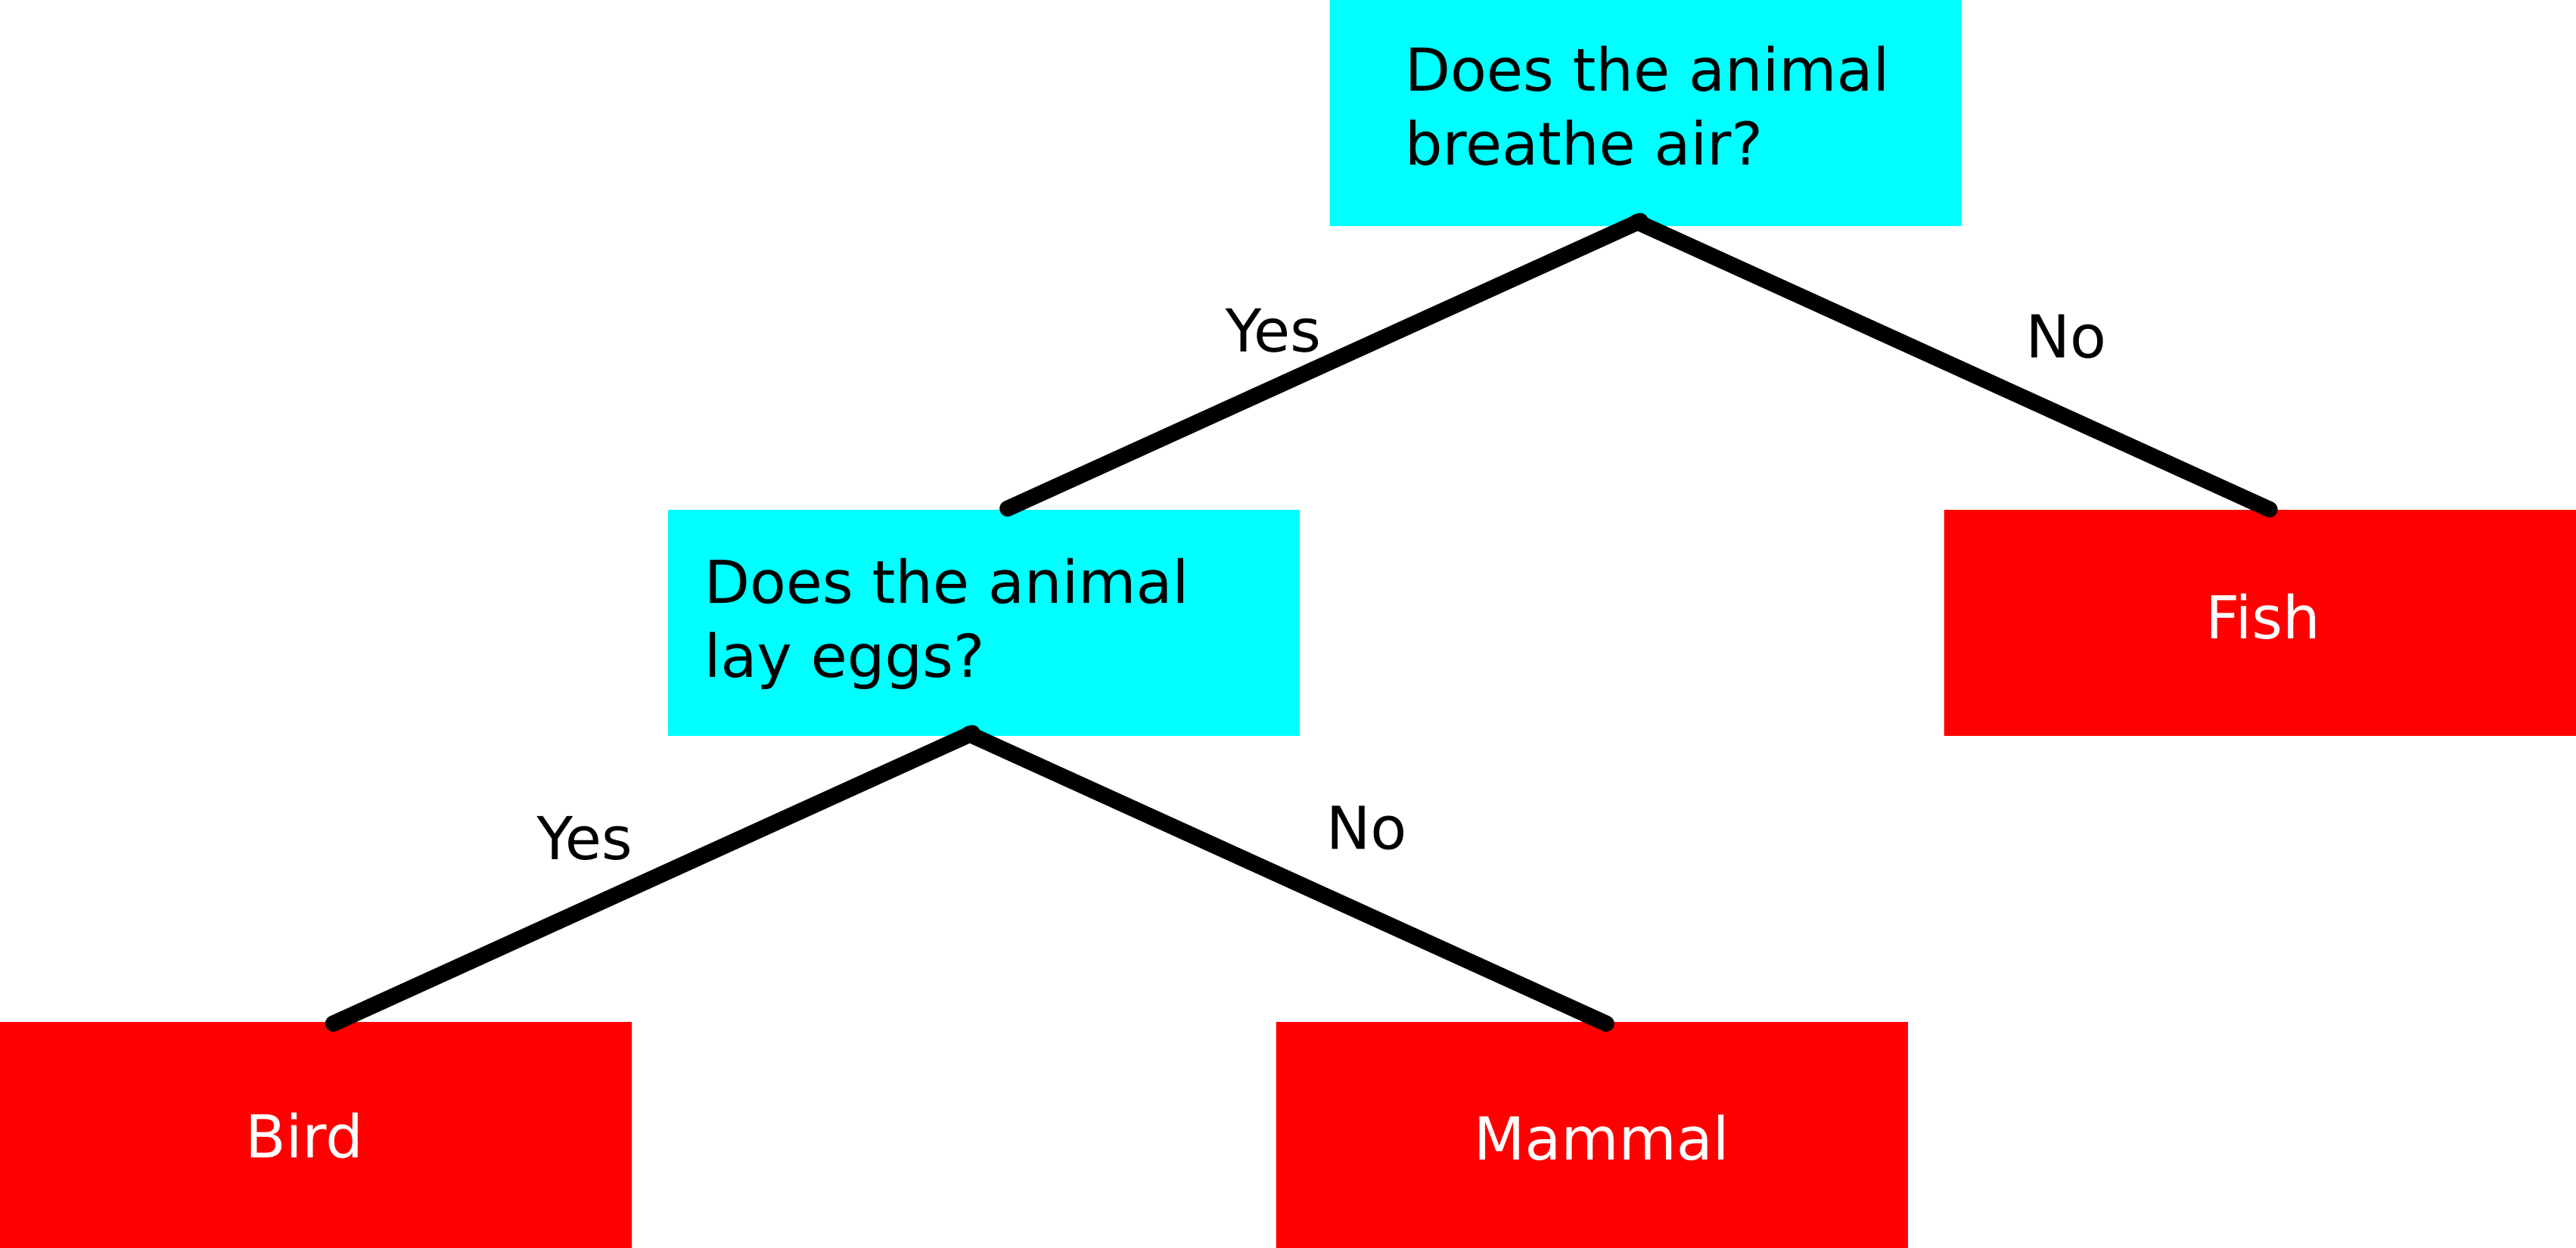 <br>
_Figure 2. Simple Handcrafted Decision Tree._

Decision Trees are exactly as their name suggests. Without getting too much into the math, these class of models specialize in breaking down decision making into a binary tree-like structure. At each level of the tree, a question is asked. If it is true then proceed down one subpath of that node else go down the other subpath. These trees are consisted of a **root**, **branch**, and **leaf** nodes. They can be used for both classification and regression. In classification, the leaf nodes are *classes*. In regression, they are some type of aggregated value of the label feature.

Pros:
* interpretable
* very fast to train
* doesn't need scaling for numerical data
* determines the importance of features for you (also known as **feature selection**)

Cons:
* tends to overfit
* very finnicky especially to small variations ([source](https://www.linkedin.com/pulse/pros-cons-decision-trees-aashima-yuthika/))
* regularization in sklearn is complicated and dependent on dataset and user

If you do want to learn more about decision trees, check out the following resources: 
* [Josh Starmer: Decision and Classification Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=_L39rN6gz7Y)
* [Josh Starmer: Regression Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=g9c66TUylZ4)
* [James Thorn's Article: Decision Trees Explained](https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6)

### 5.2. Random Forest

In [34]:
rand_forest = RandomForestRegressor(criterion="absolute_error", random_state=seed, verbose=verbose)

In [35]:
scores = cross_val_score(rand_forest, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -12.261993464052289
Fold-1: -11.913954248366013
Fold-2: -12.590694444444447
Fold-3: -13.413080065359477
Fold-4: -12.129403594771242

Mean Score: -12.461825163398693


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


>❓We've trained a random forest. But what is a random forest? What are its pros and cons?

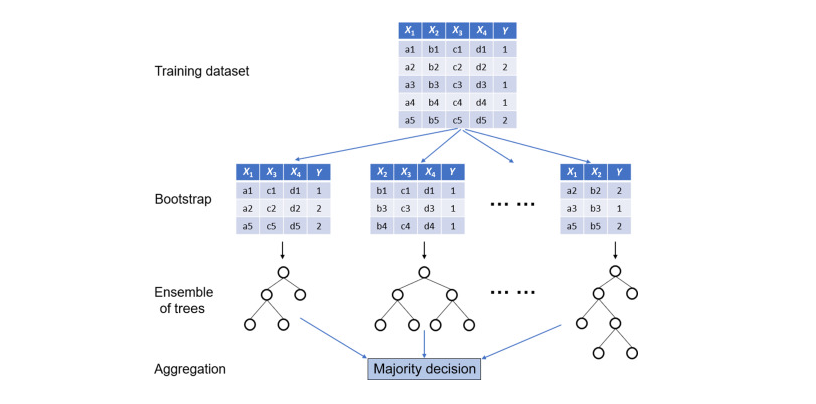 <br>
_Figure 3. Random forest example._

In short, random forests are collections of decision trees. Data is randomly sampled via **bootstrap aggregating or bagging** and a specified number of decision trees that will make up this forest are trained on randomly sampled subsets of the original dataset. This is done in hopes that, in large, the decision tree population will be very diverse leading to more accurate predictions. 

Pros:
* performs much better than a single model (because a random forest is an ensemble)
* decision trees are fast, and since random forests are built upon them, they are also fast
* inherits decision tree pros (e.g. no scaling for numerical features, performs auto-feature selection)

Cons:
* tends to overfit (much like sklearn's default decision tree model)
* has an absurdly high number of hyperparameters and tuning is a pain!
* harder to interpret than a single decision tree

If you do want to learn more about random forests, check out the following resources:
* [Josh Starmer: StatQuest: Random Forests Part 1 - Building, Using and Evaluating](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: StatQuest: Random Forests Part 2: Missing data and clustering](https://www.youtube.com/watch?v=sQ870aTKqiM)
* [James Thorn's Article: Random Forest Explained](https://towardsdatascience.com/random-forest-explained-7eae084f3ebe)
* [Aashima Yuthika: Pros and Cons of Random Forest](https://www.linkedin.com/pulse/pros-cons-random-forest-aashima-yuthika/)

### 5.3. Extra Trees

In [36]:
extra_trees = ExtraTreesRegressor(criterion="absolute_error", random_state=seed, verbose=verbose)

In [37]:
scores = cross_val_score(extra_trees, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.4s


Fold-0: -10.879289215686274
Fold-1: -11.134485294117647
Fold-2: -11.90500816993464
Fold-3: -12.778553921568626
Fold-4: -10.97218137254902

Mean Score: -11.53390359477124


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished


>❓We've trained an extra trees model. But what is an extra trees? What are its pros and cons?

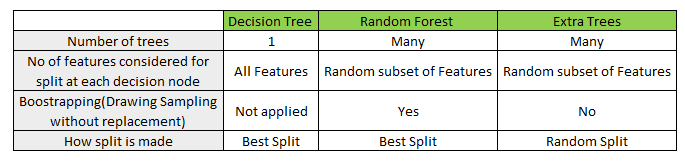 <br>
_Figure 4. Extra Trees comparison with random forest and decision tree._

From Figure 4, Extra Trees are simply random forests except they use the *entire* original dataset and they *don't* look for the optimal split point when deciding what features (and feature values) to select to make decisions. It's all random!

Pros:
* same pros as the random forest; performs similarly to random forest
* less computationally expensive! (you want to consider this especially if you work with very high-dimensional tabular datasets)
* less variance than a random forest model 

Cons:
* same cons as random forest (e.g. harder to interpret, meticulous hyperparameter tuning)

If you'd like to learn more about extra trees, I'd recommend the following resources:
* [Frank Ceballo's Article: An Intuitive Explanation of Random Forest and Extra Trees Classifiers](https://towardsdatascience.com/an-intuitive-explanation-of-random-forest-and-extra-trees-classifiers-8507ac21d54b)
* [Pablo Aznar's Article: What is the difference between Extra Trees and Random Forest?](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/)
* [Jason Brownlee's Article: How to Develop an Extra Trees Ensemble with Python](https://machinelearningmastery.com/extra-trees-ensemble-with-python/)

### 5.4. Support Vector Machine (SVM)

In [38]:
svm = SVR()

In [39]:
scores = cross_val_score(svm, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fold-0: -16.829090212728946
Fold-1: -16.050028172678015
Fold-2: -17.052760452770166
Fold-3: -16.817515659625062
Fold-4: -15.816032599273257

Mean Score: -16.513085419415088


>❓We've trained an SVM. But what is an SVM? What are its pros and cons?

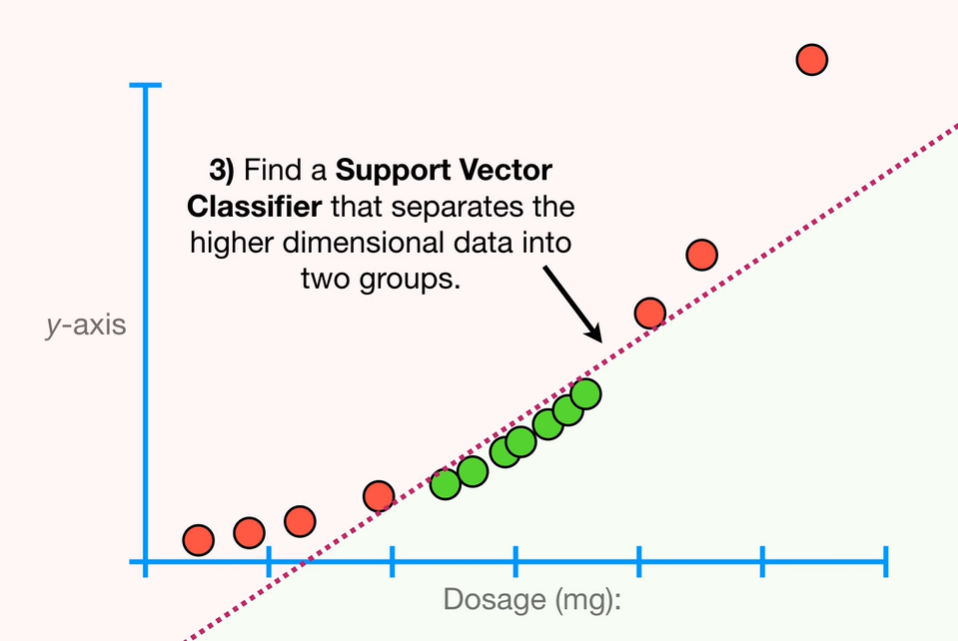 <br>
_Figure 5. An SVM example._

Support Vector Machines (SVMs) linearly separate data for classification, but they can also be used for regression. But in essence, SVMs perform something called the **kernel trick** through a kernel of your choosing to map data to higher dimensions *without actually performing that computationally expensive transformation*. By mapping it to a higher dimension, the SVM will be able to linearly separate the data and give you classifications! In Figure 5, it separates the green instances from the red instances (they are different classes). Notice that it *linearly* separates them and, by separate, they *actually* separate the data with a **hyperplane** (well, specifically, a hyperplane is for anything greater than 3 dimensions).

From the following [source](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/#:~:text=Advantages%20of%20SVM%201%20SVM%20classifiers%20perform%20well,SVM%20is%20useful.%205%20SVM%20uses%20memory%20effectively.).

Pros:
* when number of columns/features exceed number of instances/rows in your dataset, SVMs generally perform better
* generally really good for high dimensional tabular data
* performs well when data is linearly separable

Cons:
* only good for small to medium sized datasets
* doesn't do well when there is lots of noise
* requires a good amount of compute
* hard to interpret

Check out the following resources:
* [Josh Starmer: Support Vector Machines Part 1 (of 3): Main Ideas!!!](https://www.youtube.com/watch?v=efR1C6CvhmE&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: Support Vector Machines Part 2: The Polynomial Kernel (Part 2 of 3)](https://www.youtube.com/watch?v=Toet3EiSFcM&list=RDCMUCtYLUTtgS3k1Fg4y5tAhLbw&index=2)
* [Josh Starmer: Support Vector Machines Part 3: The Radial (RBF) Kernel (Part 3 of 3)](https://www.youtube.com/watch?v=Qc5IyLW_hns&list=RDCMUCtYLUTtgS3k1Fg4y5tAhLbw&index=5)
* [MIT OpenCourseWare: 16. Learning: Support Vector Machines](https://www.youtube.com/watch?v=_PwhiWxHK8o)
* [Vatsal's Article: Support Vector Machine (SVM) Explained](https://towardsdatascience.com/support-vector-machine-svm-explained-58e59708cae3)
* [GeeksforGeeks alokesh985: Introduction to Support Vector Machines (SVM)](https://www.geeksforgeeks.org/introduction-to-support-vector-machines-svm/)

### 5.5. XGBoost

In [40]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

In [41]:
scores = cross_val_score(xgb_reg, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -12.225029826943391
Fold-1: -11.983527114967895
Fold-2: -12.182653190263736
Fold-3: -14.049840266408484
Fold-4: -12.107984792173298

Mean Score: -12.50980703815136


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


>❓We've trained an XGBoost model. But what is an XGBoost model? What are its pros and cons?

Before diving into XGBoost, let's briefly describe **AdaBoost**. Adaptive Boosting or AdaBoost is commonly done with decision trees, and like a random forest, it is an ensemble of decision trees. The difference between AdaBoost and a vanilla random forest is that AdaBoost trains **stumps** (or decision trees with 1 root node and 2 leaf nodes). It will train a series of stumps sequentially, one stump after the other. The novel idea AdaBoost introduces is that each instance in the dataset is given a **sample weight**. And after the first stump is trained on a random subset of the data, the second stump trains on a random subset of the data *prioritizing the instances the first stump got wrong*. The third stump does the same as the second stump did for the first stump. After a certain number of stumps is trained, then they all serve as decision trees with a different **weight**. These weights determine how much *say* they have in the aggregate answer.

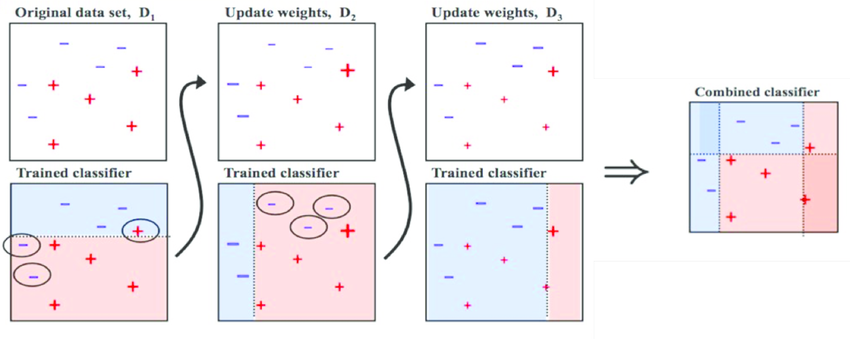 <br>
_Figure 6. AdaBoost._

From Figure 6, the minus and pluses represent data points in the original dataset. The trained AdaBoost model will have a series of classifiers (most commonly decision trees) to train on random subsets of the original data with emphasis on the previous classifier's misclassified instances. Each iteration, the sample weights of the instances in the dataset are updated. The result from this training run is an ensemble of decision tree stumps.

Pros:
* resistant to overfitting
* ensemble of diverse, weak learners -> more interpretable (e.g. each classifier is learning from the misclassified instances of the previous)
* often better than a simple random forest

Cons:
* stumps must be trained sequentially; longer training times

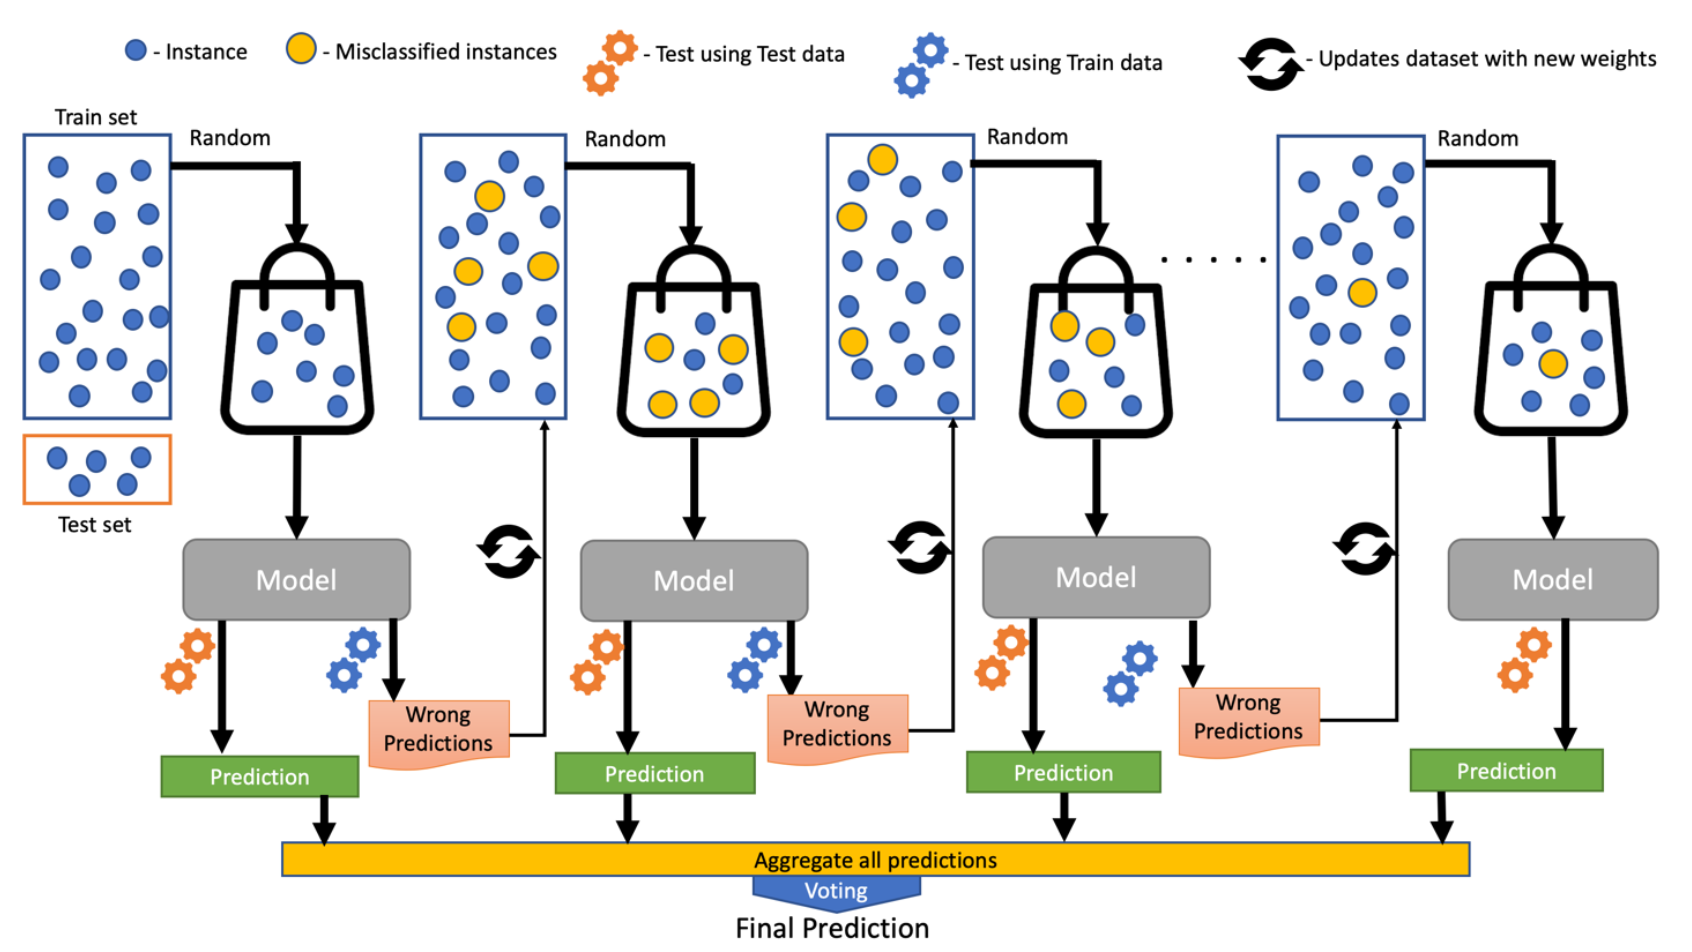 <br>
_Figure 7. XGBoost._

XGBoost is very similar to AdaBoost in that it is sequential and the next classifier is trained on the previous classifier's errors. The difference is that each classifier (a decision tree) is not a *stump*. It is an actual tree. Additionally, for regression, XGBoost is trained with gradient descent and each classifier is trained on the *residuals* or actual errors of the previous classifier. All classifiers within this ensemble are given the same weight. 

Pros:
* same pros as AdaBoost

Cons:
* less interpretable
* needs to be trained sequentially
* may require a good amount of compute

In a lot of cases, XGBoost tends to be the dominant model performance-wise. A lot of Kaggle tabular competitions leverage XGBoost ensembles!

Check out the following resources:
* [Josh Starmer: AdaBoost, Clearly Explained](https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: Gradient Boost Part 1 (of 4): Regression Main Ideas](https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: Gradient Boost Part 2 (of 4): Regression Details](https://www.youtube.com/watch?v=2xudPOBz-vs)
* [Josh Starmer: Gradient Boost Part 3 (of 4): Classification](https://www.youtube.com/watch?v=jxuNLH5dXCs)
* [Josh Starmer: Gradient Boost Part 4 (of 4): Classification Details](https://www.youtube.com/watch?v=StWY5QWMXCw)
* [Josh Starmer: XGBoost in Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE)
* [Josh Starmer: XGBoost Part 1 (of 4): Regression](https://www.youtube.com/watchv=OtD8wVaFm6E&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: XGBoost Part 2 (of 4): Classification](https://www.youtube.com/watch?v=8b1JEDvenQU)
* [Josh Starmer: XGBoost Part 3 (of 4): Mathematical Details](https://www.youtube.com/watch?v=ZVFeW798-2I&ab_channel=StatQuestwithJoshStarmer)
* [Josh Starmer: XGBoost Part 4 (of 4): Crazy Cool Optimizations](https://www.youtube.com/watch?v=oRrKeUCEbq8&t=10s&ab_channel=StatQuestwithJoshStarmer)
* [Ashutosh Nayak's Article: XGBoost: An Intuitive Explanation](https://towardsdatascience.com/xgboost-an-intuitive-explanation-88eb32a48eff)
* [Slides by Tianqi Chen](https://web.njit.edu/~usman/courses/cs675_fall16/BoostedTree.pdf)
* [Original paper](https://arxiv.org/pdf/1603.02754v3.pdf)
* [Python XGBoost library](https://xgboost.readthedocs.io/)

### 5.6. CatBoost

In [42]:
catboost = CatBoostRegressor(eval_metric="MAE",
                             random_seed=seed)

In [43]:
scores = cross_val_score(catboost, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -12.82562409538834
Fold-1: -12.532285972536476
Fold-2: -12.959712314605019
Fold-3: -13.381417174372224
Fold-4: -12.96345403479364

Mean Score: -12.932498718339138


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


>❓We've trained a CatBoost model. But what is an CatBoost model? What are its pros and cons?

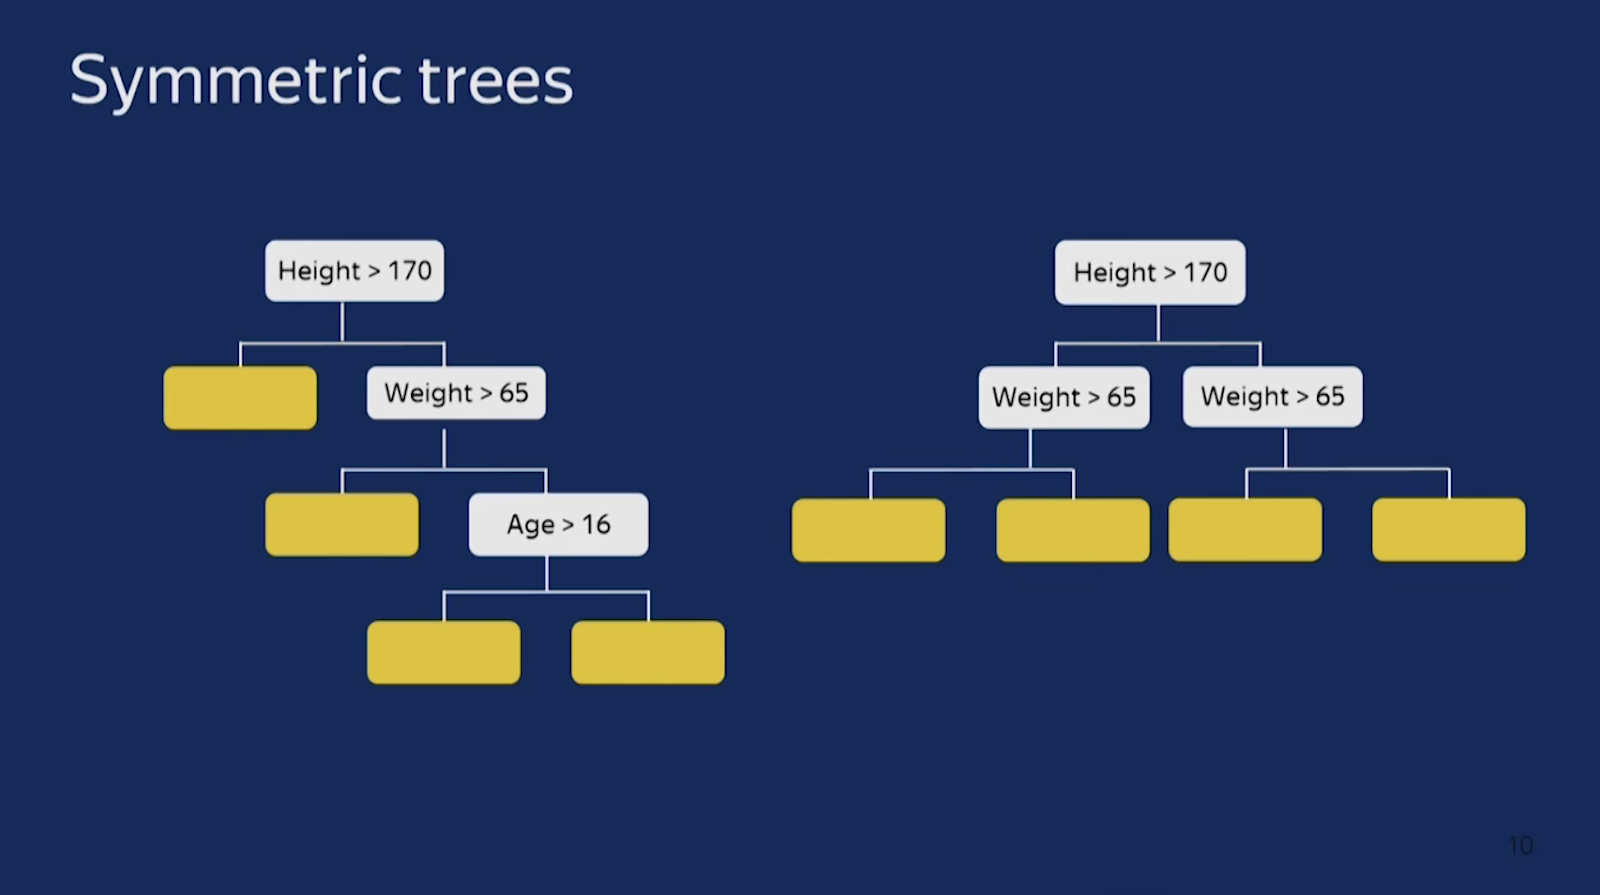 <br>
_Figure 8. Symmetric trees._

CatBoost is another of the family of **gradient boosting machines (GBMs)**. There are a few key differences between CatBoost and XGBoost. CatBoost builds symmetrical trees like the one depicted in Figure 8 as opposed to other algorithms that may build trees node by node, developing into an asymmetric tree. CatBoost (the library) also has a lot of built-in features. One for instance, is its ability to intake categorical features. But doesn't XGBoost do that? Kinda. For XGBoost, you must preprocess the data using some form of encoding like one-hot before the data can be fed in. With CatBoost, you can simply feed in these categorical features! That's less work on your end!

Pros:
* can achieve good performance without much hyperparameter tuning
* efficient and fast
* supports categorical features
* works well with different sized datasets (and also heterogenous data -> mix of categorical and numerical features)

Cons:
* less interpretable

Check out the following resources for more:
* [Nir Alal's Article: XGBoost, LightGBM or CatBoost – which boosting algorithm should I use?](https://www.riskified.com/resources/article/boosting-comparison/#:~:text=Catboost%20grows%20a%20balanced%20tree.%20LightGBM%20uses%20leaf-wise,loss%2C%20allowing%20a%20growth%20of%20an%20imbalanced%20tree.)
* [Meet Raval's Article: Understanding CatBoost Algorithm](https://medium.com/analytics-vidhya/catboost-101-fb2fdc3398f3)
* [catboost.ai](https://catboost.ai/)

### 5.7. LightGBM

In [44]:
lgbm_reg = LGBMRegressor(eval_metric="MAE", random_state=seed)

In [45]:
scores = cross_val_score(lgbm_reg, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -13.991684327951969
Fold-1: -13.740604221713648
Fold-2: -14.032875194752396
Fold-3: -14.498030451891971
Fold-4: -13.562167020592556

Mean Score: -13.96507224338051


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


>❓We've trained a LightGBM model. But what is a LightGBM model? What are its pros and cons?

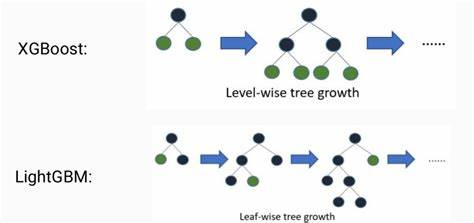 <br>
_Figure 9. leaf-wise tree growth in LightGBM._

LightGBM is yet another gradient boosting machine! The difference between this one and the other 2 are its, of course, unique features provided in its library. Unlike the other 2, LightGBM utilizes **Gradient-based One Side Sampling (GOSS)** and **Exclusive Feature Bundling (EFB)**. GOSS is complicated! But in short, it's an efficient sampling technique to lessen training time. From Thapa's article, GOSS scales gradients so that all instances in the dataset are better accounted for. Exclusive Feature Bundling (EFB) is a method for grouping together sparse features (like a categorical column that was one-hotted). This improves training time.

If you want to learn more, I'd advise looking into these resources:
* [Samrat Thapa's Article: A Quick Guide to the LightGBM Library](https://towardsdatascience.com/a-quick-guide-to-lightgbm-library-ef5385db8d10)
* [GeeksforGeeks shreyanshisingh28's article: LightGBM (Light Gradient Boosting Machine)](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/)
* [Sai Nikhilesh Kasturi: XGBOOST vs LightGBM: Which algorithm wins the race !!!](https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d)
* [LightGBM Python library](https://lightgbm.readthedocs.io/)

### 5.8. Shallow Neural Network

Alright! We've tested a selection of ML models and libraries. Let's also test a shallow densely connected neural network. We will create one with TensorFlow using the Sequential API.

There are a *ton* of hyperparameters you can test for neural networks! We will stick with a simple configuration and standard activation functions (e.g. ReLU).

In [46]:
model = keras.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train_val_prep.shape[1:]),
    keras.layers.Dense(1)  
])

There's our simple neural network! TensorFlow makes it really easy for us to define neural networks. This is one of the simpler cases. If we wanted to, we could design a very complex *deep* neural network. It could have special activation functions, special layers, and a complex training process with even more complex optimizers, schedulers, and other tricks. It's safe to say, deep learning is quite literally lego building! There are tons of different ways to configure your model.

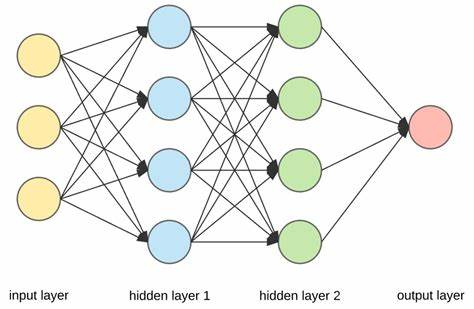 <br>
_Figure 10. A simple fully connected neural network._

A dense neural network is explained by 3 types of layers: input, hidden, and output layers. The input layer intakes the data and the hidden layers perform matrix multiplication computations on this data. In Figure 10, the output of hidden layer 1 will be fed into hidden layer 2. The output of this neural network is a single neuron or value which will be the regression value.

Alright, enough talking, let's compile and train this thing! We will use a simple SGD optimizer with MAE loss again.

In [47]:
model.compile(loss="mean_absolute_error", optimizer="sgd")
history = model.fit(X_train_prep, y_train, epochs=20, validation_data=(X_val_prep, y_val))

Epoch 1/20
44/44 [==============================] - 5s 6ms/step - loss: 131.5255 - val_loss: 126.8477
Epoch 2/20
44/44 [==============================] - 0s 4ms/step - loss: 125.6351 - val_loss: 115.2490
Epoch 3/20
44/44 [==============================] - 0s 3ms/step - loss: 98.5600 - val_loss: 59.2566
Epoch 4/20
44/44 [==============================] - 0s 4ms/step - loss: 27.7606 - val_loss: 18.2527
Epoch 5/20
44/44 [==============================] - 0s 3ms/step - loss: 18.3722 - val_loss: 19.2574
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 18.0476 - val_loss: 18.4859
Epoch 7/20
44/44 [==============================] - 0s 3ms/step - loss: 17.8490 - val_loss: 19.4795
Epoch 8/20
44/44 [==============================] - 0s 3ms/step - loss: 17.6709 - val_loss: 18.1288
Epoch 9/20
44/44 [==============================] - 0s 3ms/step - loss: 17.5854 - val_loss: 18.0370
Epoch 10/20
44/44 [==============================] - 0s 4ms/step - loss: 17.4065 - val_loss: 20.

Our simple neural network trained incredibly fast. For tabular cases and for simple neural networks, this is usually the case. There are a few things to glean from this output. First, the training loss or simply "loss" does go down meaning the network is learning. The val_loss or validation loss does go down, meaning it does learn something useful. The val_loss starts to plateau very early on (maybe 10 epochs into this 20 epoch run) while the training loss continues to go down. This is a case of **overfitting** which, in other words, means the model is too fixated and tailored to the training data to be unable to generalize as effectively as it could be to a held out dataset. 

Also, this simple neural network has a higher loss than most of the ML models we've tested. This is probably due to the simplicity of the architecture we specified. Also, note though neural networks are powerful, the context decides which model is appropriate. Each model has their own ups and downs and selecting the right one is dependent on a variety of factors. Thus, though an NN may be the best, opting for a simple well-tuned Decision Tree might actually be contextually better.

>❓What are the pros and cons of neural networks in tabular dataset settings?

Pros:
* auto feature engineering
* customizability and ability to model very complex, high-dimensional data

Cons:
* black box; very difficult to interpret!
* depending on model size, it may be computationally expensive to train and use for inference

If you want to learn more about neural networks, then you're in luck. There are tons of resources on the internet! Do take a look at the following:
- [Deep Learning Crash Course for Beginners](https://www.youtube.com/watch?v=VyWAvY2CF9c) by freeCodeCamp
- [Keras with TensorFlow Course - Python Deep Learning and Neural Networks for Beginners Tutorial](https://www.youtube.com/watch?v=qFJeN9V1ZsI) by deeplizard
- [Introduction | Deep Learning Tutorial 1 (Tensorflow Tutorial, Keras & Python)](https://www.youtube.com/watch?v=Mubj_fqiAv8&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO) by codebasics
- [TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial](https://www.youtube.com/watch?v=tPYj3fFJGjk) by TechWithTim
- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://github.com/ageron/handson-ml2) by Aurélien Géron
- [PyTorch Tutorials](https://www.youtube.com/watch?v=2S1dgHpqCdk&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz) by Aladdin Persson

We have just trained and validated a selection of models on our preprocessed data. We took a peek into how they work and we've listed their pros and cons. A lot of the models performed similarly. We will continue with Random Forest, XGBoost, CatBoost, and LightGBM. Next, we will perform some feature engineering. The next two sections on feature engineering and hyperparameter sweeping will overlap a bit. It's a cyclic process where I'll go back and forth testing different things, running sweeps, and performing feature selection or engineering.

## 🧪 6. CV Experiments

In this section, we will focus on the cross-validation cycle I described in Figure 1, my ML pipeline. In the previous section we did a coarse assessment of what models do well. In this section we will also address model selection though it would not be the sole focus of this section. Below, I test `EvalML` which is an autoML library for automating every aspect of the ML pipeline from preprocessing to hyperparameter tuning. After this, I'll perform my round of feature engineering, finer model selection, and hyperparameter tuning. My results along with the `EvalML` results will be ensembled later on!

Let's start with [`EvalML`](https://evalml.alteryx.com/en/stable/). This is my first time using EvalML! Apparently, it can automate feature engineering, model selection, hyperparameter tuning, etc. It basically automates every aspect of the ML cycle. It is built on [`featuretools`](https://featuretools.alteryx.com/en/stable/) and [`Compose`](https://compose.alteryx.com/en/stable/). All of these open source tools are made possible by Alteryx.

In [48]:
# The possible problem types EvalML can handle.
evalml.problem_types.problem_types.ProblemTypes.all_problem_types 

[<ProblemTypes.BINARY: 'binary'>,
 <ProblemTypes.MULTICLASS: 'multiclass'>,
 <ProblemTypes.REGRESSION: 'regression'>,
 <ProblemTypes.TIME_SERIES_REGRESSION: 'time series regression'>,
 <ProblemTypes.TIME_SERIES_BINARY: 'time series binary'>,
 <ProblemTypes.TIME_SERIES_MULTICLASS: 'time series multiclass'>]

In [49]:
dir(evalml)

['AutoMLSearch',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'automl',
 'data_checks',
 'demos',
 'evalml',
 'exceptions',
 'model_family',
 'model_understanding',
 'objectives',
 'pipelines',
 'preprocessing',
 'print_info',
 'problem_types',
 'search',
 'search_iterative',
 'sklearn',
 'skopt',
 'tuners',
 'update_checker',
 'utils',
 'warnings']

Below are the available objectives. We will use "mae" or mean absolute error as we have been.

In [50]:
evalml.objectives.get_all_objective_names()

['expvariance',
 'maxerror',
 'medianae',
 'mse',
 'mae',
 'r2',
 'mean squared log error',
 'root mean squared log error',
 'root mean squared error',
 'mean absolute percentage error',
 'mcc multiclass',
 'log loss multiclass',
 'auc weighted',
 'auc macro',
 'auc micro',
 'recall weighted',
 'recall macro',
 'recall micro',
 'precision weighted',
 'precision macro',
 'precision micro',
 'f1 weighted',
 'f1 macro',
 'f1 micro',
 'balanced accuracy multiclass',
 'accuracy multiclass',
 'mcc binary',
 'log loss binary',
 'gini',
 'auc',
 'recall',
 'precision',
 'f1',
 'balanced accuracy binary',
 'accuracy binary',
 'sensitivity at low alert rates',
 'lead scoring',
 'fraud cost',
 'cost benefit matrix']

In [51]:
X_train_prep.shape, X_val_prep.shape, y_train.shape, y_val.shape

((1377, 30), (153, 30), (1377,), (153,))

All we need to do is define an `AutoMLSearch` object with a few arguments and call `.search()`!

In [52]:
automl = AutoMLSearch(X_train=X_train_prep, y_train=y_train, 
                      X_holdout=X_val_prep, y_holdout=y_val,
                      problem_type='regression',
                      objective="mae",
                      random_seed=seed,
                      verbose=True,
                      timing=True)

AutoMLSearch will use the holdout set to score and rank pipelines.
Using default limit of max_batches=3.



In [53]:
automl.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for MAE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of None pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MAE: 19.354
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 19.043

*****************************
* Evaluating Batch Number 1 *
*****************************



C:\Users\alcka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+05, tolerance: 5.630e+01

C:\Users\alcka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+05, tolerance: 5.955e+01

C:\Users\alcka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e+05, tolerance: 5.672e+01



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MAE: 17.228
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 17.227


C:\Users\alcka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e+05, tolerance: 8.632e+01



Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MAE: 15.572
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 15.908

*****************************
* Evaluating Batch Number 2 *
*****************************



C:\Users\alcka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e+05, tolerance: 5.630e+01



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MAE: 17.442
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 17.169
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MAE: 15.597
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 15.763

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean MAE: 16.086
	Starting holdout set scoring
	Finished holdout set scoring - MAE: 16.768
Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished 

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:01',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:01',
  'Total time of batch': '00:03'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:02',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:02',
  'Total time of batch': '00:04'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:01',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:01',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:01',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:01',
  'LightGBM Regressor w/ Replace

In [54]:
automl.rankings

,id,pipeline_name,search_order,validation_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,7,XGBoost Regressor w/ Replace Nullable Types Tr...,7,13.515316,14.124525,1.340805,522.957773,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,9,LightGBM Regressor w/ Replace Nullable Types T...,9,15.628467,15.952250,0.471085,340.185237,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,4,Random Forest Regressor w/ Replace Nullable Ty...,4,15.762958,15.597046,0.515555,375.705631,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,2,Random Forest Regressor w/ Replace Nullable Ty...,2,15.908385,15.571934,0.418936,378.216825,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,Extra Trees Regressor w/ Replace Nullable Type...,6,16.523990,15.678590,0.475881,367.551215,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,5,Decision Tree Regressor w/ Replace Nullable Ty...,5,16.768285,16.086140,0.401818,326.796214,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,3,Elastic Net Regressor w/ Replace Nullable Type...,3,17.168834,17.441852,0.248185,191.225056,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,1,Elastic Net Regressor w/ Replace Nullable Type...,1,17.227030,17.227655,0.119342,212.644796,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,8,CatBoost Regressor w/ Replace Nullable Types T...,8,17.857585,18.311456,0.580878,104.264655,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,0,Mean Baseline Regression Pipeline,0,19.042847,19.354102,0.703149,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


Interesting, as expected LightGBM and XGBoost placed high. What surprised me here was how *low* CatBoost placed (8th!). Below is our best pipeline.

In [55]:
auto_ml_best_pipeline = automl.best_pipeline
auto_ml_best_pipeline

pipeline = RegressionPipeline(component_graph={'Replace Nullable Types Transformer': ['Replace Nullable Types Transformer', 'X', 'y'], 'Imputer': ['Imputer', 'Replace Nullable Types Transformer.x', 'Replace Nullable Types Transformer.y'], 'Select Columns Transformer': ['Select Columns Transformer', 'Imputer.x', 'Replace Nullable Types Transformer.y'], 'XGBoost Regressor': ['XGBoost Regressor', 'Select Columns Transformer.x', 'Replace Nullable Types Transformer.y']}, parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Select Columns Transformer':{'columns': [0, 2, 3, 5, 8, 9, 10, 11, 15, 17, 22, 24, 25, 28, 29]}, 'XGBoost Regressor':{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'n_jobs': -1}}, random_seed=42)

This is a great improvement from our baseline and we can better select which models we might want to use. As far as I know (though I could be wrong), `EvalML` basically ran a *huge* hyperparameter sweep through different models, pipeline components, and features. Basically the whole shebang. We will keep these pipelines here for later use (ENSEMBLING!).

In [56]:
auto_ml_best_pipeline.estimator

XGBoostRegressor(eta=0.1, max_depth=6, min_child_weight=1, n_estimators=100, n_jobs=-1)

In [363]:
joblib.dump(auto_ml_best_pipeline.estimator, "./models/xgboost_evalml.pkl")

['./models/xgboost_evalml.pkl']

In [57]:
auto_ml_best_pipeline.describe()


**************************************************************************************************
* XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer *
**************************************************************************************************

Problem Type: regression
Model Family: XGBoost
Number of features: 15

Pipeline Steps
1. Replace Nullable Types Transformer
2. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
3. Select Columns Transformer
	 * columns : [0, 2, 3, 5, 8, 9, 10, 11, 15, 17, 22, 24, 25, 28, 29]
4. XGBoost Regressor
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100
	 * n_jobs : -1


In [58]:
auto_ml_best_pipeline.feature_importance

,feature,importance
0,22,0.209737
1,17,0.110388
2,15,0.107757
3,9,0.102630
4,29,0.064665
5,24,0.055101
6,11,0.046642
7,5,0.042044
8,28,0.041750
9,25,0.041485


Up to this point, we've used EvalML to perform all the steps we would manually do. We will keep this set of pipelines on the back burner. We will do our own feature engineering and hyperparameter sweeping before ensembling our results with EvalML! In the following two sections, I will also test a few libraries!

### 6.1. Feature Engineering & Dimensionality Reduction

In this section, I will perform feature engineering on the dataset. I'll also briefly touch on dimensionality reduction (DR).

How do we do feature engineering? From my understanding, your feature engineering approach varies a lot by what context you're in. From a Kaggle competitor's perspective, any feature, no matter how unintuitive, so long as it improves performance, will be of use. Other times, features need to be interpreted. I'll do a bit of manual feature engineering and also test some really cool tools! I have `autofeat` in mind. Let's first try some manual feature engineering, then resort to the automated tools.

**Feature engineering** is divided into 5 categories: 
* **feature construction** : creating new features from existing features with domain/data knowledge (manual)
    * _Univariate_
        * indicator variable
        * different categorical encodings
            * _label/ordinal_
            * _one-hot_
            * _target/target mean_
            * _hash_
            * _dummy_
            * _frequency_
            * _binary_
    * _Multivariate_
        * _aggregating_
        * _linear combinations_
        * _arithmetic_
        * _math functions_
    * _domain knowledge_
* **feature selection**    : selecting certain features and removing certain features
    * _VarianceThreshold_ (sklearn)
    * _Univariate Feature Selection_ ([ref](https://scikit-learn.org/stable/modules/feature_selection.html))
        * _SelectKBest_ removes all but the  highest scoring features
        * _SelectPercentile_ removes all but a user-specified highest scoring percentage of features using common univariate statistical tests for each feature: false positive rate SelectFpr, false discovery rate SelectFdr, or family wise error SelectFwe.
        * _GenericUnivariateSelect_ allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.
    * _Recursive Feature Elimination_
    * _SelectFromModel_
        * _L1-based_
        * _tree based_
        * etc
    * _Sequential Feature Selection_
* **feature extraction**   : creating new features or reducing the number of features with special methods (automatic)
    * _dimensionality reduction (DR)_
    * _denoising autoencoders_ 
    * _unsupervised learning_ methods
    * etc
* **feature importance**   : an estimate of how useful the feature is for your task
    * _LOFO_
    * _Shapley values_
    * _Permutation Feature Importance (PFI)_
    * _Split Feature Importance (SFI)_
    * _Gain Feature Importance (GFI)_
* **feature learning**     : the automated process of constructing/extracting and using features
    * _unsupervised learning_
    * _representation learning_
    * _neural networks_

The above descriptions are fairly detailed! We won't be doing all of that, but we will do a bit of each category. First, we will manually construct features. Then, test auto-feature engineering tools. Since XGBoost seems to be our overall most robust model (from our coarse selection and from EvalML), we will test the feature importances with it. From that, we will analyze feature importances with sklearn and also LOFO, Shapley, and PFI. For this specific case, we won't perform feature learning, but we may use PCA later downstream.

We will be building a more complete preprocessing pipeline out of this. We will also be using `df_text` instead  of `df`. `df_text` is the exact same as `df` except it has the job titles and job descriptions.

In [59]:
df_text = pd.read_csv("./input/joblisting_cleaned_withtext.csv")
df_text.head()

,company,rating,job title,headquarters,salary estimate,job type,size,type,sector,revenue,job description
0,Indeed,4.3,Principal Data Scientist - Candidate Recommend...,"San Francisco, CA",209.0,Full-time,10000+ employees,company - private,information technology,$2 to $5 billion (usd),Your Job\nThe Candidate Recommendations team b...
1,Indeed,4.3,Senior Data Scientist - Moderation Engineering,"San Francisco, CA",143.0,Full-time,10000+ employees,company - private,information technology,$2 to $5 billion (usd),Your Job\nThe Moderation Engineering team’s mi...
2,Abl Schools,4.1,Abl Schools | Data Scientist,"San Francisco, CA",140.0,Full-time,1 to 50 employees,company - private,business services,unknown / non-applicable,Overview\nAbl believes every student deserves ...
3,Amazon,3.8,Data Scientist - Nationwide Opportunities,"Palo Alto, CA",115.0,Full-time,10000+ employees,company - public,information technology,$10+ billion (usd),Bachelor’s degree in a highly quantitative fie...
4,Thermo Fisher - America,3.8,Data Scientist III,"San Francisco, CA",134.5,Full-time,10000+ employees,company - public,biotech & pharmaceuticals,$10+ billion (usd),Thermo Fisher Scientific Inc. is the world lea...


Though this is a bit of an inconvenience (and a little messy), let's quickly split the data again and keep `df_text` as our main dataframe from here on out. Notice we keep the same seed, this will preserve the split from last time.

In [60]:
y = df_text["salary estimate"]
X = df_text.drop(columns=["salary estimate"])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

In [93]:
print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)

(1530, 10) (171, 10) (1530,) (171,)


In [61]:
def add_features(df_text):
    
    n_rows = df_text.shape[0]
    
    senior = ["principle", "senior", "staff", "lead", "Sr."]
    junior = ["junior", "entry level", "entry", "intern", "data scientist I"]

    titles = [
        ["data sci", "data science", "data scientist"],
        ["machine learning", "ML", "ML Engineer", "MLE"],
        ["analyst", "data analyst"],
        ["engineer"],
        "bio",
        "consultant",
        "research",
        "manage",
    ]
    
    skills = ["python", "SQL", "R pro", "tableau", 
          ["ML", "machine learning"], "big data", "statistics", 
          ["data structures", "data structure"],
          ["algorithm", "algorithms"],
          "deep learning",
          ["communication", "communicate"],
          ["collab", "colab", "collaborate", "collaboration"],
          ["manage", "manager", "managing", "lead", "leading", "direct", "directing"]
    ]
    
    ########################### TEXT FEATURE ENGINEEERING ###########################
    
    # Is senior or junior position.
    df_text["is_senior"] = df_text["job title"].apply(lambda x: "Y" if any([i.lower() in x.lower() for i in senior]) else "N")
    df_text["is_junior"] = df_text["job title"].apply(lambda x: "Y" if any([i.lower() in x.lower() for i in junior]) else "N")
    
    # Y/N if title.
    for title in titles:
        if type(title) == str:
            title = [title]
        df_text[f"is_{title[0]}"] = df_text["job title"].apply(lambda x: "Y" if any([i.lower() in x.lower() for i in title]) else "N")       
    
    # Y/N if skill.
    for skill in skills:
        if type(skill) == str:
            skill = [skill]
        df_text[f"is_{skill[0]}"] = df_text["job description"].apply(lambda x: "Y" if any([i.lower() in x.lower() for i in skill]) else "N")
        
    ################################## AGGREGATIONS ##################################
        
    # Average rating by headquarters, size, sector, and revenue for mean, median, count, std, mad, skew, and sem.
    agg_by = ["headquarters", "size", "sector", "revenue"]
    agg_stats = ["mean", "median", "count", "std",  "mad", "skew", "sem"]
    for a in agg_by:
        for agg_stat in agg_stats:
            rating_by = df_text.groupby(a)["rating"].agg(agg_stat)
            rating_by.name = f"rating_by_{a}_{agg_stat}"
            if agg_stat in ["std", "skew", "sem"]: rating_by = rating_by.fillna(0)
                
            df_text = df_text.merge(rating_by, on=a)
    
    assert n_rows == df_text.shape[0]
    
    ################################### ARITHMETIC ####################################
    
    # Mathematical functions. 
    df_text["rating_log"] = np.log(df_text["rating"])
    df_text["rating_exp"] = np.exp(df_text["rating"])
    df_text["rating_sqrt"] = np.sqrt(df_text["rating"])
    df_text["rating_cbrt"] = np.cbrt(df_text["rating"])

    return df_text

Our feature engineering is currently enclosed in the function above `add_features`. As I've said before, this entire process of preprocessing, feature engineering, model selection, and hyperparameter sweeping is an iterative proecss. We will write a new preprocessing pipeline supersetting the previous one. This one will contain the base necessities as before, but it will also have a feature engineering component and a few other features.

In [62]:
# Wrap our feature engineering function in a custom sklearn transformer.
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = add_features(X_copy)
        
        return X_copy

I'll define this helper function for getting column names.

In [63]:
def get_num_cat_cols(fe_df):
    is_num_cols = np.array([is_numeric_dtype(fe_df[i]) for i in fe_df.columns])
    num_cols = list(fe_df.columns[is_num_cols])
    cat_cols = list(fe_df.columns[np.logical_not(is_num_cols)]) 
    assert (len(num_cols) + len(cat_cols)) == len(fe_df.columns)
    
    return list(fe_df.columns[is_num_cols]), list(np.logical_not(is_num_cols)) 

Our pipeline will have 1 base and 2 heads. Our base pipeline will be the exact same as before except it would have a feature engineering component. The first head will be a `StandardScaler` and a `OneHotEncoder`. Our second head will have a `RobustScaler` and a `HashingEncoder`. 

Let's define our pipeline now.

In [64]:
# Attributes.
attribs = {
    "remove": ["company", "job title", "job description"],
    "group": ["headquarters", "job type", "size", "type", "sector", "revenue"],
    "num": [],
    "cat": []
}

In [65]:
# Base feature-engineered pipeline.
feature_eng_pipeline = Pipeline([
    ("cat_grouper", CatGrouper(attribs["group"], threshold=0.05)),
    ("engineered_features", AddFeatures()),
    ("remover", CustomRemover(attribs["remove"])),
])
fe_df = feature_eng_pipeline.fit_transform(X_train_val)
fe_head1_num_cols, fe_head1_cat_cols = get_num_cat_cols(fe_df)
attribs["num"] = fe_head1_num_cols
attribs["cat"] = fe_head1_cat_cols

In [66]:
# FE Head 1.
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("one_hot", OneHotEncoder())
])
fe_head1 = ColumnTransformer([
    ("num", num_pipeline, attribs["num"]),
    ("cat", cat_pipeline, attribs["cat"])
])

# FE Head 2.
num_pipeline = Pipeline([
    ("scaler", RobustScaler())
])
cat_pipeline = Pipeline([
    ("hash", HashingEncoder())
])
fe_head2 = ColumnTransformer([
    ("num", num_pipeline, attribs["num"]),
    ("cat", cat_pipeline, attribs["cat"])
])

In [67]:
fe_df_1 = fe_head1.fit_transform(fe_df)
print(type(fe_df_1), fe_df_1.shape)

<class 'numpy.ndarray'> (1530, 106)


In [68]:
fe_df_2 = fe_head2.fit_transform(fe_df)
print(type(fe_df_2), fe_df_2.shape)

<class 'numpy.ndarray'> (1530, 41)


In [69]:
fe_train_val_prep = np.concatenate([fe_df_1, fe_df_2], axis=1)
print(type(fe_train_val_prep), fe_train_val_prep.shape)

<class 'numpy.ndarray'> (1530, 147)


As a quick aside, our dataset has a total of 149 features. This is a ton! We will run a quick test to see roughly how long it takes to train. Then, we will try the same training run with `PCA`. If the performance drop is negligible and the training time increase is notable, then we will keep DR in our pipeline.

In [70]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

scores = cross_val_score(xgb_reg, fe_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fold-0: -23.82664265352137
Fold-1: -22.330968595018575
Fold-2: -23.368600733139935
Fold-3: -23.185989255219503
Fold-4: -23.84336030249502

Mean Score: -23.31111230787888


Interesting, our feature engineered dataset performed worse. DR can also double as a denoising component.

In [71]:
exp_var = 0.95
pca = PCA(n_components=exp_var, random_state=seed)
fe_train_val_prep_dr = pca.fit_transform(fe_train_val_prep)
print(type(fe_train_val_prep_dr), fe_train_val_prep_dr.shape)

<class 'numpy.ndarray'> (1530, 10)


In [72]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

scores = cross_val_score(xgb_reg, fe_train_val_prep_dr, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -21.613610685261246
Fold-1: -22.653016433217168
Fold-2: -22.224432203504776
Fold-3: -25.936638576532502
Fold-4: -22.174727820103463

Mean Score: -22.92048514372383


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Performance boost (though worse than even our baseline) and speed boost. I think it'll be useful to keep DR here. The downside is that the new, reduced dimensions are hard to interpret.

With the engineering portion of feature engineering behind us, we'll perform feature selection based on a simple XGBoost baseline. Let's select based on the PCA and non-PCA version of our pipeline so far. We will evaluate feature importance with a few different methods and cross-reference them to find the best features! The following methods I have in mind:
- feature importance for XGBoost
- LOFO
- Shapley values

In [76]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

xgb_reg.fit(fe_train_val_prep_dr, y_train_val)

[15:24:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [77]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)
xgb_reg.fit(fe_train_val_prep_dr, y_train_val)

[15:24:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [78]:
feat_imp = list(zip(range(fe_train_val_prep_dr.shape[1]), xgb_reg.feature_importances_))
feat_imp.sort(key=lambda x: x[1])
feat_imp = feat_imp[::-1]

for i in feat_imp:
    dim, importance = i
    print(f"dim_{dim}: {importance}")

dim_6: 0.12498562037944794
dim_7: 0.12441635131835938
dim_3: 0.11137475818395615
dim_5: 0.10550989955663681
dim_9: 0.10460138320922852
dim_2: 0.10214659571647644
dim_8: 0.10169616341590881
dim_4: 0.09821122884750366
dim_1: 0.07815632969141006
dim_0: 0.048901669681072235


In [79]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)
xgb_reg.fit(fe_train_val_prep, y_train_val)

[15:24:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [80]:
feat_imp = list(zip(range(fe_train_val_prep.shape[1]), xgb_reg.feature_importances_))
feat_imp.sort(key=lambda x: x[1])
feat_imp = feat_imp[::-1]

for i in feat_imp:
    dim, importance = i
    print(f"dim_{dim}: {importance}")

dim_88: 0.029717229306697845
dim_12: 0.0280630923807621
dim_145: 0.026464179158210754
dim_38: 0.0253368578851223
dim_17: 0.02447715401649475
dim_64: 0.024476276710629463
dim_92: 0.02136216312646866
dim_47: 0.021299123764038086
dim_96: 0.020153656601905823
dim_22: 0.020066749304533005
dim_146: 0.019852006807923317
dim_10: 0.019743921235203743
dim_26: 0.019498663023114204
dim_142: 0.019353577867150307
dim_80: 0.019161822274327278
dim_144: 0.01911301352083683
dim_23: 0.01885908842086792
dim_86: 0.018794817849993706
dim_3: 0.018511593341827393
dim_6: 0.01839568093419075
dim_59: 0.01809987798333168
dim_74: 0.017915982753038406
dim_98: 0.017713630571961403
dim_8: 0.017633922398090363
dim_94: 0.01752539910376072
dim_90: 0.017249928787350655
dim_82: 0.01724541001021862
dim_139: 0.017225874587893486
dim_35: 0.016929099336266518
dim_15: 0.016521334648132324
dim_141: 0.0163644440472126
dim_102: 0.01633366197347641
dim_11: 0.016233447939157486
dim_14: 0.01572928950190544
dim_42: 0.0154375480487942

Yikes! Our engineered features don't help at all! We've checked the DR and non-DR one. Let's also find the importance of the raw features.

In [81]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)
xgb_reg.fit(X_train_val_prep, y_train_val)

feat_imp = list(zip(range(X_train_val_prep.shape[1]), xgb_reg.feature_importances_))
feat_imp.sort(key=lambda x: x[1])
feat_imp = feat_imp[::-1]

for i in feat_imp:
    dim, importance = i
    print(f"dim_{dim}: {importance}")

[15:24:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

dim_22: 0.1316981017589569
dim_17: 0.09250713139772415
dim_9: 0.08825308829545975
dim_24: 0.06012965366244316
dim_15: 0.05824649706482887
dim_29: 0.035487815737724304
dim_28: 0.034745533019304276
dim_1: 0.031791046261787415
dim_19: 0.030470266938209534
dim_25: 0.030319014564156532
dim_23: 0.02931061200797558
dim_2: 0.02756618894636631
dim_6: 0.02469496801495552
dim_11: 0.0244982298463583
dim_12: 0.024337584152817726
dim_4: 0.02426116168498993
dim_5: 0.023643366992473602
dim_0: 0.02309894934296608
dim_20: 0.022683393210172653
dim_21: 0.021829167380928993
dim_16: 0.020725851878523827
dim_10: 0.020209483802318573
dim_27: 0.0187331885099411
dim_18: 0.018678398802876472
dim_8: 0.01866823621094227
dim_14: 0.01789769157767296
dim_3: 0.016746779903769493
dim_26: 0.016656512394547462
dim_13: 0.0121121

It seems that our raw features performed just fine without the need for extra engineered features. Of course, there could definitely be useful engineered features that I haven't tested, but of the ones I tested, none of them were notable.

Let's now test the auto feature engineering tool: `autofeat`!

In [82]:
model = AutoFeatRegressor()
X_train_val_feature_creation = model.fit_transform(X_train_val_prep, y_train_val)

In [83]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

scores = cross_val_score(xgb_reg, X_train_val_feature_creation, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fold-0: -12.513607050079147
Fold-1: -12.142002030914904
Fold-2: -11.922583461586946
Fold-3: -13.88769650926777
Fold-4: -12.31693778941834

Mean Score: -12.55656536825342


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Interesting. Our manual FEs don't help and, at best, `autofeat` doesn't improve upon the baseline score of about -12.5 MAE. We'll do one final round of verification for our manual features with LOFO.

In [84]:
tmp = pd.DataFrame(np.concatenate([fe_train_val_prep_dr, np.expand_dims(y_train_val, 1)], axis=-1))
l = [f"dim_{i}" for i in tmp.columns]
tmp.rename(columns = dict(zip(tmp.columns, l)), inplace = True)

ds = Dataset(tmp, 
             target="dim_10", features=[i for i in tmp.columns if i != "dim_10"],
)

In [85]:
lofo_imp = LOFOImportance(ds, cv=5, scoring="neg_mean_absolute_error")

In [86]:
importance_df = lofo_imp.get_importance()
importance_df

  0%|          | 0/10 [00:00<?, ?it/s]

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4
8,dim_0,0.131147,0.448656,-0.346065,0.619758,0.309606,0.531255,-0.458816
0,dim_3,0.095828,0.278652,0.112904,0.493425,0.295574,-0.186841,-0.235923
1,dim_4,0.023408,0.539198,0.342202,0.594364,0.348123,-0.281212,-0.886439
7,dim_5,0.022410,0.462433,0.071440,0.250309,0.637137,-0.077395,-0.769442
4,dim_9,-0.002063,0.455032,0.128156,0.488002,0.035658,0.198200,-0.860331
5,dim_2,-0.071639,0.316696,-0.388001,0.466610,-0.173450,0.085245,-0.348601
2,dim_8,-0.099648,0.319183,-0.374518,0.008053,0.173230,0.261133,-0.566136
9,dim_7,-0.145945,0.318895,-0.440381,0.437395,-0.297086,-0.058050,-0.371605
6,dim_1,-0.156058,0.192254,-0.211074,0.035599,-0.240972,-0.443168,0.079327
3,dim_6,-0.260085,0.284175,-0.002572,-0.536930,-0.031899,-0.058782,-0.670243


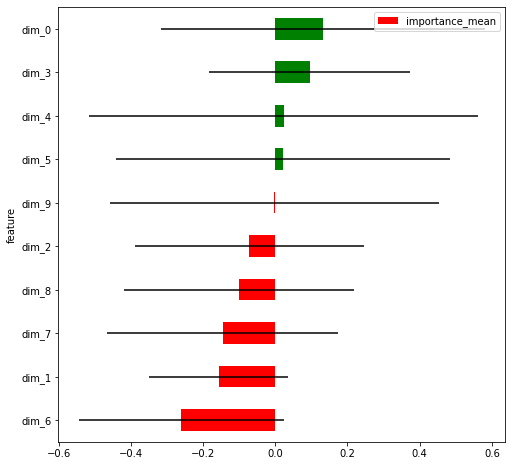

In [87]:
plot_importance(importance_df, figsize=(8, 8))

Assuming I'm interpreting this graph correctly, for our reduced FE input, 6 of the 10 features are pretty useless! Features `dim_0`, `dim_3`, `dim_4`, and `dim_5` seem the most important. I tested it without the DR and the generated graph is all zeros so I will not include that here. Let's check the performance with all the red features removed.

In [88]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

scores = cross_val_score(xgb_reg, fe_train_val_prep_dr[:, [0, 3, 4, 5]], y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


Fold-0: -21.972982020159954
Fold-1: -22.20700973311281
Fold-2: -21.975982242160374
Fold-3: -25.600862191393485
Fold-4: -22.587132385353637

Mean Score: -22.868793714436052


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Slight boost, but nothing notable. :/

Now let's try LOFO on our original dataset.

  0%|          | 0/30 [00:00<?, ?it/s]

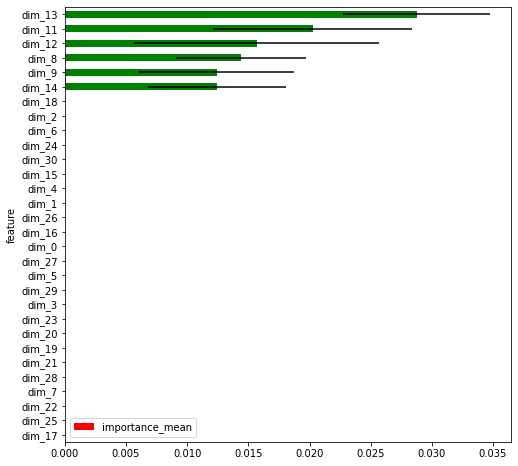

In [89]:
tmp = pd.DataFrame(np.concatenate([X_train_val_prep, np.expand_dims(y_train_val, 1)], axis=-1))
l = [f"dim_{i}" for i in tmp.columns]
tmp.rename(columns = dict(zip(tmp.columns, l)), inplace = True)

ds = Dataset(tmp, 
             target="dim_10", features=[i for i in tmp.columns if i != "dim_10"],
)

lofo_imp = LOFOImportance(ds, cv=n_folds, scoring="neg_mean_absolute_error")
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(8, 8))

From our original basic dataset with no DR or FE, features `dim_13`, `dim_11`, `dim_12`, `dim_8`, `dim_9`, and `dim_14` seem the most important. We will test this.

In [90]:
xgb_reg = XGBRegressor(eval_metric="mae", verbose=verbose, random_state=seed)

scores = cross_val_score(xgb_reg, X_train_val_prep[:, [8, 9, 11, 12, 13, 14]], y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

Fold-0: -19.324236776314528
Fold-1: -18.949611464357066
Fold-2: -19.099508372786776
Fold-3: -19.230119518205232
Fold-4: -18.214402441884957

Mean Score: -18.963575714709712


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Weird. It did much worse. I think this evidence is sufficient to say our original pipeline without feature engineering or dimensionality reduction worked the best. Let's start our hyperparameter sweeps with our original pipeline. We can later ensemble that with EvalML. In the Ensembling section, maybe we could toy with ensembling with the feature engineered pipeline (though unlikely). Though this feature engineering endeavor yielded no promising results, it was still a great learning experience. I'd imagine often times real-world data would have to be extensively studied in order for any useful features to be engineered.

### 6.2. Hyperparameter Sweeping

There is an entire list of hyperparameter tuning tools in addition to sklearn's grid and random search:

- aisaratuners
- raytune
- skopt
- hyperopt
- spearmint
- hyperband
- autosklearn
- optuna
- mlmachine
- polyaxon
- talos
- SHERPA
- GPyOpt
- SMAC3

I'm sure there are many pros and cons to each, but we will use optuna, raytune, and hyperopt. We will tune our original preprocessing pipeline plus a handful of models: XGBoost, LightGBM, CatBoost, and Random Forest. We will test the models on different libraries.

In [110]:
# Our data is already prepared.
X_train_val_prep.shape, y_train_val.shape

((1530, 30), (1530,))

In [173]:
# Using Hyperopt for random forest.

# For some odd reason, "max_depth" gets a type error (must be int but input was float).
# I fixed it with an hp.choice.
space = {
    'max_depth': hp.choice('max_depth', list(range(10, 1200, 10))),
    'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split' : hp.uniform('min_samples_split', 0, 1),
    'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200]),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(space):
    model = RandomForestRegressor(criterion="absolute_error", 
                                  max_depth=space['max_depth'],
                                  max_features=space['max_features'],
                                  min_samples_leaf=space['min_samples_leaf'],
                                  min_samples_split=space['min_samples_split'],
                                  n_estimators=space['n_estimators'], 
                                  n_jobs=n_jobs, verbose=verbose, random_state=seed)
    
    mae = cross_val_score(model, X_train_val_prep, y_train_val, 
                          cv=n_folds, scoring="neg_mean_absolute_error").mean()

    return {'loss': mae, "status": STATUS_OK}

In [172]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80,
            trials=trials)

  0%|                                                                           | 0/80 [00:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.1s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worke

  1%|▌                                                | 1/80 [00:03<04:19,  3.28s/trial, best loss: -18.27763071895425]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)

  2%|█▏                                              | 2/80 [00:06<04:29,  3.46s/trial, best loss: -19.221326361655777]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Do

  4%|█▊                                              | 3/80 [00:07<02:57,  2.30s/trial, best loss: -19.221326361655777]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.0s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    4.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Pa

  5%|██▍                                             | 4/80 [00:29<12:51, 10.16s/trial, best loss: -19.221326361655777]

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    3.4s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | e

  6%|███                                             | 5/80 [00:32<09:18,  7.44s/trial, best loss: -19.221326361655777]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s



  8%|███▌                                            | 6/80 [00:32<06:10,  5.00s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished



  9%|████▏                                           | 7/80 [00:35<05:11,  4.27s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: D

 10%|████▊                                           | 8/80 [00:37<04:16,  3.56s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using b

 11%|█████▍                                          | 9/80 [00:37<02:58,  2.51s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)

 12%|█████▉                                         | 10/80 [00:40<02:47,  2.39s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend 

 14%|██████▍                                        | 11/80 [00:44<03:29,  3.04s/trial, best loss: -19.223888888888887]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Do

 15%|███████                                        | 12/80 [00:45<02:36,  2.29s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 16%|███████▋                                       | 13/80 [00:45<02:02,  1.83s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



 18%|████████▏                                      | 14/80 [00:46<01:28,  1.34s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:

 19%|████████▊                                      | 15/80 [00:50<02:17,  2.12s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.5s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | 

 20%|█████████▍                                     | 16/80 [00:55<03:29,  3.28s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.6s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.1s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concu

 21%|█████████▉                                     | 17/80 [01:03<04:53,  4.65s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    4.8s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapse

 22%|██████████▌                                    | 18/80 [01:36<13:24, 12.98s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    6.8s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.7s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | e

 24%|███████████▏                                   | 19/80 [01:43<11:34, 11.38s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend

 25%|███████████▊                                   | 20/80 [01:44<08:11,  8.20s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 26%|████████████▎                                  | 21/80 [01:45<05:50,  5.94s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 28%|████████████▉                                  | 22/80 [01:46<04:14,  4.39s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 29%|█████████████▌                                 | 23/80 [01:46<03:09,  3.33s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 30%|██████████████                                 | 24/80 [01:48<02:29,  2.67s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 31%|██████████████▋                                | 25/80 [01:48<01:54,  2.08s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 32%|███████████████▎                               | 26/80 [01:49<01:29,  1.66s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 34%|███████████████▊                               | 27/80 [01:50<01:12,  1.38s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

 35%|████████████████▍                              | 28/80 [01:50<01:00,  1.17s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

 36%|█████████████████                              | 29/80 [01:51<00:49,  1.03trial/s, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

 38%|█████████████████▋                             | 30/80 [01:51<00:42,  1.18trial/s, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)

 39%|██████████████████▏                            | 31/80 [01:52<00:31,  1.53trial/s, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  5

 40%|██████████████████▊                            | 32/80 [01:52<00:29,  1.65trial/s, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Para

 41%|███████████████████▍                           | 33/80 [01:57<01:24,  1.79s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend w

 42%|███████████████████▉                           | 34/80 [01:57<01:06,  1.44s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.9s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent wo

 44%|████████████████████▌                          | 35/80 [02:05<02:24,  3.21s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.1s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: 

 45%|█████████████████████▏                         | 36/80 [02:07<02:09,  2.93s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  

 46%|█████████████████████▋                         | 37/80 [02:07<01:31,  2.14s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:

 48%|██████████████████████▎                        | 38/80 [02:08<01:12,  1.72s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.

 49%|██████████████████████▉                        | 39/80 [02:10<01:19,  1.95s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    1.0s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elap

 50%|███████████████████████▌                       | 40/80 [02:16<02:04,  3.12s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Do

 51%|████████████████████████                       | 41/80 [02:17<01:32,  2.36s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)

 52%|████████████████████████▋                      | 42/80 [02:17<01:05,  1.72s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)

 54%|█████████████████████████▎                     | 43/80 [02:20<01:16,  2.06s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    1.3s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    1.4s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | e

 55%|█████████████████████████▊                     | 44/80 [02:28<02:17,  3.82s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s

 56%|██████████████████████████▍                    | 45/80 [02:28<01:39,  2.84s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 57%|███████████████████████████                    | 46/80 [02:29<01:13,  2.15s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Paral

 59%|███████████████████████████▌                   | 47/80 [02:31<01:10,  2.14s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elap

 60%|████████████████████████████▏                  | 48/80 [02:35<01:27,  2.72s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worke

 61%|████████████████████████████▊                  | 49/80 [02:36<01:02,  2.02s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worke

 62%|█████████████████████████████▍                 | 50/80 [02:42<01:36,  3.21s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s 

 64%|█████████████████████████████▉                 | 51/80 [02:42<01:10,  2.43s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Para

 65%|██████████████████████████████▌                | 52/80 [02:46<01:19,  2.85s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Do

 66%|███████████████████████████████▏               | 53/80 [02:47<00:58,  2.16s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

 68%|███████████████████████████████▋               | 54/80 [02:47<00:43,  1.68s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.6s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[P

 69%|████████████████████████████████▎              | 55/80 [02:53<01:13,  2.95s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Paralle

 70%|████████████████████████████████▉              | 56/80 [02:53<00:51,  2.13s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)

 71%|█████████████████████████████████▍             | 57/80 [02:56<00:51,  2.23s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0

 72%|██████████████████████████████████             | 58/80 [02:56<00:38,  1.73s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

 74%|██████████████████████████████████▋            | 59/80 [02:57<00:29,  1.40s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worke

 75%|███████████████████████████████████▎           | 60/80 [03:02<00:49,  2.47s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Do

 76%|███████████████████████████████████▊           | 61/80 [03:03<00:36,  1.95s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 78%|████████████████████████████████████▍          | 62/80 [03:03<00:27,  1.55s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.6s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent wo

 79%|█████████████████████████████████████          | 63/80 [03:10<00:55,  3.27s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.1s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done

 80%|█████████████████████████████████████▌         | 64/80 [03:11<00:38,  2.38s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished

[Parallel(n_jobs=8)

 81%|██████████████████████████████████████▏        | 65/80 [03:16<00:47,  3.16s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0

 82%|██████████████████████████████████████▊        | 66/80 [03:17<00:34,  2.45s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 84%|███████████████████████████████████████▎       | 67/80 [03:17<00:25,  1.92s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 85%|███████████████████████████████████████▉       | 68/80 [03:18<00:19,  1.59s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0

 86%|████████████████████████████████████████▌      | 69/80 [03:19<00:14,  1.35s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend 

 88%|█████████████████████████████████████████▏     | 70/80 [03:20<00:12,  1.24s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend w

 89%|█████████████████████████████████████████▋     | 71/80 [03:21<00:10,  1.16s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.

 90%|██████████████████████████████████████████▎    | 72/80 [03:22<00:08,  1.11s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks   

 91%|██████████████████████████████████████████▉    | 73/80 [03:23<00:07,  1.05s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend w

 92%|███████████████████████████████████████████▍   | 74/80 [03:24<00:06,  1.03s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 735 out of 750 | elapsed:    0.8s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.8s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 694 

 94%|████████████████████████████████████████████   | 75/80 [03:32<00:15,  3.16s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      |

 95%|████████████████████████████████████████████▋  | 76/80 [03:33<00:10,  2.53s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend w

 96%|█████████████████████████████████████████████▏ | 77/80 [03:34<00:06,  2.01s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    0.8s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.1s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 |

 98%|█████████████████████████████████████████████▊ | 78/80 [03:42<00:07,  3.96s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    0.1s

[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Paralle

 99%|██████████████████████████████████████████████▍| 79/80 [03:43<00:02,  2.93s/trial, best loss: -19.225398692810458]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished

[Parallel(n_jobs=8)

100%|███████████████████████████████████████████████| 80/80 [03:45<00:00,  2.82s/trial, best loss: -19.225398692810458]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished



In [174]:
best

{'bootstrap': 0,
 'max_depth': 77,
 'max_features': 0,
 'min_samples_leaf': 0.47423016703089454,
 'min_samples_split': 0.8673161186306917,
 'n_estimators': 1}

1 estimator?! I am curious to see the results of this model.

In [176]:
rand_forest = RandomForestRegressor(criterion="absolute_error", random_state=seed, 
                                    bootstrap=False, max_depth=77, min_samples_leaf=0.47423016703089454, 
                                    min_samples_split=0.8673161186306917, n_estimators=1,
                                    verbose=verbose)

scores = cross_val_score(rand_forest, X_train_val_prep, y_train_val,
                         cv=n_folds, scoring="neg_mean_absolute_error", 
                         n_jobs=n_jobs, verbose=verbose)

for fold, score in zip(range(n_folds), scores):
    print(f"Fold-{fold}: {score}")
    
print(f"\nMean Score: {np.mean(scores)}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fold-0: -18.964052287581698
Fold-1: -17.826797385620914
Fold-2: -18.648692810457515
Fold-3: -18.538398692810457
Fold-4: -17.995098039215687

Mean Score: -18.39460784313726


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Not bad. This is much better than our feature engineered XGBoost! Note, yes, this is worst than our baselines (for random forest), but the sklearn default hyperparameters for random forests are suited to overfit on the data. So though it may seem we dropped in performance, we actually improved (and preserved some generalizability) from our previous experiments!

In [232]:
# Training CatBoost with raytune.

catboost = CatBoostRegressor(random_seed=seed)


# From: https://catboost.ai/en/docs/concepts/parameter-tuning
param_grid = {
    "max_depth": list(range(1, 10, 2)),
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "n_estimators": list(range(100, 501, 100)),
    "border_count": [5, 10, 20, 50, 100, 200],
    "l2_leaf_reg": [1, 3, 5, 10, 100],
}

tune_search = TuneSearchCV(
    catboost, param_grid, early_stopping=None, scoring="neg_mean_absolute_error", 
    n_jobs=n_jobs, cv=n_folds, refit=True, verbose=verbose,
    local_dir='~/ray_results', name="catboost", search_optimization="random"
)

In [233]:
tune_search.fit(X_train_val_prep, y_train_val)

2022-12-26 01:38:25,726	WARNING tune.py:674 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, wrap `train_func` with `tune.with_resources(train_func, resources_per_trial={'gpu': 1})` which allows Tune to expose 1 GPU to each trial. For Ray AIR Trainers, you can specify GPU resources through `ScalingConfig(use_gpu=True)`. You can also override `Trainable.default_resource_request` if using the Trainable API.


(pid=27332) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=27332) 0:	learn: 24.2689936	total: 146ms	remaining: 14.4s
(_Trainable pid=27332) 1:	learn: 23.8991078	total: 146ms	remaining: 7.15s
(_Trainable pid=27332) 2:	learn: 23.6477922	total: 146ms	remaining: 4.73s
(_Trainable pid=27332) 3:	learn: 23.4127142	total: 146ms	remaining: 3.51s
(_Trainable pid=27332) 4:	learn: 23.2552170	total: 147ms	remaining: 2.79s
(_Trainable pid=27332) 5:	learn: 23.1288690	total: 147ms	remaining: 2.3s
(_Trainable pid=27332) 6:	learn: 22.9648303	total: 147ms	remaining: 1.96s
(_Trainable pid=27332) 7:	learn: 22.8232210	total: 147ms	remaining: 1.7s
(_Trainable pid=27332) 8:	learn: 22.7526878	total: 148ms	remaining: 1.49s
(_Trainable pid=27332) 9:	learn: 22.6885970	total: 148ms	remaining: 1.33s
(_Trainable pid=27332) 10:	learn: 22.6555921	total: 148ms	remaining: 1.2s
(_Trainable pid=27332) 11:	learn: 22.5844749	total: 148ms	remaining: 1.09s
(_Trainable pid=27332) 12:	learn: 22.5617030	total: 149ms	remaining: 994ms
(_Trainable pid=27332) 13:	learn: 22.4

(_Trainable pid=27332) 0:	learn: 24.4032135	total: 349us	remaining: 34.6ms
(_Trainable pid=27332) 1:	learn: 24.0762202	total: 644us	remaining: 31.6ms
(_Trainable pid=27332) 2:	learn: 23.8033525	total: 885us	remaining: 28.6ms
(_Trainable pid=27332) 3:	learn: 23.4892984	total: 1.12ms	remaining: 26.8ms
(_Trainable pid=27332) 4:	learn: 23.2043229	total: 1.34ms	remaining: 25.5ms
(_Trainable pid=27332) 5:	learn: 23.0932139	total: 1.58ms	remaining: 24.8ms
(_Trainable pid=27332) 6:	learn: 23.0052934	total: 1.81ms	remaining: 24ms
(_Trainable pid=27332) 7:	learn: 22.8760363	total: 2.04ms	remaining: 23.5ms
(_Trainable pid=27332) 8:	learn: 22.7604466	total: 2.27ms	remaining: 22.9ms
(_Trainable pid=27332) 9:	learn: 22.6691642	total: 2.54ms	remaining: 22.9ms
(_Trainable pid=27332) 10:	learn: 22.6139762	total: 2.79ms	remaining: 22.6ms
(_Trainable pid=27332) 11:	learn: 22.5417213	total: 3.02ms	remaining: 22.2ms
(_Trainable pid=27332) 12:	learn: 22.5108933	total: 3.28ms	remaining: 22ms
(_Trainable pid=

(pid=14740) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=14740) 0:	learn: 24.7916210	total: 143ms	remaining: 42.8s
(_Trainable pid=14740) 1:	learn: 24.7409757	total: 144ms	remaining: 21.4s
(_Trainable pid=14740) 2:	learn: 24.6883800	total: 144ms	remaining: 14.3s
(_Trainable pid=14740) 3:	learn: 24.6420613	total: 145ms	remaining: 10.7s
(_Trainable pid=14740) 4:	learn: 24.5927671	total: 146ms	remaining: 8.59s
(_Trainable pid=14740) 5:	learn: 24.5522530	total: 146ms	remaining: 7.17s
(_Trainable pid=14740) 6:	learn: 24.5022244	total: 147ms	remaining: 6.14s
(_Trainable pid=14740) 7:	learn: 24.4603012	total: 147ms	remaining: 5.38s
(_Trainable pid=14740) 8:	learn: 24.4174680	total: 148ms	remaining: 4.78s
(_Trainable pid=14740) 9:	learn: 24.3734698	total: 148ms	remaining: 4.3s
(_Trainable pid=14740) 10:	learn: 24.3283779	total: 149ms	remaining: 3.91s
(_Trainable pid=14740) 11:	learn: 24.2897080	total: 149ms	remaining: 3.59s
(_Trainable pid=14740) 12:	learn: 24.2466770	total: 150ms	remaining: 3.31s
(_Trainable pid=14740) 13:	learn: 24

(_Trainable pid=14740) 0:	learn: 25.3412214	total: 583us	remaining: 174ms
(_Trainable pid=14740) 1:	learn: 25.2871065	total: 1.28ms	remaining: 191ms
(_Trainable pid=14740) 2:	learn: 25.2399407	total: 1.97ms	remaining: 196ms
(_Trainable pid=14740) 3:	learn: 25.1837177	total: 2.61ms	remaining: 193ms
(_Trainable pid=14740) 4:	learn: 25.1292812	total: 3.33ms	remaining: 197ms
(_Trainable pid=14740) 5:	learn: 25.0865128	total: 4.25ms	remaining: 208ms
(_Trainable pid=14740) 6:	learn: 25.0335076	total: 4.93ms	remaining: 206ms
(_Trainable pid=14740) 7:	learn: 24.9832897	total: 5.64ms	remaining: 206ms
(_Trainable pid=14740) 8:	learn: 24.9391282	total: 6.23ms	remaining: 201ms
(_Trainable pid=14740) 9:	learn: 24.8895721	total: 6.78ms	remaining: 197ms
(_Trainable pid=14740) 10:	learn: 24.8433140	total: 7.41ms	remaining: 195ms
(_Trainable pid=14740) 11:	learn: 24.7945202	total: 8.04ms	remaining: 193ms
(_Trainable pid=14740) 12:	learn: 24.7464734	total: 8.61ms	remaining: 190ms
(_Trainable pid=14740) 

(_Trainable pid=14740) 0:	learn: 24.9987427	total: 684us	remaining: 205ms
(_Trainable pid=14740) 1:	learn: 24.9441564	total: 1.28ms	remaining: 191ms
(_Trainable pid=14740) 2:	learn: 24.8866779	total: 1.82ms	remaining: 180ms
(_Trainable pid=14740) 3:	learn: 24.8313739	total: 2.42ms	remaining: 179ms
(_Trainable pid=14740) 4:	learn: 24.7779785	total: 2.98ms	remaining: 176ms
(_Trainable pid=14740) 5:	learn: 24.7347479	total: 3.51ms	remaining: 172ms
(_Trainable pid=14740) 6:	learn: 24.6802017	total: 4.1ms	remaining: 172ms
(_Trainable pid=14740) 7:	learn: 24.6303198	total: 4.77ms	remaining: 174ms
(_Trainable pid=14740) 8:	learn: 24.5789791	total: 5.38ms	remaining: 174ms
(_Trainable pid=14740) 9:	learn: 24.5254630	total: 5.94ms	remaining: 172ms
(_Trainable pid=14740) 10:	learn: 24.4745201	total: 7.16ms	remaining: 188ms
(_Trainable pid=14740) 11:	learn: 24.4241721	total: 7.82ms	remaining: 188ms
(_Trainable pid=14740) 12:	learn: 24.3830378	total: 8.35ms	remaining: 184ms
(_Trainable pid=14740) 1

(_Trainable pid=14740) 0:	learn: 24.8465202	total: 734us	remaining: 220ms
(_Trainable pid=14740) 1:	learn: 24.7934874	total: 1.3ms	remaining: 194ms
(_Trainable pid=14740) 2:	learn: 24.7444874	total: 1.9ms	remaining: 188ms
(_Trainable pid=14740) 3:	learn: 24.6947445	total: 2.53ms	remaining: 187ms
(_Trainable pid=14740) 4:	learn: 24.6405284	total: 3.09ms	remaining: 183ms
(_Trainable pid=14740) 5:	learn: 24.5930712	total: 3.63ms	remaining: 178ms
(_Trainable pid=14740) 6:	learn: 24.5383452	total: 4.28ms	remaining: 179ms
(_Trainable pid=14740) 7:	learn: 24.4959879	total: 4.81ms	remaining: 176ms
(_Trainable pid=14740) 8:	learn: 24.4498912	total: 5.42ms	remaining: 175ms
(_Trainable pid=14740) 9:	learn: 24.4024184	total: 6.11ms	remaining: 177ms
(_Trainable pid=14740) 10:	learn: 24.3512266	total: 6.79ms	remaining: 178ms
(_Trainable pid=14740) 11:	learn: 24.3053245	total: 7.43ms	remaining: 178ms
(_Trainable pid=14740) 12:	learn: 24.2594337	total: 8.21ms	remaining: 181ms
(_Trainable pid=14740) 13

(_Trainable pid=14740) 0:	learn: 25.0424455	total: 736us	remaining: 220ms
(_Trainable pid=14740) 1:	learn: 24.9898918	total: 1.39ms	remaining: 207ms
(_Trainable pid=14740) 2:	learn: 24.9354747	total: 2.03ms	remaining: 201ms
(_Trainable pid=14740) 3:	learn: 24.8827175	total: 2.67ms	remaining: 198ms
(_Trainable pid=14740) 4:	learn: 24.8306569	total: 3.35ms	remaining: 198ms
(_Trainable pid=14740) 5:	learn: 24.7873448	total: 3.96ms	remaining: 194ms
(_Trainable pid=14740) 6:	learn: 24.7346802	total: 4.52ms	remaining: 189ms
(_Trainable pid=14740) 7:	learn: 24.6848986	total: 5.09ms	remaining: 186ms
(_Trainable pid=14740) 8:	learn: 24.6374647	total: 5.61ms	remaining: 182ms
(_Trainable pid=14740) 9:	learn: 24.5913676	total: 6.35ms	remaining: 184ms
(_Trainable pid=14740) 10:	learn: 24.5439228	total: 7.19ms	remaining: 189ms
(_Trainable pid=14740) 11:	learn: 24.4972684	total: 7.8ms	remaining: 187ms
(_Trainable pid=14740) 12:	learn: 24.4470495	total: 8.43ms	remaining: 186ms
(_Trainable pid=14740) 1

(pid=3404) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=3404) 0:	learn: 24.7916210	total: 146ms	remaining: 29.1s
(_Trainable pid=3404) 1:	learn: 24.7408680	total: 147ms	remaining: 14.5s
(_Trainable pid=3404) 2:	learn: 24.6891296	total: 147ms	remaining: 9.68s
(_Trainable pid=3404) 3:	learn: 24.6428070	total: 148ms	remaining: 7.25s
(_Trainable pid=3404) 4:	learn: 24.5935214	total: 149ms	remaining: 5.79s
(_Trainable pid=3404) 5:	learn: 24.5514147	total: 149ms	remaining: 4.83s
(_Trainable pid=3404) 6:	learn: 24.5013770	total: 150ms	remaining: 4.13s
(_Trainable pid=3404) 7:	learn: 24.4594770	total: 150ms	remaining: 3.61s
(_Trainable pid=3404) 8:	learn: 24.4166729	total: 151ms	remaining: 3.2s
(_Trainable pid=3404) 9:	learn: 24.3709446	total: 151ms	remaining: 2.88s
(_Trainable pid=3404) 10:	learn: 24.3303716	total: 152ms	remaining: 2.61s
(_Trainable pid=3404) 11:	learn: 24.2908073	total: 152ms	remaining: 2.39s
(_Trainable pid=3404) 12:	learn: 24.2455500	total: 153ms	remaining: 2.2s
(_Trainable pid=3404) 13:	learn: 24.2008861	total:

(_Trainable pid=3404) 48:	learn: 23.3886195	total: 30ms	remaining: 92.3ms
(_Trainable pid=3404) 49:	learn: 23.3641204	total: 30.5ms	remaining: 91.6ms
(_Trainable pid=3404) 50:	learn: 23.3384817	total: 31.2ms	remaining: 91.1ms
(_Trainable pid=3404) 51:	learn: 23.3092765	total: 31.7ms	remaining: 90.4ms
(_Trainable pid=3404) 52:	learn: 23.2839955	total: 32.3ms	remaining: 89.6ms
(_Trainable pid=3404) 53:	learn: 23.2528648	total: 32.9ms	remaining: 88.9ms
(_Trainable pid=3404) 54:	learn: 23.2286360	total: 33.5ms	remaining: 88.4ms
(_Trainable pid=3404) 55:	learn: 23.2003228	total: 34.2ms	remaining: 87.8ms
(_Trainable pid=3404) 56:	learn: 23.1723781	total: 34.8ms	remaining: 87.2ms
(_Trainable pid=3404) 57:	learn: 23.1483344	total: 35.4ms	remaining: 86.7ms
(_Trainable pid=3404) 58:	learn: 23.1251364	total: 35.9ms	remaining: 85.8ms
(_Trainable pid=3404) 59:	learn: 23.1049158	total: 36.4ms	remaining: 85ms
(_Trainable pid=3404) 60:	learn: 23.0788426	total: 37.1ms	remaining: 84.5ms
(_Trainable pid=

(_Trainable pid=3404) 37:	learn: 23.3408333	total: 23.7ms	remaining: 101ms
(_Trainable pid=3404) 38:	learn: 23.3079096	total: 24.3ms	remaining: 101ms
(_Trainable pid=3404) 39:	learn: 23.2764967	total: 24.9ms	remaining: 99.5ms
(_Trainable pid=3404) 40:	learn: 23.2418061	total: 25.4ms	remaining: 98.4ms
(_Trainable pid=3404) 41:	learn: 23.2085870	total: 26ms	remaining: 97.8ms
(_Trainable pid=3404) 42:	learn: 23.1761935	total: 26.6ms	remaining: 97ms
(_Trainable pid=3404) 43:	learn: 23.1462628	total: 27.3ms	remaining: 96.8ms
(_Trainable pid=3404) 44:	learn: 23.1220580	total: 28.2ms	remaining: 97ms
(_Trainable pid=3404) 45:	learn: 23.0909623	total: 29.1ms	remaining: 97.3ms
(_Trainable pid=3404) 46:	learn: 23.0629870	total: 29.7ms	remaining: 96.7ms
(_Trainable pid=3404) 47:	learn: 23.0335626	total: 30.3ms	remaining: 95.9ms
(_Trainable pid=3404) 48:	learn: 23.0021167	total: 30.9ms	remaining: 95.2ms
(_Trainable pid=3404) 49:	learn: 22.9765313	total: 31.5ms	remaining: 94.6ms
(_Trainable pid=3404

(_Trainable pid=3404) 5:	learn: 24.5846311	total: 3.39ms	remaining: 110ms
(_Trainable pid=3404) 6:	learn: 24.5299466	total: 3.99ms	remaining: 110ms
(_Trainable pid=3404) 7:	learn: 24.4875836	total: 4.5ms	remaining: 108ms
(_Trainable pid=3404) 8:	learn: 24.4406438	total: 5.03ms	remaining: 107ms
(_Trainable pid=3404) 9:	learn: 24.3963142	total: 5.59ms	remaining: 106ms
(_Trainable pid=3404) 10:	learn: 24.3458035	total: 6.12ms	remaining: 105ms
(_Trainable pid=3404) 11:	learn: 24.3071872	total: 6.74ms	remaining: 106ms
(_Trainable pid=3404) 12:	learn: 24.2621968	total: 7.32ms	remaining: 105ms
(_Trainable pid=3404) 13:	learn: 24.2144729	total: 7.91ms	remaining: 105ms
(_Trainable pid=3404) 14:	learn: 24.1687536	total: 8.43ms	remaining: 104ms
(_Trainable pid=3404) 15:	learn: 24.1248698	total: 9.09ms	remaining: 105ms
(_Trainable pid=3404) 16:	learn: 24.0807202	total: 9.69ms	remaining: 104ms
(_Trainable pid=3404) 17:	learn: 24.0348512	total: 10.2ms	remaining: 103ms
(_Trainable pid=3404) 18:	learn

(_Trainable pid=3404) 4:	learn: 24.8319807	total: 2.69ms	remaining: 105ms
(_Trainable pid=3404) 5:	learn: 24.7886447	total: 3.24ms	remaining: 105ms
(_Trainable pid=3404) 6:	learn: 24.7355432	total: 3.78ms	remaining: 104ms
(_Trainable pid=3404) 7:	learn: 24.6863319	total: 4.27ms	remaining: 102ms
(_Trainable pid=3404) 8:	learn: 24.6395348	total: 4.92ms	remaining: 105ms
(_Trainable pid=3404) 9:	learn: 24.5937203	total: 5.55ms	remaining: 106ms
(_Trainable pid=3404) 10:	learn: 24.5491539	total: 6.12ms	remaining: 105ms
(_Trainable pid=3404) 11:	learn: 24.4986389	total: 6.68ms	remaining: 105ms
(_Trainable pid=3404) 12:	learn: 24.4508140	total: 7.44ms	remaining: 107ms
(_Trainable pid=3404) 13:	learn: 24.4063826	total: 8.1ms	remaining: 108ms
(_Trainable pid=3404) 14:	learn: 24.3601175	total: 8.68ms	remaining: 107ms
(_Trainable pid=3404) 15:	learn: 24.3210863	total: 9.17ms	remaining: 105ms
(_Trainable pid=3404) 16:	learn: 24.2690442	total: 9.65ms	remaining: 104ms
(_Trainable pid=3404) 17:	learn:

(pid=14064) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=14064) 0:	learn: 24.2993005	total: 142ms	remaining: 14s
(_Trainable pid=14064) 1:	learn: 23.7901310	total: 142ms	remaining: 6.97s
(_Trainable pid=14064) 2:	learn: 23.3949279	total: 143ms	remaining: 4.62s
(_Trainable pid=14064) 3:	learn: 23.0931175	total: 143ms	remaining: 3.44s
(_Trainable pid=14064) 4:	learn: 22.7519431	total: 144ms	remaining: 2.74s
(_Trainable pid=14064) 5:	learn: 22.4043501	total: 145ms	remaining: 2.27s
(_Trainable pid=14064) 6:	learn: 22.1340645	total: 146ms	remaining: 1.94s
(_Trainable pid=14064) 7:	learn: 21.9229490	total: 147ms	remaining: 1.69s
(_Trainable pid=14064) 8:	learn: 21.6569950	total: 147ms	remaining: 1.49s
(_Trainable pid=14064) 9:	learn: 21.4252586	total: 148ms	remaining: 1.33s
(_Trainable pid=14064) 10:	learn: 21.2682825	total: 149ms	remaining: 1.2s
(_Trainable pid=14064) 11:	learn: 21.0682685	total: 150ms	remaining: 1.1s
(_Trainable pid=14064) 12:	learn: 20.8926238	total: 150ms	remaining: 1.01s
(_Trainable pid=14064) 13:	learn: 20.74

(_Trainable pid=14064) 3:	learn: 23.4098899	total: 16.1ms	remaining: 386ms
(_Trainable pid=14064) 4:	learn: 23.0274166	total: 18ms	remaining: 342ms
(_Trainable pid=14064) 5:	learn: 22.6742315	total: 19.4ms	remaining: 305ms
(_Trainable pid=14064) 6:	learn: 22.3396377	total: 22.1ms	remaining: 293ms
(_Trainable pid=14064) 7:	learn: 22.0304192	total: 25.1ms	remaining: 289ms
(_Trainable pid=14064) 8:	learn: 21.7777915	total: 26.6ms	remaining: 269ms
(_Trainable pid=14064) 9:	learn: 21.5414861	total: 28.2ms	remaining: 254ms
(_Trainable pid=14064) 10:	learn: 21.3188695	total: 29.7ms	remaining: 240ms
(_Trainable pid=14064) 11:	learn: 21.0744821	total: 31.8ms	remaining: 233ms
(_Trainable pid=14064) 12:	learn: 20.8691098	total: 33.3ms	remaining: 223ms
(_Trainable pid=14064) 13:	learn: 20.7028891	total: 35ms	remaining: 215ms
(_Trainable pid=14064) 14:	learn: 20.5479053	total: 37.1ms	remaining: 210ms
(_Trainable pid=14064) 15:	learn: 20.4295018	total: 38.7ms	remaining: 203ms
(_Trainable pid=14064) 

(_Trainable pid=14064) 49:	learn: 17.8767202	total: 41.8ms	remaining: 41.8ms
(_Trainable pid=14064) 50:	learn: 17.8280418	total: 42.5ms	remaining: 40.8ms
(_Trainable pid=14064) 51:	learn: 17.7833577	total: 43.3ms	remaining: 40ms
(_Trainable pid=14064) 52:	learn: 17.7285152	total: 44.1ms	remaining: 39.1ms
(_Trainable pid=14064) 53:	learn: 17.6893189	total: 45.5ms	remaining: 38.8ms
(_Trainable pid=14064) 54:	learn: 17.6551572	total: 46.3ms	remaining: 37.8ms
(_Trainable pid=14064) 55:	learn: 17.5980145	total: 47.1ms	remaining: 37ms
(_Trainable pid=14064) 56:	learn: 17.5839057	total: 47.7ms	remaining: 36ms
(_Trainable pid=14064) 57:	learn: 17.5375406	total: 48.6ms	remaining: 35.2ms
(_Trainable pid=14064) 58:	learn: 17.4920175	total: 49.3ms	remaining: 34.3ms
(_Trainable pid=14064) 59:	learn: 17.4350868	total: 50.2ms	remaining: 33.4ms
(_Trainable pid=14064) 60:	learn: 17.3881887	total: 50.9ms	remaining: 32.6ms
(_Trainable pid=14064) 61:	learn: 17.3501221	total: 51.7ms	remaining: 31.7ms
(_Tra

(_Trainable pid=14064) 0:	learn: 24.5557283	total: 824us	remaining: 81.6ms
(_Trainable pid=14064) 1:	learn: 24.0169833	total: 1.6ms	remaining: 78.5ms
(_Trainable pid=14064) 2:	learn: 23.7805887	total: 1.98ms	remaining: 64ms
(_Trainable pid=14064) 3:	learn: 23.3399356	total: 2.75ms	remaining: 65.9ms
(_Trainable pid=14064) 4:	learn: 22.9666276	total: 3.47ms	remaining: 66ms
(_Trainable pid=14064) 5:	learn: 22.5724763	total: 4.37ms	remaining: 68.4ms
(_Trainable pid=14064) 6:	learn: 22.2618102	total: 5.36ms	remaining: 71.2ms
(_Trainable pid=14064) 7:	learn: 21.9818523	total: 6.1ms	remaining: 70.1ms
(_Trainable pid=14064) 8:	learn: 21.7577467	total: 7.73ms	remaining: 78.2ms
(_Trainable pid=14064) 9:	learn: 21.5260230	total: 8.97ms	remaining: 80.7ms
(_Trainable pid=14064) 10:	learn: 21.3838291	total: 10.2ms	remaining: 82.4ms
(_Trainable pid=14064) 11:	learn: 21.1295110	total: 11.1ms	remaining: 81.5ms
(_Trainable pid=14064) 12:	learn: 21.0129598	total: 11.9ms	remaining: 79.6ms
(_Trainable pid=

(pid=9176) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=9176) 0:	learn: 24.2728534	total: 131ms	remaining: 1m 5s
(_Trainable pid=9176) 1:	learn: 23.9131196	total: 132ms	remaining: 32.8s
(_Trainable pid=9176) 2:	learn: 23.6638496	total: 132ms	remaining: 21.9s
(_Trainable pid=9176) 3:	learn: 23.4271941	total: 133ms	remaining: 16.5s
(_Trainable pid=9176) 4:	learn: 23.2692216	total: 133ms	remaining: 13.2s
(_Trainable pid=9176) 5:	learn: 23.1462507	total: 133ms	remaining: 11s
(_Trainable pid=9176) 6:	learn: 22.9807822	total: 133ms	remaining: 9.39s
(_Trainable pid=9176) 7:	learn: 22.8392501	total: 134ms	remaining: 8.21s
(_Trainable pid=9176) 8:	learn: 22.7683638	total: 134ms	remaining: 7.3s
(_Trainable pid=9176) 9:	learn: 22.7030421	total: 134ms	remaining: 6.57s
(_Trainable pid=9176) 10:	learn: 22.6695701	total: 134ms	remaining: 5.97s
(_Trainable pid=9176) 11:	learn: 22.5823158	total: 135ms	remaining: 5.47s
(_Trainable pid=9176) 12:	learn: 22.5599005	total: 135ms	remaining: 5.05s
(_Trainable pid=9176) 13:	learn: 22.5192522	total: 

(_Trainable pid=9176) 13:	learn: 22.7942907	total: 3.27ms	remaining: 114ms
(_Trainable pid=9176) 14:	learn: 22.7247922	total: 3.57ms	remaining: 115ms
(_Trainable pid=9176) 15:	learn: 22.6664675	total: 3.84ms	remaining: 116ms
(_Trainable pid=9176) 16:	learn: 22.6126081	total: 4.11ms	remaining: 117ms
(_Trainable pid=9176) 17:	learn: 22.5543237	total: 4.37ms	remaining: 117ms
(_Trainable pid=9176) 18:	learn: 22.5249871	total: 4.59ms	remaining: 116ms
(_Trainable pid=9176) 19:	learn: 22.4877280	total: 4.9ms	remaining: 118ms
(_Trainable pid=9176) 20:	learn: 22.4461390	total: 5.14ms	remaining: 117ms
(_Trainable pid=9176) 21:	learn: 22.4320628	total: 5.38ms	remaining: 117ms
(_Trainable pid=9176) 22:	learn: 22.4015836	total: 5.64ms	remaining: 117ms
(_Trainable pid=9176) 23:	learn: 22.3731847	total: 5.89ms	remaining: 117ms
(_Trainable pid=9176) 24:	learn: 22.3472271	total: 6.16ms	remaining: 117ms
(_Trainable pid=9176) 25:	learn: 22.3181395	total: 6.91ms	remaining: 126ms
(_Trainable pid=9176) 26:	

(_Trainable pid=9176) 0:	learn: 24.4075911	total: 447us	remaining: 223ms
(_Trainable pid=9176) 1:	learn: 24.0806137	total: 969us	remaining: 241ms
(_Trainable pid=9176) 2:	learn: 23.8101049	total: 1.28ms	remaining: 212ms
(_Trainable pid=9176) 3:	learn: 23.4967972	total: 1.54ms	remaining: 192ms
(_Trainable pid=9176) 4:	learn: 23.2183035	total: 1.84ms	remaining: 182ms
(_Trainable pid=9176) 5:	learn: 23.1052125	total: 2.14ms	remaining: 177ms
(_Trainable pid=9176) 6:	learn: 23.0173275	total: 2.42ms	remaining: 170ms
(_Trainable pid=9176) 7:	learn: 22.8495381	total: 2.72ms	remaining: 167ms
(_Trainable pid=9176) 8:	learn: 22.7359660	total: 2.94ms	remaining: 160ms
(_Trainable pid=9176) 9:	learn: 22.6422943	total: 3.16ms	remaining: 155ms
(_Trainable pid=9176) 10:	learn: 22.5857680	total: 3.37ms	remaining: 150ms
(_Trainable pid=9176) 11:	learn: 22.5260432	total: 3.64ms	remaining: 148ms
(_Trainable pid=9176) 12:	learn: 22.4905871	total: 3.84ms	remaining: 144ms
(_Trainable pid=9176) 13:	learn: 22.4

(_Trainable pid=9176) 0:	learn: 24.2793558	total: 422us	remaining: 211ms
(_Trainable pid=9176) 1:	learn: 23.8521335	total: 933us	remaining: 232ms
(_Trainable pid=9176) 2:	learn: 23.5748918	total: 1.31ms	remaining: 217ms
(_Trainable pid=9176) 3:	learn: 23.3207302	total: 2.21ms	remaining: 274ms
(_Trainable pid=9176) 4:	learn: 23.1283935	total: 2.67ms	remaining: 264ms
(_Trainable pid=9176) 5:	learn: 23.0192820	total: 3.11ms	remaining: 256ms
(_Trainable pid=9176) 6:	learn: 22.9297734	total: 3.49ms	remaining: 246ms
(_Trainable pid=9176) 7:	learn: 22.7970726	total: 3.73ms	remaining: 229ms
(_Trainable pid=9176) 8:	learn: 22.6892976	total: 3.96ms	remaining: 216ms
(_Trainable pid=9176) 9:	learn: 22.6188931	total: 4.3ms	remaining: 211ms
(_Trainable pid=9176) 10:	learn: 22.5446749	total: 4.55ms	remaining: 203ms
(_Trainable pid=9176) 11:	learn: 22.4535521	total: 5.15ms	remaining: 210ms
(_Trainable pid=9176) 12:	learn: 22.4044077	total: 5.5ms	remaining: 206ms
(_Trainable pid=9176) 13:	learn: 22.364

(_Trainable pid=9176) 0:	learn: 24.5117043	total: 316us	remaining: 158ms
(_Trainable pid=9176) 1:	learn: 24.1246444	total: 538us	remaining: 134ms
(_Trainable pid=9176) 2:	learn: 23.8681494	total: 754us	remaining: 125ms
(_Trainable pid=9176) 3:	learn: 23.6201005	total: 998us	remaining: 124ms
(_Trainable pid=9176) 4:	learn: 23.4460095	total: 1.25ms	remaining: 124ms
(_Trainable pid=9176) 5:	learn: 23.3229507	total: 1.52ms	remaining: 126ms
(_Trainable pid=9176) 6:	learn: 23.2488116	total: 1.75ms	remaining: 124ms
(_Trainable pid=9176) 7:	learn: 23.0918807	total: 1.99ms	remaining: 123ms
(_Trainable pid=9176) 8:	learn: 22.9396454	total: 2.22ms	remaining: 121ms
(_Trainable pid=9176) 9:	learn: 22.8636356	total: 2.45ms	remaining: 120ms
(_Trainable pid=9176) 10:	learn: 22.8181480	total: 2.69ms	remaining: 120ms
(_Trainable pid=9176) 11:	learn: 22.7250814	total: 2.94ms	remaining: 120ms
(_Trainable pid=9176) 12:	learn: 22.6233193	total: 3.21ms	remaining: 120ms
(_Trainable pid=9176) 13:	learn: 22.595

(pid=8528) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=8528) 0:	learn: 24.5484747	total: 140ms	remaining: 13.9s
(_Trainable pid=8528) 1:	learn: 24.3207285	total: 141ms	remaining: 6.91s
(_Trainable pid=8528) 2:	learn: 24.0900354	total: 142ms	remaining: 4.58s
(_Trainable pid=8528) 3:	learn: 23.8823750	total: 142ms	remaining: 3.41s
(_Trainable pid=8528) 4:	learn: 23.7041829	total: 143ms	remaining: 2.71s
(_Trainable pid=8528) 5:	learn: 23.5450391	total: 143ms	remaining: 2.25s
(_Trainable pid=8528) 6:	learn: 23.4143801	total: 144ms	remaining: 1.91s
(_Trainable pid=8528) 7:	learn: 23.2788238	total: 144ms	remaining: 1.66s
(_Trainable pid=8528) 8:	learn: 23.1668496	total: 145ms	remaining: 1.47s
(_Trainable pid=8528) 9:	learn: 23.0530212	total: 146ms	remaining: 1.31s
(_Trainable pid=8528) 10:	learn: 22.9719354	total: 146ms	remaining: 1.18s
(_Trainable pid=8528) 11:	learn: 22.8892500	total: 147ms	remaining: 1.07s
(_Trainable pid=8528) 12:	learn: 22.7985782	total: 147ms	remaining: 985ms
(_Trainable pid=8528) 13:	learn: 22.6746587	tota

(_Trainable pid=8528) 0:	learn: 24.7303513	total: 595us	remaining: 59ms
(_Trainable pid=8528) 1:	learn: 24.4820667	total: 1.13ms	remaining: 55.3ms
(_Trainable pid=8528) 2:	learn: 24.2421025	total: 1.66ms	remaining: 53.6ms
(_Trainable pid=8528) 3:	learn: 24.0225465	total: 2.21ms	remaining: 53ms
(_Trainable pid=8528) 4:	learn: 23.8514752	total: 2.72ms	remaining: 51.7ms
(_Trainable pid=8528) 5:	learn: 23.6740950	total: 3.29ms	remaining: 51.5ms
(_Trainable pid=8528) 6:	learn: 23.5360154	total: 3.83ms	remaining: 50.9ms
(_Trainable pid=8528) 7:	learn: 23.3961063	total: 4.29ms	remaining: 49.3ms
(_Trainable pid=8528) 8:	learn: 23.2576822	total: 4.83ms	remaining: 48.9ms
(_Trainable pid=8528) 9:	learn: 23.1075310	total: 5.33ms	remaining: 48ms
(_Trainable pid=8528) 10:	learn: 23.0188183	total: 5.8ms	remaining: 46.9ms
(_Trainable pid=8528) 11:	learn: 22.9035978	total: 6.29ms	remaining: 46.1ms
(_Trainable pid=8528) 12:	learn: 22.8005323	total: 6.76ms	remaining: 45.3ms
(_Trainable pid=8528) 13:	lear

(_Trainable pid=8528) 0:	learn: 24.8072266	total: 1.28ms	remaining: 127ms
(_Trainable pid=8528) 1:	learn: 24.5853581	total: 1.91ms	remaining: 93.4ms
(_Trainable pid=8528) 2:	learn: 24.3595494	total: 2.62ms	remaining: 84.8ms
(_Trainable pid=8528) 3:	learn: 24.1567284	total: 3.25ms	remaining: 77.9ms
(_Trainable pid=8528) 4:	learn: 23.9730853	total: 3.74ms	remaining: 71ms
(_Trainable pid=8528) 5:	learn: 23.8022118	total: 4.34ms	remaining: 68ms
(_Trainable pid=8528) 6:	learn: 23.6785684	total: 5.06ms	remaining: 67.3ms
(_Trainable pid=8528) 7:	learn: 23.5512001	total: 5.68ms	remaining: 65.3ms
(_Trainable pid=8528) 8:	learn: 23.4323444	total: 6.4ms	remaining: 64.7ms
(_Trainable pid=8528) 9:	learn: 23.3216790	total: 7.27ms	remaining: 65.4ms
(_Trainable pid=8528) 10:	learn: 23.2272158	total: 8.13ms	remaining: 65.8ms
(_Trainable pid=8528) 11:	learn: 23.1305579	total: 8.78ms	remaining: 64.4ms
(_Trainable pid=8528) 12:	learn: 23.0183885	total: 9.39ms	remaining: 62.8ms
(_Trainable pid=8528) 13:	le

(pid=8832) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=8832) 0:	learn: 24.7956197	total: 128ms	remaining: 1m 4s
(_Trainable pid=8832) 1:	learn: 24.7480575	total: 129ms	remaining: 32.1s
(_Trainable pid=8832) 2:	learn: 24.6991608	total: 130ms	remaining: 21.5s
(_Trainable pid=8832) 3:	learn: 24.6564375	total: 130ms	remaining: 16.1s
(_Trainable pid=8832) 4:	learn: 24.6116508	total: 131ms	remaining: 12.9s
(_Trainable pid=8832) 5:	learn: 24.5720510	total: 131ms	remaining: 10.8s
(_Trainable pid=8832) 6:	learn: 24.5278406	total: 132ms	remaining: 9.28s
(_Trainable pid=8832) 7:	learn: 24.4871359	total: 132ms	remaining: 8.13s
(_Trainable pid=8832) 8:	learn: 24.4464462	total: 133ms	remaining: 7.25s
(_Trainable pid=8832) 9:	learn: 24.4042928	total: 133ms	remaining: 6.54s
(_Trainable pid=8832) 10:	learn: 24.3681315	total: 134ms	remaining: 5.95s
(_Trainable pid=8832) 11:	learn: 24.3311862	total: 134ms	remaining: 5.47s
(_Trainable pid=8832) 12:	learn: 24.2884253	total: 135ms	remaining: 5.05s
(_Trainable pid=8832) 13:	learn: 24.2460312	tota

(_Trainable pid=8832) 262:	learn: 20.5298108	total: 337ms	remaining: 304ms
(_Trainable pid=8832) 263:	learn: 20.5224751	total: 338ms	remaining: 302ms
(_Trainable pid=8832) 264:	learn: 20.5147678	total: 339ms	remaining: 300ms
(_Trainable pid=8832) 265:	learn: 20.5059097	total: 340ms	remaining: 299ms
(_Trainable pid=8832) 266:	learn: 20.4978108	total: 341ms	remaining: 298ms
(_Trainable pid=8832) 267:	learn: 20.4913861	total: 342ms	remaining: 296ms
(_Trainable pid=8832) 268:	learn: 20.4873375	total: 343ms	remaining: 295ms
(_Trainable pid=8832) 269:	learn: 20.4823005	total: 345ms	remaining: 294ms
(_Trainable pid=8832) 270:	learn: 20.4808732	total: 346ms	remaining: 292ms
(_Trainable pid=8832) 271:	learn: 20.4746760	total: 346ms	remaining: 290ms
(_Trainable pid=8832) 272:	learn: 20.4714390	total: 347ms	remaining: 289ms
(_Trainable pid=8832) 273:	learn: 20.4657397	total: 348ms	remaining: 287ms
(_Trainable pid=8832) 274:	learn: 20.4611098	total: 348ms	remaining: 285ms
(_Trainable pid=8832) 275

(_Trainable pid=8832) 0:	learn: 25.3442979	total: 622us	remaining: 310ms
(_Trainable pid=8832) 1:	learn: 25.2956651	total: 1.23ms	remaining: 306ms
(_Trainable pid=8832) 2:	learn: 25.2461348	total: 1.79ms	remaining: 297ms
(_Trainable pid=8832) 3:	learn: 25.1941024	total: 2.31ms	remaining: 287ms
(_Trainable pid=8832) 4:	learn: 25.1484693	total: 3.53ms	remaining: 349ms
(_Trainable pid=8832) 5:	learn: 25.1074216	total: 4.59ms	remaining: 378ms
(_Trainable pid=8832) 6:	learn: 25.0605918	total: 5.71ms	remaining: 402ms
(_Trainable pid=8832) 7:	learn: 25.0146410	total: 6.58ms	remaining: 405ms
(_Trainable pid=8832) 8:	learn: 24.9703552	total: 7.28ms	remaining: 397ms
(_Trainable pid=8832) 9:	learn: 24.9259512	total: 7.85ms	remaining: 385ms
(_Trainable pid=8832) 10:	learn: 24.8835256	total: 8.45ms	remaining: 376ms
(_Trainable pid=8832) 11:	learn: 24.8398157	total: 9.05ms	remaining: 368ms
(_Trainable pid=8832) 12:	learn: 24.8019397	total: 9.62ms	remaining: 360ms
(_Trainable pid=8832) 13:	learn: 24.

(_Trainable pid=8832) 365:	learn: 20.2875665	total: 230ms	remaining: 84.2ms
(_Trainable pid=8832) 366:	learn: 20.2815051	total: 231ms	remaining: 83.6ms
(_Trainable pid=8832) 367:	learn: 20.2762805	total: 231ms	remaining: 83ms
(_Trainable pid=8832) 368:	learn: 20.2727278	total: 232ms	remaining: 82.3ms
(_Trainable pid=8832) 369:	learn: 20.2672538	total: 232ms	remaining: 81.7ms
(_Trainable pid=8832) 370:	learn: 20.2620223	total: 233ms	remaining: 81ms
(_Trainable pid=8832) 371:	learn: 20.2585605	total: 233ms	remaining: 80.3ms
(_Trainable pid=8832) 372:	learn: 20.2524756	total: 234ms	remaining: 79.7ms
(_Trainable pid=8832) 373:	learn: 20.2486006	total: 235ms	remaining: 79ms
(_Trainable pid=8832) 374:	learn: 20.2425024	total: 235ms	remaining: 78.4ms
(_Trainable pid=8832) 375:	learn: 20.2358256	total: 236ms	remaining: 77.7ms
(_Trainable pid=8832) 376:	learn: 20.2308319	total: 236ms	remaining: 77.1ms
(_Trainable pid=8832) 377:	learn: 20.2255824	total: 237ms	remaining: 76.5ms
(_Trainable pid=88

(_Trainable pid=8832) 0:	learn: 25.0008361	total: 679us	remaining: 339ms
(_Trainable pid=8832) 1:	learn: 24.9502441	total: 1.21ms	remaining: 301ms
(_Trainable pid=8832) 2:	learn: 24.8971127	total: 1.7ms	remaining: 281ms
(_Trainable pid=8832) 3:	learn: 24.8454327	total: 2.15ms	remaining: 267ms
(_Trainable pid=8832) 4:	learn: 24.7969128	total: 2.65ms	remaining: 262ms
(_Trainable pid=8832) 5:	learn: 24.7541894	total: 3.19ms	remaining: 263ms
(_Trainable pid=8832) 6:	learn: 24.7032890	total: 3.8ms	remaining: 268ms
(_Trainable pid=8832) 7:	learn: 24.6555012	total: 4.46ms	remaining: 274ms
(_Trainable pid=8832) 8:	learn: 24.6065724	total: 5.28ms	remaining: 288ms
(_Trainable pid=8832) 9:	learn: 24.5577398	total: 5.91ms	remaining: 289ms
(_Trainable pid=8832) 10:	learn: 24.5117943	total: 6.43ms	remaining: 286ms
(_Trainable pid=8832) 11:	learn: 24.4670685	total: 6.94ms	remaining: 282ms
(_Trainable pid=8832) 12:	learn: 24.4196677	total: 7.54ms	remaining: 282ms
(_Trainable pid=8832) 13:	learn: 24.37

(_Trainable pid=8832) 383:	learn: 19.8032102	total: 238ms	remaining: 71.9ms
(_Trainable pid=8832) 384:	learn: 19.7957755	total: 239ms	remaining: 71.3ms
(_Trainable pid=8832) 385:	learn: 19.7907808	total: 239ms	remaining: 70.7ms
(_Trainable pid=8832) 386:	learn: 19.7861853	total: 240ms	remaining: 70.1ms
(_Trainable pid=8832) 387:	learn: 19.7835975	total: 240ms	remaining: 69.4ms
(_Trainable pid=8832) 388:	learn: 19.7778321	total: 241ms	remaining: 68.8ms
(_Trainable pid=8832) 389:	learn: 19.7751504	total: 242ms	remaining: 68.1ms
(_Trainable pid=8832) 390:	learn: 19.7696229	total: 242ms	remaining: 67.5ms
(_Trainable pid=8832) 391:	learn: 19.7649541	total: 243ms	remaining: 67ms
(_Trainable pid=8832) 392:	learn: 19.7622309	total: 244ms	remaining: 66.4ms
(_Trainable pid=8832) 393:	learn: 19.7581522	total: 244ms	remaining: 65.8ms
(_Trainable pid=8832) 394:	learn: 19.7531758	total: 245ms	remaining: 65.1ms
(_Trainable pid=8832) 395:	learn: 19.7493165	total: 246ms	remaining: 64.5ms
(_Trainable pi

(_Trainable pid=8832) 0:	learn: 24.8493954	total: 682us	remaining: 341ms
(_Trainable pid=8832) 1:	learn: 24.7996908	total: 1.28ms	remaining: 319ms
(_Trainable pid=8832) 2:	learn: 24.7494768	total: 1.86ms	remaining: 309ms
(_Trainable pid=8832) 3:	learn: 24.7037135	total: 2.47ms	remaining: 306ms
(_Trainable pid=8832) 4:	learn: 24.6548647	total: 3.01ms	remaining: 298ms
(_Trainable pid=8832) 5:	learn: 24.6153993	total: 3.7ms	remaining: 305ms
(_Trainable pid=8832) 6:	learn: 24.5668895	total: 4.47ms	remaining: 315ms
(_Trainable pid=8832) 7:	learn: 24.5257721	total: 4.94ms	remaining: 304ms
(_Trainable pid=8832) 8:	learn: 24.4813809	total: 5.46ms	remaining: 298ms
(_Trainable pid=8832) 9:	learn: 24.4372720	total: 5.94ms	remaining: 291ms
(_Trainable pid=8832) 10:	learn: 24.3916410	total: 6.61ms	remaining: 294ms
(_Trainable pid=8832) 11:	learn: 24.3483116	total: 7.07ms	remaining: 288ms
(_Trainable pid=8832) 12:	learn: 24.3038806	total: 7.52ms	remaining: 282ms
(_Trainable pid=8832) 13:	learn: 24.2

(_Trainable pid=8832) 349:	learn: 19.9286699	total: 242ms	remaining: 104ms
(_Trainable pid=8832) 350:	learn: 19.9213242	total: 243ms	remaining: 103ms
(_Trainable pid=8832) 351:	learn: 19.9158939	total: 245ms	remaining: 103ms
(_Trainable pid=8832) 352:	learn: 19.9133366	total: 246ms	remaining: 102ms
(_Trainable pid=8832) 353:	learn: 19.9082737	total: 247ms	remaining: 102ms
(_Trainable pid=8832) 354:	learn: 19.9061429	total: 248ms	remaining: 101ms
(_Trainable pid=8832) 355:	learn: 19.9026269	total: 248ms	remaining: 100ms
(_Trainable pid=8832) 356:	learn: 19.8962028	total: 249ms	remaining: 99.8ms
(_Trainable pid=8832) 357:	learn: 19.8933219	total: 250ms	remaining: 99.1ms
(_Trainable pid=8832) 358:	learn: 19.8897871	total: 251ms	remaining: 98.4ms
(_Trainable pid=8832) 359:	learn: 19.8849288	total: 251ms	remaining: 97.7ms
(_Trainable pid=8832) 360:	learn: 19.8797633	total: 252ms	remaining: 97ms
(_Trainable pid=8832) 361:	learn: 19.8756860	total: 252ms	remaining: 96.2ms
(_Trainable pid=8832)

(_Trainable pid=8832) 0:	learn: 25.0459313	total: 924us	remaining: 461ms
(_Trainable pid=8832) 1:	learn: 24.9958527	total: 1.95ms	remaining: 486ms
(_Trainable pid=8832) 2:	learn: 24.9484437	total: 2.98ms	remaining: 495ms
(_Trainable pid=8832) 3:	learn: 24.9000339	total: 3.79ms	remaining: 470ms
(_Trainable pid=8832) 4:	learn: 24.8530012	total: 4.55ms	remaining: 451ms
(_Trainable pid=8832) 5:	learn: 24.8049928	total: 5.21ms	remaining: 429ms
(_Trainable pid=8832) 6:	learn: 24.7566824	total: 6.11ms	remaining: 430ms
(_Trainable pid=8832) 7:	learn: 24.7111095	total: 6.82ms	remaining: 420ms
(_Trainable pid=8832) 8:	learn: 24.6670941	total: 7.49ms	remaining: 409ms
(_Trainable pid=8832) 9:	learn: 24.6245251	total: 8.18ms	remaining: 401ms
(_Trainable pid=8832) 10:	learn: 24.5824342	total: 8.86ms	remaining: 394ms
(_Trainable pid=8832) 11:	learn: 24.5370575	total: 9.64ms	remaining: 392ms
(_Trainable pid=8832) 12:	learn: 24.4957333	total: 10.7ms	remaining: 401ms
(_Trainable pid=8832) 13:	learn: 24.

(_Trainable pid=8832) 243:	learn: 20.6820475	total: 215ms	remaining: 226ms
(_Trainable pid=8832) 244:	learn: 20.6747980	total: 216ms	remaining: 225ms
(_Trainable pid=8832) 245:	learn: 20.6657742	total: 217ms	remaining: 224ms
(_Trainable pid=8832) 246:	learn: 20.6582974	total: 218ms	remaining: 223ms
(_Trainable pid=8832) 247:	learn: 20.6497204	total: 218ms	remaining: 222ms
(_Trainable pid=8832) 248:	learn: 20.6443805	total: 219ms	remaining: 221ms
(_Trainable pid=8832) 249:	learn: 20.6388602	total: 220ms	remaining: 220ms
(_Trainable pid=8832) 250:	learn: 20.6326633	total: 221ms	remaining: 219ms
(_Trainable pid=8832) 251:	learn: 20.6277665	total: 222ms	remaining: 218ms
(_Trainable pid=8832) 252:	learn: 20.6195602	total: 222ms	remaining: 217ms
(_Trainable pid=8832) 253:	learn: 20.6134168	total: 223ms	remaining: 216ms
(_Trainable pid=8832) 254:	learn: 20.6048455	total: 224ms	remaining: 215ms
(_Trainable pid=8832) 255:	learn: 20.5989834	total: 225ms	remaining: 214ms
(_Trainable pid=8832) 256

(pid=2928) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Trial name,average_test_score,objective,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
_Trainable_0bc32_00000,-17.0631,-17.0631,-17.1186,-17.1128,-17.4064,-17.4961,-16.1814
_Trainable_0bc32_00001,-16.0014,-16.0014,-16.1473,-15.9034,-16.5465,-16.1522,-15.2577
_Trainable_0bc32_00002,-16.3982,-16.3982,-16.545,-16.2512,-16.8513,-16.605,-15.7385
_Trainable_0bc32_00003,-14.2086,-14.2086,-13.9431,-14.1072,-14.5361,-14.65,-13.8066
_Trainable_0bc32_00004,-17.0886,-17.0886,-17.0563,-17.1828,-17.3574,-17.6508,-16.1958
_Trainable_0bc32_00005,-16.1729,-16.1729,-16.3511,-15.9296,-16.7965,-16.3048,-15.4824
_Trainable_0bc32_00006,-15.7908,-15.7908,-15.7756,-15.7754,-16.3518,-15.9167,-15.1346
_Trainable_0bc32_00007,-17.1775,-17.1775,-17.2846,-17.0875,-17.5479,-17.5886,-16.3789
_Trainable_0bc32_00008,-15.7662,-15.7662,-16.0025,-15.3069,-16.4965,-16.0399,-14.9852
_Trainable_0bc32_00009,-13.2517,-13.2517,-13.1863,-12.9474,-13.3498,-13.58,-13.195


(_Trainable pid=14064) 0:	learn: 24.5807112	total: 2.1ms	remaining: 1.05s
(_Trainable pid=14064) 1:	learn: 24.3133760	total: 3.28ms	remaining: 817ms
(_Trainable pid=14064) 2:	learn: 24.0903431	total: 4.15ms	remaining: 688ms
(_Trainable pid=14064) 3:	learn: 23.9010919	total: 5.48ms	remaining: 679ms
(_Trainable pid=14064) 4:	learn: 23.7161098	total: 7.13ms	remaining: 706ms
(_Trainable pid=14064) 5:	learn: 23.5266766	total: 8.08ms	remaining: 665ms
(_Trainable pid=14064) 6:	learn: 23.3342203	total: 9.11ms	remaining: 642ms
(_Trainable pid=14064) 7:	learn: 23.1739742	total: 9.97ms	remaining: 613ms
(_Trainable pid=14064) 8:	learn: 23.0229205	total: 10.8ms	remaining: 591ms
(_Trainable pid=14064) 9:	learn: 22.9074181	total: 11.4ms	remaining: 560ms
(_Trainable pid=14064) 10:	learn: 22.7512668	total: 12.4ms	remaining: 549ms
(_Trainable pid=14064) 11:	learn: 22.5937807	total: 13.4ms	remaining: 545ms
(_Trainable pid=14064) 12:	learn: 22.4600961	total: 14.8ms	remaining: 554ms
(_Trainable pid=14064) 

(_Trainable pid=8528) 10:	learn: 23.5735445	total: 22.1ms	remaining: 179ms
(_Trainable pid=8528) 11:	learn: 23.4655533	total: 25ms	remaining: 184ms
(_Trainable pid=8528) 12:	learn: 23.3761461	total: 28ms	remaining: 187ms
(_Trainable pid=8528) 13:	learn: 23.2622714	total: 29.6ms	remaining: 182ms
(_Trainable pid=8528) 14:	learn: 23.1516634	total: 31.6ms	remaining: 179ms
(_Trainable pid=8528) 15:	learn: 23.0945265	total: 32.7ms	remaining: 172ms
(_Trainable pid=8528) 16:	learn: 22.9808743	total: 34.5ms	remaining: 169ms
(_Trainable pid=8528) 17:	learn: 22.8997594	total: 36.1ms	remaining: 164ms
(_Trainable pid=8528) 18:	learn: 22.8063619	total: 38.2ms	remaining: 163ms
(_Trainable pid=8528) 19:	learn: 22.7188758	total: 40.2ms	remaining: 161ms
(_Trainable pid=2928) 24:	learn: 23.1914314	total: 9.01ms	remaining: 63.1ms
(_Trainable pid=2928) 25:	learn: 23.1660767	total: 9.31ms	remaining: 62.3ms
(_Trainable pid=2928) 26:	learn: 23.1304823	total: 9.63ms	remaining: 61.7ms
(_Trainable pid=2928) 27:	

(_Trainable pid=2928) 14:	learn: 23.3268988	total: 5.78ms	remaining: 71.3ms
(_Trainable pid=2928) 15:	learn: 23.2506711	total: 6.09ms	remaining: 70ms
(_Trainable pid=2928) 16:	learn: 23.2109349	total: 6.42ms	remaining: 69.2ms
(_Trainable pid=2928) 17:	learn: 23.1582683	total: 6.75ms	remaining: 68.3ms
(_Trainable pid=2928) 18:	learn: 23.1156902	total: 7.05ms	remaining: 67.2ms
(_Trainable pid=2928) 19:	learn: 23.0622646	total: 7.37ms	remaining: 66.3ms
(_Trainable pid=2928) 20:	learn: 23.0092344	total: 7.65ms	remaining: 65.2ms
(_Trainable pid=2928) 21:	learn: 22.9585117	total: 7.95ms	remaining: 64.3ms
(_Trainable pid=2928) 22:	learn: 22.9428833	total: 8.24ms	remaining: 63.4ms
(_Trainable pid=2928) 23:	learn: 22.9118657	total: 8.53ms	remaining: 62.6ms
(_Trainable pid=2928) 24:	learn: 22.8775470	total: 8.83ms	remaining: 61.8ms
(_Trainable pid=2928) 25:	learn: 22.8358719	total: 9.15ms	remaining: 61.3ms
(_Trainable pid=2928) 26:	learn: 22.7976341	total: 9.51ms	remaining: 61ms
(_Trainable pid=

(_Trainable pid=8528) 7:	learn: 23.4184771	total: 16.6ms	remaining: 191ms
(_Trainable pid=8528) 8:	learn: 23.2198765	total: 17.4ms	remaining: 176ms
(_Trainable pid=8528) 9:	learn: 23.0691980	total: 19.6ms	remaining: 177ms
(_Trainable pid=8528) 10:	learn: 22.9613587	total: 21.6ms	remaining: 174ms
(_Trainable pid=8528) 11:	learn: 22.8580230	total: 23.5ms	remaining: 172ms
(_Trainable pid=8528) 12:	learn: 22.7427858	total: 25.5ms	remaining: 171ms
(_Trainable pid=8528) 13:	learn: 22.6325842	total: 26.7ms	remaining: 164ms
(_Trainable pid=8528) 14:	learn: 22.5174210	total: 29ms	remaining: 164ms
(_Trainable pid=8528) 15:	learn: 22.3859771	total: 30.4ms	remaining: 160ms
(_Trainable pid=8528) 16:	learn: 22.2907114	total: 32ms	remaining: 156ms
(_Trainable pid=8528) 17:	learn: 22.1934633	total: 33.1ms	remaining: 151ms
(_Trainable pid=8528) 18:	learn: 22.1207655	total: 35.1ms	remaining: 149ms
(_Trainable pid=8528) 19:	learn: 22.0188364	total: 36.3ms	remaining: 145ms
(_Trainable pid=2928) 0:	learn: 

(_Trainable pid=2928) 26:	learn: 22.9971365	total: 15.8ms	remaining: 101ms
(_Trainable pid=2928) 27:	learn: 22.9724541	total: 16.2ms	remaining: 99.8ms
(_Trainable pid=2928) 28:	learn: 22.9463661	total: 16.7ms	remaining: 98.2ms
(_Trainable pid=2928) 29:	learn: 22.9177310	total: 17ms	remaining: 96.5ms
(_Trainable pid=2928) 30:	learn: 22.8917689	total: 17.4ms	remaining: 94.9ms
(_Trainable pid=2928) 31:	learn: 22.8672626	total: 17.8ms	remaining: 93.5ms
(_Trainable pid=2928) 32:	learn: 22.8417660	total: 18.2ms	remaining: 91.9ms
(_Trainable pid=2928) 33:	learn: 22.8090598	total: 18.5ms	remaining: 90.3ms
(_Trainable pid=2928) 34:	learn: 22.7838367	total: 19.1ms	remaining: 89.8ms
(_Trainable pid=2928) 35:	learn: 22.7568275	total: 19.4ms	remaining: 88.4ms
(_Trainable pid=2928) 36:	learn: 22.7409798	total: 19.7ms	remaining: 86.9ms
(_Trainable pid=2928) 37:	learn: 22.7220122	total: 20.1ms	remaining: 85.7ms
(_Trainable pid=2928) 38:	learn: 22.7001570	total: 20.4ms	remaining: 84.4ms
(_Trainable pid

(_Trainable pid=14064) 22:	learn: 21.5982327	total: 77.6ms	remaining: 1.61s
(_Trainable pid=14064) 23:	learn: 21.5190084	total: 79.4ms	remaining: 1.57s
(_Trainable pid=14064) 24:	learn: 21.4120443	total: 80.7ms	remaining: 1.53s
(_Trainable pid=14064) 25:	learn: 21.3265249	total: 82.6ms	remaining: 1.51s
(_Trainable pid=14064) 26:	learn: 21.2366962	total: 84.2ms	remaining: 1.48s
(_Trainable pid=14064) 27:	learn: 21.1675204	total: 85.8ms	remaining: 1.45s
(_Trainable pid=14064) 28:	learn: 21.0782302	total: 87.3ms	remaining: 1.42s
(_Trainable pid=14064) 29:	learn: 20.9997101	total: 89.2ms	remaining: 1.4s
(_Trainable pid=14064) 30:	learn: 20.9331333	total: 90.9ms	remaining: 1.37s
(_Trainable pid=14064) 31:	learn: 20.8547697	total: 93.4ms	remaining: 1.37s
(_Trainable pid=14064) 32:	learn: 20.7829903	total: 96ms	remaining: 1.36s
(_Trainable pid=14064) 33:	learn: 20.7181426	total: 97.8ms	remaining: 1.34s
(_Trainable pid=14064) 34:	learn: 20.6556482	total: 100ms	remaining: 1.33s
(_Trainable pid=

(_Trainable pid=8528) 61:	learn: 20.3670526	total: 137ms	remaining: 84.3ms
(_Trainable pid=8528) 62:	learn: 20.3436798	total: 140ms	remaining: 82.3ms
(_Trainable pid=8528) 63:	learn: 20.3096542	total: 143ms	remaining: 80.2ms
(_Trainable pid=8528) 64:	learn: 20.2766482	total: 144ms	remaining: 77.7ms
(_Trainable pid=8528) 65:	learn: 20.2504934	total: 147ms	remaining: 75.7ms
(_Trainable pid=8528) 66:	learn: 20.2174618	total: 149ms	remaining: 73.3ms
(_Trainable pid=8528) 67:	learn: 20.1893748	total: 151ms	remaining: 70.9ms
(_Trainable pid=8528) 68:	learn: 20.1641966	total: 152ms	remaining: 68.5ms
(_Trainable pid=8528) 69:	learn: 20.1267200	total: 154ms	remaining: 66.1ms
(_Trainable pid=8528) 70:	learn: 20.0938474	total: 156ms	remaining: 63.9ms
(_Trainable pid=14064) 153:	learn: 17.3843267	total: 275ms	remaining: 618ms
(_Trainable pid=14064) 154:	learn: 17.3618584	total: 277ms	remaining: 616ms
(_Trainable pid=14064) 155:	learn: 17.3528032	total: 282ms	remaining: 622ms
(_Trainable pid=14064)

(_Trainable pid=8528) 6:	learn: 23.8133846	total: 18.5ms	remaining: 246ms
(_Trainable pid=8528) 7:	learn: 23.6631836	total: 21.8ms	remaining: 251ms
(_Trainable pid=8528) 8:	learn: 23.5325463	total: 24.2ms	remaining: 244ms
(_Trainable pid=8528) 9:	learn: 23.4203802	total: 26.1ms	remaining: 235ms
(_Trainable pid=8528) 10:	learn: 23.2772106	total: 28.2ms	remaining: 228ms
(_Trainable pid=8528) 11:	learn: 23.1459772	total: 30.2ms	remaining: 222ms
(_Trainable pid=8528) 12:	learn: 23.0849181	total: 30.8ms	remaining: 206ms
(_Trainable pid=8528) 13:	learn: 22.9823040	total: 32.5ms	remaining: 200ms
(_Trainable pid=14064) 283:	learn: 15.6460449	total: 452ms	remaining: 344ms
(_Trainable pid=14064) 284:	learn: 15.6415891	total: 453ms	remaining: 342ms
(_Trainable pid=14064) 285:	learn: 15.6331701	total: 455ms	remaining: 340ms
(_Trainable pid=14064) 286:	learn: 15.6177019	total: 458ms	remaining: 340ms
(_Trainable pid=14064) 287:	learn: 15.6064158	total: 459ms	remaining: 338ms
(_Trainable pid=14064) 2

(_Trainable pid=8528) 88:	learn: 19.8292211	total: 195ms	remaining: 24.1ms
(_Trainable pid=8528) 89:	learn: 19.8093038	total: 198ms	remaining: 22ms
(_Trainable pid=8528) 90:	learn: 19.7914869	total: 199ms	remaining: 19.7ms
(_Trainable pid=8528) 91:	learn: 19.7756087	total: 202ms	remaining: 17.5ms
(_Trainable pid=8528) 92:	learn: 19.7569148	total: 204ms	remaining: 15.4ms
(_Trainable pid=8528) 93:	learn: 19.7437300	total: 206ms	remaining: 13.2ms
(_Trainable pid=8528) 94:	learn: 19.7243698	total: 208ms	remaining: 10.9ms
(_Trainable pid=8528) 95:	learn: 19.7048407	total: 210ms	remaining: 8.74ms
(_Trainable pid=8528) 96:	learn: 19.6840883	total: 212ms	remaining: 6.55ms
(_Trainable pid=8528) 97:	learn: 19.6672328	total: 214ms	remaining: 4.36ms
(_Trainable pid=14064) 389:	learn: 14.7385790	total: 628ms	remaining: 177ms
(_Trainable pid=14064) 390:	learn: 14.7356908	total: 629ms	remaining: 175ms
(_Trainable pid=14064) 391:	learn: 14.7317217	total: 631ms	remaining: 174ms
(_Trainable pid=14064) 3

(_Trainable pid=14064) 0:	learn: 24.7738027	total: 1.32ms	remaining: 659ms
(_Trainable pid=14064) 1:	learn: 24.4640666	total: 2.6ms	remaining: 647ms
(_Trainable pid=14064) 2:	learn: 24.3166263	total: 3.33ms	remaining: 553ms
(_Trainable pid=14064) 3:	learn: 24.0666762	total: 4.71ms	remaining: 584ms
(_Trainable pid=14064) 4:	learn: 23.8256830	total: 6.08ms	remaining: 602ms
(_Trainable pid=14064) 5:	learn: 23.5855152	total: 7.47ms	remaining: 616ms
(_Trainable pid=14064) 6:	learn: 23.3776137	total: 8.78ms	remaining: 618ms
(_Trainable pid=14064) 7:	learn: 23.1983350	total: 10.1ms	remaining: 622ms
(_Trainable pid=14064) 8:	learn: 23.0297846	total: 11.6ms	remaining: 633ms
(_Trainable pid=14064) 9:	learn: 22.8139332	total: 12.9ms	remaining: 632ms
(_Trainable pid=14064) 10:	learn: 22.6691531	total: 14.5ms	remaining: 644ms
(_Trainable pid=14064) 11:	learn: 22.4753357	total: 15.9ms	remaining: 646ms
(_Trainable pid=14064) 12:	learn: 22.3531983	total: 17.1ms	remaining: 642ms
(_Trainable pid=14064) 

(_Trainable pid=14064) 191:	learn: 16.5918794	total: 240ms	remaining: 385ms
(_Trainable pid=14064) 192:	learn: 16.5833720	total: 241ms	remaining: 383ms
(_Trainable pid=14064) 193:	learn: 16.5624482	total: 242ms	remaining: 382ms
(_Trainable pid=14064) 194:	learn: 16.5550000	total: 243ms	remaining: 381ms
(_Trainable pid=14064) 195:	learn: 16.5346597	total: 244ms	remaining: 379ms
(_Trainable pid=14064) 196:	learn: 16.5209584	total: 245ms	remaining: 378ms
(_Trainable pid=14064) 197:	learn: 16.5116341	total: 247ms	remaining: 376ms
(_Trainable pid=14064) 198:	learn: 16.4973646	total: 248ms	remaining: 375ms
(_Trainable pid=14064) 199:	learn: 16.4798053	total: 249ms	remaining: 373ms
(_Trainable pid=14064) 200:	learn: 16.4722095	total: 250ms	remaining: 372ms
(_Trainable pid=14064) 201:	learn: 16.4559104	total: 252ms	remaining: 372ms
(_Trainable pid=14064) 202:	learn: 16.4425675	total: 253ms	remaining: 371ms
(_Trainable pid=14064) 203:	learn: 16.4296194	total: 254ms	remaining: 369ms
(_Trainable 

(_Trainable pid=14064) 339:	learn: 15.1744935	total: 434ms	remaining: 204ms
(_Trainable pid=14064) 340:	learn: 15.1711991	total: 435ms	remaining: 203ms
(_Trainable pid=14064) 341:	learn: 15.1704213	total: 437ms	remaining: 202ms
(_Trainable pid=14064) 342:	learn: 15.1703736	total: 438ms	remaining: 200ms
(_Trainable pid=14064) 343:	learn: 15.1663334	total: 439ms	remaining: 199ms
(_Trainable pid=14064) 344:	learn: 15.1612374	total: 441ms	remaining: 198ms
(_Trainable pid=14064) 345:	learn: 15.1504839	total: 442ms	remaining: 197ms
(_Trainable pid=14064) 346:	learn: 15.1427457	total: 444ms	remaining: 196ms
(_Trainable pid=14064) 347:	learn: 15.1426906	total: 444ms	remaining: 194ms
(_Trainable pid=14064) 348:	learn: 15.1380648	total: 446ms	remaining: 193ms
(_Trainable pid=14064) 349:	learn: 15.1286254	total: 448ms	remaining: 192ms
(_Trainable pid=14064) 350:	learn: 15.1240901	total: 450ms	remaining: 191ms
(_Trainable pid=14064) 351:	learn: 15.1091316	total: 452ms	remaining: 190ms
(_Trainable 

(_Trainable pid=14064) 477:	learn: 14.4753305	total: 619ms	remaining: 28.5ms
(_Trainable pid=14064) 478:	learn: 14.4738118	total: 620ms	remaining: 27.2ms
(_Trainable pid=14064) 479:	learn: 14.4677123	total: 621ms	remaining: 25.9ms
(_Trainable pid=14064) 480:	learn: 14.4644741	total: 622ms	remaining: 24.6ms
(_Trainable pid=14064) 481:	learn: 14.4582177	total: 623ms	remaining: 23.3ms
(_Trainable pid=14064) 482:	learn: 14.4533683	total: 625ms	remaining: 22ms
(_Trainable pid=14064) 483:	learn: 14.4507943	total: 626ms	remaining: 20.7ms
(_Trainable pid=14064) 484:	learn: 14.4462525	total: 627ms	remaining: 19.4ms
(_Trainable pid=14064) 485:	learn: 14.4377546	total: 628ms	remaining: 18.1ms
(_Trainable pid=14064) 486:	learn: 14.4364960	total: 629ms	remaining: 16.8ms
(_Trainable pid=14064) 487:	learn: 14.4316375	total: 631ms	remaining: 15.5ms
(_Trainable pid=14064) 488:	learn: 14.4295142	total: 632ms	remaining: 14.2ms
(_Trainable pid=14064) 489:	learn: 14.4216127	total: 633ms	remaining: 12.9ms
(

(_Trainable pid=14064) 74:	learn: 18.6663468	total: 79.6ms	remaining: 451ms
(_Trainable pid=14064) 75:	learn: 18.6454893	total: 80.6ms	remaining: 450ms
(_Trainable pid=14064) 76:	learn: 18.6212136	total: 81.9ms	remaining: 450ms
(_Trainable pid=14064) 77:	learn: 18.6051876	total: 83.3ms	remaining: 451ms
(_Trainable pid=14064) 78:	learn: 18.5717425	total: 88.1ms	remaining: 470ms
(_Trainable pid=14064) 79:	learn: 18.5549362	total: 89.6ms	remaining: 470ms
(_Trainable pid=14064) 80:	learn: 18.5208298	total: 91ms	remaining: 471ms
(_Trainable pid=14064) 81:	learn: 18.4993206	total: 92.2ms	remaining: 470ms
(_Trainable pid=14064) 82:	learn: 18.4879745	total: 93.6ms	remaining: 470ms
(_Trainable pid=14064) 83:	learn: 18.4569661	total: 94.9ms	remaining: 470ms
(_Trainable pid=14064) 84:	learn: 18.4345509	total: 97.6ms	remaining: 476ms
(_Trainable pid=14064) 85:	learn: 18.4177953	total: 99ms	remaining: 477ms
(_Trainable pid=14064) 86:	learn: 18.4032287	total: 100ms	remaining: 476ms
(_Trainable pid=1

(_Trainable pid=14064) 226:	learn: 16.0560868	total: 264ms	remaining: 317ms
(_Trainable pid=14064) 227:	learn: 16.0417549	total: 265ms	remaining: 316ms
(_Trainable pid=14064) 228:	learn: 16.0365954	total: 266ms	remaining: 315ms
(_Trainable pid=14064) 229:	learn: 16.0219893	total: 268ms	remaining: 314ms
(_Trainable pid=14064) 230:	learn: 16.0040856	total: 269ms	remaining: 313ms
(_Trainable pid=14064) 231:	learn: 15.9992662	total: 270ms	remaining: 312ms
(_Trainable pid=14064) 232:	learn: 15.9941385	total: 271ms	remaining: 311ms
(_Trainable pid=14064) 233:	learn: 15.9834716	total: 274ms	remaining: 311ms
(_Trainable pid=14064) 234:	learn: 15.9776431	total: 275ms	remaining: 310ms
(_Trainable pid=14064) 235:	learn: 15.9595299	total: 277ms	remaining: 309ms
(_Trainable pid=14064) 236:	learn: 15.9494396	total: 278ms	remaining: 308ms
(_Trainable pid=14064) 237:	learn: 15.9358840	total: 279ms	remaining: 307ms
(_Trainable pid=14064) 238:	learn: 15.9210632	total: 280ms	remaining: 306ms
(_Trainable 

(_Trainable pid=14064) 354:	learn: 14.8873216	total: 431ms	remaining: 176ms
(_Trainable pid=14064) 355:	learn: 14.8838383	total: 432ms	remaining: 175ms
(_Trainable pid=14064) 356:	learn: 14.8713337	total: 433ms	remaining: 174ms
(_Trainable pid=14064) 357:	learn: 14.8672514	total: 434ms	remaining: 172ms
(_Trainable pid=14064) 358:	learn: 14.8600252	total: 436ms	remaining: 171ms
(_Trainable pid=14064) 359:	learn: 14.8516356	total: 437ms	remaining: 170ms
(_Trainable pid=14064) 360:	learn: 14.8468118	total: 438ms	remaining: 169ms
(_Trainable pid=14064) 361:	learn: 14.8429365	total: 439ms	remaining: 167ms
(_Trainable pid=14064) 362:	learn: 14.8328660	total: 440ms	remaining: 166ms
(_Trainable pid=14064) 363:	learn: 14.8247048	total: 441ms	remaining: 165ms
(_Trainable pid=14064) 364:	learn: 14.8166604	total: 443ms	remaining: 164ms
(_Trainable pid=14064) 365:	learn: 14.7966074	total: 444ms	remaining: 162ms
(_Trainable pid=14064) 366:	learn: 14.7826225	total: 445ms	remaining: 161ms
(_Trainable 

(_Trainable pid=14064) 0:	learn: 24.8351440	total: 1.65ms	remaining: 822ms
(_Trainable pid=14064) 1:	learn: 24.5529901	total: 2.72ms	remaining: 678ms
(_Trainable pid=14064) 2:	learn: 24.4121608	total: 3.27ms	remaining: 541ms
(_Trainable pid=14064) 3:	learn: 24.1600612	total: 4.28ms	remaining: 531ms
(_Trainable pid=14064) 4:	learn: 23.9310417	total: 5.25ms	remaining: 520ms
(_Trainable pid=14064) 5:	learn: 23.7084032	total: 6.33ms	remaining: 522ms
(_Trainable pid=14064) 6:	learn: 23.5084639	total: 7.33ms	remaining: 516ms
(_Trainable pid=14064) 7:	learn: 23.3381167	total: 8.34ms	remaining: 513ms
(_Trainable pid=14064) 8:	learn: 23.2044814	total: 9.36ms	remaining: 510ms
(_Trainable pid=14064) 9:	learn: 23.0455556	total: 10.3ms	remaining: 503ms
(_Trainable pid=14064) 10:	learn: 22.8858615	total: 11.9ms	remaining: 528ms
(_Trainable pid=14064) 11:	learn: 22.7018130	total: 12.9ms	remaining: 524ms
(_Trainable pid=14064) 12:	learn: 22.5788546	total: 14ms	remaining: 525ms
(_Trainable pid=14064) 1

(_Trainable pid=14064) 220:	learn: 16.2426817	total: 238ms	remaining: 301ms
(_Trainable pid=14064) 221:	learn: 16.2254305	total: 239ms	remaining: 300ms
(_Trainable pid=14064) 222:	learn: 16.2003112	total: 240ms	remaining: 299ms
(_Trainable pid=14064) 223:	learn: 16.1826193	total: 241ms	remaining: 298ms
(_Trainable pid=14064) 224:	learn: 16.1701487	total: 243ms	remaining: 297ms
(_Trainable pid=14064) 225:	learn: 16.1527272	total: 244ms	remaining: 296ms
(_Trainable pid=14064) 226:	learn: 16.1476127	total: 245ms	remaining: 294ms
(_Trainable pid=14064) 227:	learn: 16.1316124	total: 246ms	remaining: 293ms
(_Trainable pid=14064) 228:	learn: 16.1234170	total: 247ms	remaining: 292ms
(_Trainable pid=14064) 229:	learn: 16.1067014	total: 248ms	remaining: 291ms
(_Trainable pid=14064) 230:	learn: 16.0988323	total: 249ms	remaining: 290ms
(_Trainable pid=14064) 231:	learn: 16.0841477	total: 250ms	remaining: 289ms
(_Trainable pid=14064) 232:	learn: 16.0735888	total: 251ms	remaining: 288ms
(_Trainable 

(_Trainable pid=14064) 374:	learn: 14.8501812	total: 415ms	remaining: 138ms
(_Trainable pid=14064) 375:	learn: 14.8431757	total: 416ms	remaining: 137ms
(_Trainable pid=14064) 376:	learn: 14.8365994	total: 418ms	remaining: 136ms
(_Trainable pid=14064) 377:	learn: 14.8321822	total: 419ms	remaining: 135ms
(_Trainable pid=14064) 378:	learn: 14.8245930	total: 420ms	remaining: 134ms
(_Trainable pid=14064) 379:	learn: 14.8198429	total: 422ms	remaining: 133ms
(_Trainable pid=14064) 380:	learn: 14.8096557	total: 423ms	remaining: 132ms
(_Trainable pid=14064) 381:	learn: 14.8023704	total: 424ms	remaining: 131ms
(_Trainable pid=14064) 382:	learn: 14.7974596	total: 426ms	remaining: 130ms
(_Trainable pid=14064) 383:	learn: 14.7915208	total: 427ms	remaining: 129ms
(_Trainable pid=14064) 384:	learn: 14.7837758	total: 428ms	remaining: 128ms
(_Trainable pid=14064) 385:	learn: 14.7774720	total: 429ms	remaining: 127ms
(_Trainable pid=14064) 386:	learn: 14.7673357	total: 430ms	remaining: 126ms
(_Trainable 

2022-12-26 01:39:20,910	INFO tune.py:762 -- Total run time: 55.19 seconds (54.91 seconds for the tuning loop).


0:	learn: 24.7875820	total: 1.34ms	remaining: 669ms
1:	learn: 24.5427532	total: 2.85ms	remaining: 709ms
2:	learn: 24.3993439	total: 3.57ms	remaining: 592ms
3:	learn: 24.1371830	total: 4.9ms	remaining: 607ms
4:	learn: 23.9207240	total: 6.18ms	remaining: 612ms
5:	learn: 23.6874868	total: 7.29ms	remaining: 600ms
6:	learn: 23.5036446	total: 8.37ms	remaining: 589ms
7:	learn: 23.3219511	total: 9.66ms	remaining: 594ms
8:	learn: 23.1637817	total: 10.8ms	remaining: 587ms
9:	learn: 22.9614815	total: 11.8ms	remaining: 578ms
10:	learn: 22.8146036	total: 13ms	remaining: 578ms
11:	learn: 22.6484853	total: 14.1ms	remaining: 575ms
12:	learn: 22.5236505	total: 15.3ms	remaining: 575ms
13:	learn: 22.3625135	total: 16.8ms	remaining: 584ms
14:	learn: 22.2417753	total: 18ms	remaining: 581ms
15:	learn: 22.1048252	total: 19ms	remaining: 576ms
16:	learn: 21.9858101	total: 20.3ms	remaining: 576ms
17:	learn: 21.8668346	total: 21.4ms	remaining: 574ms
18:	learn: 21.7593267	total: 22.6ms	remaining: 572ms
19:	learn:

267:	learn: 15.8690324	total: 339ms	remaining: 293ms
268:	learn: 15.8657725	total: 341ms	remaining: 293ms
269:	learn: 15.8603464	total: 342ms	remaining: 292ms
270:	learn: 15.8490268	total: 344ms	remaining: 290ms
271:	learn: 15.8379722	total: 345ms	remaining: 289ms
272:	learn: 15.8259076	total: 346ms	remaining: 288ms
273:	learn: 15.8151602	total: 347ms	remaining: 286ms
274:	learn: 15.8071733	total: 348ms	remaining: 285ms
275:	learn: 15.7932331	total: 350ms	remaining: 284ms
276:	learn: 15.7801955	total: 351ms	remaining: 283ms
277:	learn: 15.7750119	total: 352ms	remaining: 281ms
278:	learn: 15.7667299	total: 354ms	remaining: 280ms
279:	learn: 15.7575070	total: 355ms	remaining: 279ms
280:	learn: 15.7522592	total: 356ms	remaining: 277ms
281:	learn: 15.7409916	total: 357ms	remaining: 276ms
282:	learn: 15.7310694	total: 358ms	remaining: 275ms
283:	learn: 15.7257523	total: 359ms	remaining: 273ms
284:	learn: 15.7196909	total: 361ms	remaining: 272ms
285:	learn: 15.7098764	total: 386ms	remaining:

TuneSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023F907086A0>,
             mode='max', n_jobs=-1, name='catboost',
             param_distributions={'border_count': [5, 10, 20, 50, 100, 200],
                                  'l2_leaf_reg': [1, 3, 5, 10, 100],
                                  'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                  'max_depth': [1, 3, 5, 7, 9],
                                  'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error', sk_n_jobs=1, verbose=2)

In [239]:
tune_search.best_params

{'max_depth': 7,
 'learning_rate': 0.05,
 'n_estimators': 500,
 'border_count': 100,
 'l2_leaf_reg': 5}

Nice! Let's try LightGBM now.

In [243]:
# Training LightGBM with raytune.

lgbm_reg = LGBMRegressor(#eval_metric="MAE", 
                         random_state=seed, 
                         n_jobs=n_jobs)

# From: https://www.kaggle.com/code/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding/notebook.
param_grid = [{
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "n_estimators": [10000],
    "num_leaves": list(range(20, 3001, 20)),
    "max_depth": list(range(3, 13)),
    "min_data_in_leaf": list(range(200, 10001, 100)),
    "lambda_l1": list(range(0, 101, 5)),
    "lambda_l2": list(range(0, 101, 5)),
    "min_gain_to_split": list(range(0, 16)),
    "bagging_fraction": list(np.arange(0.2, 0.95, 0.1)),
    "bagging_freq": [1],
    "feature_fraction": list(np.arange(0.2, 0.95, 0.1))
}]

# "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
# "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
# "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
# "max_depth": trial.suggest_int("max_depth", 3, 12),
# "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
# "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
# "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
# "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
# "bagging_fraction": trial.suggest_float(
#     "bagging_fraction", 0.2, 0.95, step=0.1
# ),
# "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
# "feature_fraction": trial.suggest_float(
#     "feature_fraction", 0.2, 0.95, step=0.1
# ),

# Raytune supports hyperopt, hyperband, skopt, and sklearn methods (grid/random)!
tune_search = TuneSearchCV(
    lgbm_reg, param_grid, early_stopping=None, scoring="neg_mean_absolute_error", 
    n_jobs=n_jobs, cv=n_folds, refit=True, verbose=verbose,
    local_dir='~/ray_results', name="lightgbm"
)

In [244]:
tune_search.fit(X_train_val_prep, y_train_val)

2022-12-26 01:46:20,614	WARNING tune.py:674 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, wrap `train_func` with `tune.with_resources(train_func, resources_per_trial={'gpu': 1})` which allows Tune to expose 1 GPU to each trial. For Ray AIR Trainers, you can specify GPU resources through `ScalingConfig(use_gpu=True)`. You can also override `Trainable.default_resource_request` if using the Trainable API.


(pid=28312) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(_Trainable pid=28312) [LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
(_Trainable pid=28312) [LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
(_Trainable pid=28312) [LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
(_Trainable pid=28312) [LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
(_Trainable pid=28312) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current val

(pid=26776) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Trial name,average_test_score,objective,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
_Trainable_03f5fcc1,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_3fe8410e,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_448ce010,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_4ab53b6d,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_4fa4ad5c,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_5f27be9f,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_8cc22be2,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_b27aaffd,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_df05c667,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441
_Trainable_e5714fb8,-19.3446,-19.3446,-19.8153,-18.9055,-19.4862,-19.5719,-18.9441


(_Trainable pid=28312) [LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
(_Trainable pid=28312) [LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
(_Trainable pid=28312) [LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
(_Trainable pid=28312) [LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
(_Trainable pid=28312) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current v

(_Trainable pid=28312) [LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
(_Trainable pid=28312) [LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
(_Trainable pid=28312) [LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
(_Trainable pid=28312) [LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
(_Trainable pid=28312) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current v

(_Trainable pid=28312) [LightGBM] [Warning] feature_fraction is set=0.4000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4000000000000001
(_Trainable pid=28312) [LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
(_Trainable pid=28312) [LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
(_Trainable pid=28312) [LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
(_Trainable pid=28312) [LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
(_Trainable pid=28312) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
(_Trainable

(pid=1624) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(pid=6488) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(pid=5768) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(pid=17972) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(pid=22660) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObjec

(_Trainable pid=1624) [LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
(_Trainable pid=1624) [LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
(_Trainable pid=1624) [LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
(_Trainable pid=1624) [LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
(_Trainable pid=1624) [LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
(_Trainable pid=1624) [LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
(_Trainable pid=1624) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bag

(_Trainable pid=6488) [LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
(_Trainable pid=6488) [LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
(_Trainable pid=6488) [LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
(_Trainable pid=6488) [LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
(_Trainable pid=6488) [LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
(_Trainable pid=6488) [LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
(_Trainable pid=6488) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: b

(_Trainable pid=5768) [LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
(_Trainable pid=5768) [LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
(_Trainable pid=5768) [LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
(_Trainable pid=5768) [LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
(_Trainable pid=5768) [LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
(_Trainable pid=5768) [LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
(_Trainable pid=5768) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
(_Trainable pid=1797

(_Trainable pid=22660) [LightGBM] [Warning] feature_fraction is set=0.7000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000002
(_Trainable pid=22660) [LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
(_Trainable pid=22660) [LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
(_Trainable pid=22660) [LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
(_Trainable pid=22660) [LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
(_Trainable pid=22660) [LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
(_Trainable pid=22660) [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current val

2022-12-26 01:46:51,291	INFO tune.py:762 -- Total run time: 30.68 seconds (30.39 seconds for the tuning loop).


TuneSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), mode='max',
             n_jobs=-1, name='lightgbm',
             param_distributions=[{'bagging_fraction': [0.2,
                                                        0.30000000000000004,
                                                        0.4000000000000001,
                                                        0.5000000000000001,
                                                        0.6000000000000001,
                                                        0.7000000000000002,
                                                        0.8000000000000003,
                                                        0.9000000000000001],
                                   'bagging_freq': [1],
                                   'feature_fraction': [0.2,
                                                        0.30000000000000004,
                                                        0.40000000...
                                                        1500, 1600, 1700, 1800,
                                                        1900, 2000, 2100, 2200,
                                                        2300, 2400, 2500, 2600,
                                                        2700, 2800, 2900, 3000,
                                                        3100, ...],
                                   'min_gain_to_split': [0, 1, 2, 3, 4, 5, 6, 7,
                                                         8, 9, 10, 11, 12, 13,
                                                         14, 15],
                                   'n_estimators': [10000],
                                   'num_leaves': [20, 40, 60, 80, 100, 120, 140,
                                                  160, 180, 200, 220, 240, 260,
                                                  280, 300, 320, 340, 360, 380,
                                                  400, 420, 440, 460, 480, 500,
                                                  520, 540, 560, 580, 600, ...]}],
             scoring='neg_mean_absolute_error', sk_n_jobs=1, verbose=2)

In [245]:
tune_search.best_params

{'learning_rate': 0.01,
 'n_estimators': 10000,
 'num_leaves': 2660,
 'max_depth': 5,
 'min_data_in_leaf': 6000,
 'lambda_l1': 20,
 'lambda_l2': 35,
 'min_gain_to_split': 9,
 'bagging_fraction': 0.4000000000000001,
 'bagging_freq': 1,
 'feature_fraction': 0.9000000000000001}

Awesome! Let's train our XGBoost with a similar param grid, then we will retrain everything within the next section with 5-fold cross validation. Then, we will ensemble!

In [251]:
# Training XGBoost with optuna.

# From: https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna.
def objective(trial, X=X_train_val_prep, y=y_train_val):
    param = {
        'tree_method':'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    xgb_reg = XGBRegressor(**param, eval_metric="mae", verbose=verbose, random_state=seed)
    
    scores = cross_val_score(xgb_reg, X_train_val_prep, y_train_val,
                             cv=n_folds, scoring="neg_mean_absolute_error", 
                             n_jobs=n_jobs, verbose=verbose)
    
    score = scores.mean()
    
    return score

In [252]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-12-26 03:07:23,431] A new study created in memory with name: no-name-5b3763a0-08df-4b0e-a325-4dc9a5aad21e
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[I 2022-12-26 03:11:02,326] Trial 0 finished with value: -16.672698600619444 and parameters: {'lambda': 0.0014979008524948604, 'alpha': 0.0785286163029012, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 11, 'min_child_weight': 154}. Best is trial 0 with value: -16.672698600619444.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.8min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.8min finished
[I 2022-12-26 04:19:15,662] Trial 13 finished with value: -12.615516928130505 and parameters: {'lambda': 1.8293754892108547, 'alpha': 0.006952414979180492, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'min_child_weight': 8}. Best is trial 8 with value: -12.02550547730689.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.7min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
[I 2022-12-26 04:23:58,683] Trial 14 finished with value: -16.02181039

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished
[I 2022-12-26 05:28:54,407] Trial 26 finished with value: -14.226788454741433 and parameters: {'lambda': 0.13896569629908967, 'alpha': 0.7462711115836942, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'min_child_weight': 56}. Best is trial 24 with value: -11.94225564844468.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished
[I 2022-12-26 05:34:16,687] Trial 27 finished with value: -15.46529078

Number of finished trials: 30
Best trial: {'lambda': 0.40608137492657786, 'alpha': 0.023281681614186537, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'min_child_weight': 2}


## 🔬 7. Ensembling

I've organized the best hyperparameters from our singular (coarse) round of (different) hyperparameter searches for our 4 different models. Let's split our data into 5 folds and train 5 of each model.

In [361]:
auto_ml_best_pipeline.estimator

XGBoostRegressor(eta=0.1, max_depth=6, min_child_weight=1, n_estimators=100, n_jobs=-1)

In [272]:
# I hardcoded the best params, but you can probably design a few helper functions
# to streamline this process.
best_params = {
    "random_forest": {
        'bootstrap': False,
        'max_depth': 77,
        'max_features': None,
        'min_samples_leaf': 0.47423016703089454,
        'min_samples_split': 0.8673161186306917,
        'n_estimators': 1
    },
    "catboost": {
        'max_depth': 7,
        'learning_rate': 0.05,
        'n_estimators': 500,
        'border_count': 100,
        'l2_leaf_reg': 5
    },
    "lightgbm": {
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'num_leaves': 2660,
        'max_depth': 5,
        'min_data_in_leaf': 6000,
        'lambda_l1': 20,
        'lambda_l2': 35,
        'min_gain_to_split': 9,
        'bagging_fraction': 0.4000000000000001,
        'bagging_freq': 1,
        'feature_fraction': 0.9000000000000001
    },
    "xgboost": {
        'lambda': 0.40608137492657786, 
        'alpha': 0.023281681614186537, 
        'colsample_bytree': 0.9, 
        'subsample': 1.0, 
        'learning_rate': 0.018, 
        'max_depth': 9, 
        'min_child_weight': 2
    },
}

In [270]:
# Splitting the data.
kf = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

folds_ind = {}

for i, (train_index, val_index) in enumerate(kf.split(X_train_val_prep)):
    folds_ind[i] = (train_index, val_index)

In [273]:
def get_model(m, params):
    if m == "random_forest":
        return RandomForestRegressor(**params, criterion="absolute_error", random_state=seed, verbose=verbose)
    elif m == "catboost":
        return CatBoostRegressor(**params, random_seed=seed)
    elif m == "lightgbm":
        return LGBMRegressor(**params, random_state=seed, n_jobs=n_jobs)
    elif "xgboost" in m:
        return XGBRegressor(**params, eval_metric="mae", verbose=verbose, random_state=seed)

    raise ValueError("Invalid model name!")
    return None

In [285]:
root_save_dir = "./models/"

scores = {}

for m in best_params.keys():
    print(f"CURRENT MODEL: {m}\n")
    scores[m] = []
    
    for fold in tqdm(folds_ind.keys(), leave=True, position=0, total=len(folds_ind.keys())):
        train_index, val_index = folds_ind[fold][0], folds_ind[fold][1]
        fold_train_X, fold_train_y = X_train_val_prep[train_index, :], y_train_val.values[train_index]
        fold_val_X, fold_val_y = X_train_val_prep[val_index, :], y_train_val.values[val_index] 
        
        model = get_model(m, best_params[m])
        
        model.fit(fold_train_X, fold_train_y)
        
        score = -mean_absolute_error(fold_val_y, model.predict(fold_val_X))
        print(f"model: {m} | fold: {fold} | score: {score}")

        scores[m].append(score)
        
        model_dir = os.path.join(root_save_dir, m)
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(model, os.path.join(model_dir, f"fold{fold}.pkl")) 
        
print("All runs finished!")

CURRENT MODEL: random_forest



  0%|          | 0/5 [00:00<?, ?it/s]

building tree 1 of 1
model: random_forest | fold: 0 | score: -17.804738562091504
building tree 1 of 1
model: random_forest | fold: 1 | score: -18.49346405228758
building tree 1 of 1
model: random_forest | fold: 2 | score: -18.61111111111111
building tree 1 of 1
model: random_forest | fold: 3 | score: -18.452614379084967
building tree 1 of 1
model: random_forest | fold: 4 | score: -18.674836601307188
CURRENT MODEL: catboost



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 24.9231233	total: 1.89ms	remaining: 944ms
1:	learn: 24.6337750	total: 3.57ms	remaining: 890ms
2:	learn: 24.4916072	total: 4.48ms	remaining: 742ms
3:	learn: 24.2347261	total: 5.78ms	remaining: 717ms
4:	learn: 24.0162388	total: 6.6ms	remaining: 654ms
5:	learn: 23.7975909	total: 7.52ms	remaining: 619ms
6:	learn: 23.6002744	total: 8.32ms	remaining: 586ms
7:	learn: 23.4049975	total: 9.2ms	remaining: 566ms
8:	learn: 23.2375966	total: 10ms	remaining: 546ms
9:	learn: 23.0349340	total: 10.8ms	remaining: 529ms
10:	learn: 22.8923389	total: 11.7ms	remaining: 520ms
11:	learn: 22.7200250	total: 12.6ms	remaining: 513ms
12:	learn: 22.5697527	total: 13.5ms	remaining: 505ms
13:	learn: 22.4606404	total: 14.1ms	remaining: 490ms
14:	learn: 22.3436484	total: 15.1ms	remaining: 490ms
15:	learn: 22.2148615	total: 16.2ms	remaining: 489ms
16:	learn: 22.1847652	total: 16.5ms	remaining: 469ms
17:	learn: 22.0486284	total: 17.4ms	remaining: 465ms
18:	learn: 21.9367871	total: 18.3ms	remaining: 463ms
19:	lea

186:	learn: 16.6747428	total: 164ms	remaining: 274ms
187:	learn: 16.6617279	total: 165ms	remaining: 273ms
188:	learn: 16.6487412	total: 166ms	remaining: 273ms
189:	learn: 16.6383918	total: 167ms	remaining: 272ms
190:	learn: 16.6205806	total: 168ms	remaining: 271ms
191:	learn: 16.5989858	total: 169ms	remaining: 270ms
192:	learn: 16.5781658	total: 169ms	remaining: 269ms
193:	learn: 16.5605661	total: 170ms	remaining: 268ms
194:	learn: 16.5545844	total: 171ms	remaining: 267ms
195:	learn: 16.5402621	total: 172ms	remaining: 266ms
196:	learn: 16.5227061	total: 173ms	remaining: 265ms
197:	learn: 16.5064340	total: 174ms	remaining: 265ms
198:	learn: 16.4875597	total: 175ms	remaining: 264ms
199:	learn: 16.4785766	total: 175ms	remaining: 263ms
200:	learn: 16.4708565	total: 176ms	remaining: 262ms
201:	learn: 16.4617371	total: 177ms	remaining: 261ms
202:	learn: 16.4374071	total: 178ms	remaining: 260ms
203:	learn: 16.4233781	total: 179ms	remaining: 260ms
204:	learn: 16.4091676	total: 180ms	remaining:

379:	learn: 14.6597097	total: 331ms	remaining: 105ms
380:	learn: 14.6567769	total: 332ms	remaining: 104ms
381:	learn: 14.6509467	total: 333ms	remaining: 103ms
382:	learn: 14.6419346	total: 334ms	remaining: 102ms
383:	learn: 14.6333322	total: 335ms	remaining: 101ms
384:	learn: 14.6264905	total: 336ms	remaining: 100ms
385:	learn: 14.6220394	total: 337ms	remaining: 99.5ms
386:	learn: 14.6189048	total: 338ms	remaining: 98.6ms
387:	learn: 14.6118785	total: 338ms	remaining: 97.7ms
388:	learn: 14.6069019	total: 339ms	remaining: 96.8ms
389:	learn: 14.5993240	total: 340ms	remaining: 95.9ms
390:	learn: 14.5940499	total: 341ms	remaining: 95ms
391:	learn: 14.5885860	total: 342ms	remaining: 94.2ms
392:	learn: 14.5853187	total: 343ms	remaining: 93.3ms
393:	learn: 14.5749314	total: 344ms	remaining: 92.5ms
394:	learn: 14.5673461	total: 345ms	remaining: 91.7ms
395:	learn: 14.5593491	total: 346ms	remaining: 90.8ms
396:	learn: 14.5523499	total: 347ms	remaining: 90ms
397:	learn: 14.5473362	total: 349ms	re

67:	learn: 19.2180997	total: 56.5ms	remaining: 359ms
68:	learn: 19.1850654	total: 57.6ms	remaining: 360ms
69:	learn: 19.1617250	total: 58.9ms	remaining: 362ms
70:	learn: 19.1314503	total: 59.9ms	remaining: 362ms
71:	learn: 19.0967652	total: 60.6ms	remaining: 360ms
72:	learn: 19.0695956	total: 61.5ms	remaining: 360ms
73:	learn: 19.0429305	total: 62.4ms	remaining: 359ms
74:	learn: 18.9921271	total: 63.3ms	remaining: 359ms
75:	learn: 18.9632543	total: 64.1ms	remaining: 358ms
76:	learn: 18.9365505	total: 65.1ms	remaining: 358ms
77:	learn: 18.8981244	total: 66.1ms	remaining: 357ms
78:	learn: 18.8673647	total: 67ms	remaining: 357ms
79:	learn: 18.8463989	total: 67.9ms	remaining: 356ms
80:	learn: 18.7901948	total: 68.8ms	remaining: 356ms
81:	learn: 18.7627812	total: 69.7ms	remaining: 355ms
82:	learn: 18.7308335	total: 70.6ms	remaining: 355ms
83:	learn: 18.7065822	total: 71.9ms	remaining: 356ms
84:	learn: 18.6921216	total: 72.9ms	remaining: 356ms
85:	learn: 18.6522965	total: 74ms	remaining: 356

285:	learn: 15.5796352	total: 322ms	remaining: 241ms
286:	learn: 15.5732945	total: 324ms	remaining: 240ms
287:	learn: 15.5696470	total: 325ms	remaining: 239ms
288:	learn: 15.5584095	total: 326ms	remaining: 238ms
289:	learn: 15.5489590	total: 327ms	remaining: 237ms
290:	learn: 15.5445030	total: 328ms	remaining: 235ms
291:	learn: 15.5394878	total: 329ms	remaining: 234ms
292:	learn: 15.5275130	total: 330ms	remaining: 233ms
293:	learn: 15.5185569	total: 331ms	remaining: 232ms
294:	learn: 15.5128327	total: 332ms	remaining: 231ms
295:	learn: 15.5006594	total: 333ms	remaining: 229ms
296:	learn: 15.4938412	total: 334ms	remaining: 228ms
297:	learn: 15.4855375	total: 335ms	remaining: 227ms
298:	learn: 15.4803775	total: 336ms	remaining: 226ms
299:	learn: 15.4746879	total: 337ms	remaining: 225ms
300:	learn: 15.4605992	total: 338ms	remaining: 224ms
301:	learn: 15.4421318	total: 339ms	remaining: 222ms
302:	learn: 15.4361202	total: 340ms	remaining: 221ms
303:	learn: 15.4255625	total: 342ms	remaining:

468:	learn: 14.4069066	total: 486ms	remaining: 32.1ms
469:	learn: 14.4000348	total: 486ms	remaining: 31ms
470:	learn: 14.3944194	total: 487ms	remaining: 30ms
471:	learn: 14.3904680	total: 488ms	remaining: 29ms
472:	learn: 14.3851691	total: 489ms	remaining: 27.9ms
473:	learn: 14.3810540	total: 490ms	remaining: 26.9ms
474:	learn: 14.3781728	total: 491ms	remaining: 25.8ms
475:	learn: 14.3701285	total: 492ms	remaining: 24.8ms
476:	learn: 14.3651796	total: 492ms	remaining: 23.7ms
477:	learn: 14.3627291	total: 493ms	remaining: 22.7ms
478:	learn: 14.3506659	total: 494ms	remaining: 21.7ms
479:	learn: 14.3491239	total: 495ms	remaining: 20.6ms
480:	learn: 14.3471667	total: 496ms	remaining: 19.6ms
481:	learn: 14.3413100	total: 496ms	remaining: 18.5ms
482:	learn: 14.3358763	total: 497ms	remaining: 17.5ms
483:	learn: 14.3331601	total: 498ms	remaining: 16.5ms
484:	learn: 14.3222396	total: 499ms	remaining: 15.4ms
485:	learn: 14.3202560	total: 500ms	remaining: 14.4ms
486:	learn: 14.3202232	total: 501m

173:	learn: 16.8605959	total: 155ms	remaining: 291ms
174:	learn: 16.8385170	total: 156ms	remaining: 291ms
175:	learn: 16.8209517	total: 157ms	remaining: 290ms
176:	learn: 16.7993151	total: 158ms	remaining: 289ms
177:	learn: 16.7859980	total: 159ms	remaining: 288ms
178:	learn: 16.7765977	total: 160ms	remaining: 287ms
179:	learn: 16.7527511	total: 161ms	remaining: 286ms
180:	learn: 16.7409111	total: 162ms	remaining: 285ms
181:	learn: 16.7323771	total: 162ms	remaining: 284ms
182:	learn: 16.7180286	total: 163ms	remaining: 283ms
183:	learn: 16.7068411	total: 164ms	remaining: 282ms
184:	learn: 16.6968745	total: 165ms	remaining: 281ms
185:	learn: 16.6844222	total: 166ms	remaining: 281ms
186:	learn: 16.6768982	total: 167ms	remaining: 279ms
187:	learn: 16.6656109	total: 168ms	remaining: 279ms
188:	learn: 16.6528028	total: 169ms	remaining: 278ms
189:	learn: 16.6390033	total: 170ms	remaining: 277ms
190:	learn: 16.6255569	total: 171ms	remaining: 276ms
191:	learn: 16.6099776	total: 172ms	remaining:

358:	learn: 15.0778291	total: 320ms	remaining: 126ms
359:	learn: 15.0770823	total: 322ms	remaining: 125ms
360:	learn: 15.0706010	total: 323ms	remaining: 124ms
361:	learn: 15.0657261	total: 324ms	remaining: 123ms
362:	learn: 15.0623542	total: 325ms	remaining: 123ms
363:	learn: 15.0550170	total: 326ms	remaining: 122ms
364:	learn: 15.0490491	total: 326ms	remaining: 121ms
365:	learn: 15.0427103	total: 327ms	remaining: 120ms
366:	learn: 15.0336893	total: 328ms	remaining: 119ms
367:	learn: 15.0252032	total: 329ms	remaining: 118ms
368:	learn: 15.0201226	total: 330ms	remaining: 117ms
369:	learn: 15.0080282	total: 330ms	remaining: 116ms
370:	learn: 15.0050027	total: 331ms	remaining: 115ms
371:	learn: 14.9982553	total: 332ms	remaining: 114ms
372:	learn: 14.9878129	total: 333ms	remaining: 113ms
373:	learn: 14.9815981	total: 334ms	remaining: 113ms
374:	learn: 14.9730913	total: 335ms	remaining: 112ms
375:	learn: 14.9663523	total: 336ms	remaining: 111ms
376:	learn: 14.9579194	total: 337ms	remaining:

64:	learn: 18.9506674	total: 54.4ms	remaining: 364ms
65:	learn: 18.9209877	total: 55.6ms	remaining: 366ms
66:	learn: 18.8792168	total: 56.4ms	remaining: 365ms
67:	learn: 18.8416787	total: 57.3ms	remaining: 364ms
68:	learn: 18.8194482	total: 58.2ms	remaining: 364ms
69:	learn: 18.7852991	total: 59.1ms	remaining: 363ms
70:	learn: 18.7420187	total: 59.9ms	remaining: 362ms
71:	learn: 18.7236452	total: 60.7ms	remaining: 361ms
72:	learn: 18.7010504	total: 61.6ms	remaining: 360ms
73:	learn: 18.6706500	total: 62.5ms	remaining: 360ms
74:	learn: 18.6476975	total: 63.5ms	remaining: 360ms
75:	learn: 18.6307210	total: 64.4ms	remaining: 359ms
76:	learn: 18.5999308	total: 65.2ms	remaining: 358ms
77:	learn: 18.5759613	total: 66ms	remaining: 357ms
78:	learn: 18.5363443	total: 67ms	remaining: 357ms
79:	learn: 18.4944483	total: 67.8ms	remaining: 356ms
80:	learn: 18.4762274	total: 68.7ms	remaining: 355ms
81:	learn: 18.4485842	total: 69.7ms	remaining: 355ms
82:	learn: 18.4260256	total: 70.6ms	remaining: 355

257:	learn: 15.6577531	total: 222ms	remaining: 208ms
258:	learn: 15.6490713	total: 223ms	remaining: 208ms
259:	learn: 15.6326539	total: 224ms	remaining: 207ms
260:	learn: 15.6287018	total: 225ms	remaining: 206ms
261:	learn: 15.6233653	total: 226ms	remaining: 205ms
262:	learn: 15.6087658	total: 227ms	remaining: 204ms
263:	learn: 15.5997500	total: 228ms	remaining: 203ms
264:	learn: 15.5894317	total: 228ms	remaining: 202ms
265:	learn: 15.5802934	total: 229ms	remaining: 202ms
266:	learn: 15.5774775	total: 230ms	remaining: 201ms
267:	learn: 15.5728668	total: 231ms	remaining: 200ms
268:	learn: 15.5684342	total: 232ms	remaining: 199ms
269:	learn: 15.5645408	total: 233ms	remaining: 198ms
270:	learn: 15.5580905	total: 233ms	remaining: 197ms
271:	learn: 15.5483064	total: 234ms	remaining: 196ms
272:	learn: 15.5457301	total: 235ms	remaining: 196ms
273:	learn: 15.5395779	total: 236ms	remaining: 195ms
274:	learn: 15.5323220	total: 237ms	remaining: 194ms
275:	learn: 15.5242002	total: 238ms	remaining:

453:	learn: 14.4676714	total: 389ms	remaining: 39.4ms
454:	learn: 14.4636602	total: 390ms	remaining: 38.6ms
455:	learn: 14.4626430	total: 391ms	remaining: 37.7ms
456:	learn: 14.4612185	total: 392ms	remaining: 36.9ms
457:	learn: 14.4587823	total: 393ms	remaining: 36ms
458:	learn: 14.4488822	total: 394ms	remaining: 35.1ms
459:	learn: 14.4444375	total: 394ms	remaining: 34.3ms
460:	learn: 14.4382643	total: 395ms	remaining: 33.4ms
461:	learn: 14.4363618	total: 396ms	remaining: 32.6ms
462:	learn: 14.4342635	total: 397ms	remaining: 31.7ms
463:	learn: 14.4304801	total: 398ms	remaining: 30.9ms
464:	learn: 14.4279943	total: 399ms	remaining: 30ms
465:	learn: 14.4221604	total: 400ms	remaining: 29.2ms
466:	learn: 14.4150856	total: 401ms	remaining: 28.3ms
467:	learn: 14.4119783	total: 401ms	remaining: 27.5ms
468:	learn: 14.4063185	total: 402ms	remaining: 26.6ms
469:	learn: 14.4001683	total: 403ms	remaining: 25.7ms
470:	learn: 14.3978023	total: 404ms	remaining: 24.9ms
471:	learn: 14.3955234	total: 40

205:	learn: 16.4128553	total: 177ms	remaining: 252ms
206:	learn: 16.4057343	total: 178ms	remaining: 252ms
207:	learn: 16.3854658	total: 179ms	remaining: 251ms
208:	learn: 16.3705072	total: 179ms	remaining: 250ms
209:	learn: 16.3593788	total: 180ms	remaining: 249ms
210:	learn: 16.3406835	total: 181ms	remaining: 248ms
211:	learn: 16.3230055	total: 182ms	remaining: 247ms
212:	learn: 16.3079775	total: 183ms	remaining: 246ms
213:	learn: 16.2999279	total: 184ms	remaining: 246ms
214:	learn: 16.2860508	total: 185ms	remaining: 245ms
215:	learn: 16.2776126	total: 186ms	remaining: 244ms
216:	learn: 16.2672594	total: 186ms	remaining: 243ms
217:	learn: 16.2527692	total: 187ms	remaining: 242ms
218:	learn: 16.2468663	total: 188ms	remaining: 242ms
219:	learn: 16.2317025	total: 189ms	remaining: 241ms
220:	learn: 16.2245727	total: 190ms	remaining: 240ms
221:	learn: 16.2087161	total: 191ms	remaining: 239ms
222:	learn: 16.1863475	total: 192ms	remaining: 238ms
223:	learn: 16.1663156	total: 193ms	remaining:

401:	learn: 14.6384207	total: 342ms	remaining: 83.4ms
402:	learn: 14.6341614	total: 343ms	remaining: 82.7ms
403:	learn: 14.6260541	total: 344ms	remaining: 81.8ms
404:	learn: 14.6164323	total: 345ms	remaining: 81ms
405:	learn: 14.6109605	total: 346ms	remaining: 80.1ms
406:	learn: 14.6074473	total: 347ms	remaining: 79.2ms
407:	learn: 14.6035483	total: 348ms	remaining: 78.4ms
408:	learn: 14.5967316	total: 349ms	remaining: 77.5ms
409:	learn: 14.5904837	total: 349ms	remaining: 76.7ms
410:	learn: 14.5804426	total: 350ms	remaining: 75.8ms
411:	learn: 14.5765401	total: 351ms	remaining: 75ms
412:	learn: 14.5716663	total: 352ms	remaining: 74.1ms
413:	learn: 14.5659623	total: 353ms	remaining: 73.3ms
414:	learn: 14.5623370	total: 354ms	remaining: 72.5ms
415:	learn: 14.5590615	total: 355ms	remaining: 71.6ms
416:	learn: 14.5490208	total: 355ms	remaining: 70.7ms
417:	learn: 14.5435781	total: 356ms	remaining: 69.9ms
418:	learn: 14.5366603	total: 357ms	remaining: 69ms
419:	learn: 14.5276129	total: 358m

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
model: lightgbm | fold: 0 | score: -18.628994190268703
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 w

  0%|          | 0/5 [00:00<?, ?it/s]

[15:33:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

model: xgboost | fold: 0 | score: -23.450346466762568
[15:33:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

model: xgboost | fold: 1 | score: -25.44648033341551
[15:33:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

model: xgboost | fold: 2 | score: -25.27975497526281
[15:33:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

model: xgboost | fold: 3 | score: -26.69625739801943

In [288]:
pprint(scores)

{'catboost': [-13.469553305810068,
              -13.39964862863513,
              -13.284564301309803,
              -14.023998579042933,
              -12.966108566328728],
 'lightgbm': [-18.628994190268703,
              -19.187395873382034,
              -19.686787133153913,
              -19.453610256738862,
              -19.68132983040711],
 'random_forest': [-17.804738562091504,
                   -18.49346405228758,
                   -18.61111111111111,
                   -18.452614379084967,
                   -18.674836601307188],
 'xgboost': [-23.450346466762568,
             -25.44648033341551,
             -25.27975497526281,
             -26.69625739801943,
             -24.177837247162863]}


Weird. CatBoost made significant improvements from tuning. For the rest of the models, they performed moderately worse. Ideally, we would extensively test and experiments with baselines, modeling, training, etc to get a thorough understanding of how each model with their own sets of hyperparameters perform on the given dataset. Our scores here are worse than the overfitted baseline (our baseline should've not been overfitted), but they do show signs of improvement from prior model runs in earlier sections so there is definite improvement. I think the poorer score is not indicative of bad performance but better generalizability.

In [290]:
# Load in all models.

models = {}

for m in best_params.keys():
    models[m] = []
    for f in range(n_folds):
        p = os.path.join(root_save_dir, m, f"fold{f}.pkl")
        models[m].append(joblib.load(p))

In [364]:
# Load EvalML XGBoost.
models["xgboost_evalml"] = [joblib.load("./models/xgboost_evalml.pkl")]

Now how do we ensemble? There are a variety of ways to ensemble and below I've provided a non-comprehensive list:
* _bagging_ : bootstrap aggregation
* _boosting_ : each successor model is trained on the errors of the previous, creating an ensemble
* _stacking_ : Stacking-type ensemble where the meta-model is trained on out-of-fold predictions made during k-fold cross-validation.
* _blending_ : Stacking-type ensemble where the meta-model is trained on predictions made on a holdout dataset.
* _hard voting_ : selecting the most likely or max
* _soft voting/weighing_ : accounting for the certainty/confidence of each model (assigning weights)
* _averaging_ : average predictions/probabilities
* _rank averaging_ : rank your models from worst to best (0 to n); normalize the rankings and those become your weights

Ref: 
* [Blending Ensemble Machine Learning With Python](https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/#:~:text=Blending%20is%20an%20ensemble%20machine%20learning%20technique%20that,as%20stacked%20generalization%2C%20known%20as%20stacking%2C%20broadly%20conceived.)
* [Basic Ensemble Techniques in Machine Learning](https://www.analyticsvidhya.com/blog/2021/03/basic-ensemble-technique-in-machine-learning/).

We'll test our ensemble on the test set. Let's ensemble with the simplest method first: averaging. Here and there, my code will be a little bit hacky! This is fine for now, we can still effectively see results. When we deploy, the code will be tidied up!

In [375]:
def get_pred_avg(models, X_test_prep, y_test):
    all_y_test_pred = []

    for m, model_folds in models.items():
        if m == "xgboost_evalml":
            # Hard-coded in.
            ind = [0, 2, 3, 5, 8, 9, 10, 11, 15, 17, 22, 24, 25, 28, 29]
            X_test_prep_select = X_test_prep[:, ind]
        for model_fold in model_folds:
            if m == "xgboost_evalml":
                y_test_pred = model_fold.predict(X_test_prep_select)
            else:
                y_test_pred = model_fold.predict(X_test_prep)
            all_y_test_pred.append(y_test_pred)

    return all_y_test_pred, np.mean(all_y_test_pred, axis=0)

In [376]:
all_y_test_pred, mean_ens_test_pred = get_pred_avg(models, X_test_prep, y_test)
-mean_absolute_error(y_test, mean_ens_test_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

-16.642296543338716

Not the greatest, but certainly not bad! This performance is better than most of the models' performances on the validation set!

In [377]:
for i, y in enumerate(all_y_test_pred):
    if i % 5 == 0: 
        print()
        print(list(models.keys())[int(i / 5)])
    print(-mean_absolute_error(y_test, y))


random_forest
-16.88450292397661
-17.046783625730995
-16.915204678362574
-16.950292397660817
-16.87719298245614

catboost
-13.492121363366442
-14.401629941484567
-13.348581350396234
-14.183305623015793
-13.608172514111308

lightgbm
-17.992111951993277
-18.01107480029049
-17.932882314719265
-18.08199317738792
-18.11123294346979

xgboost
-26.675646843268858
-27.6454943606728
-26.969748491432235
-27.345625291790878
-27.172216158861307

xgboost_evalml
-13.868167408725672


Above are the scores on the test set for each model if no ensembling was done. Ensembling does help a lot of the time, but this time it seems that a standalone catboost model works just fine. Ensembling it with other models might've made it weaker. Also note that the performance on the test set are very similar to the val set.

The second and last ensembling method I'll use is rank averaging. I won't be testing more complex ensembling methods like stacking or blending.

In [378]:
rankings = [2, 4, 1, 0, 3]  # In the same order as the model.keys().

rankings_norm = np.array(rankings) / np.sum(rankings)
rankings_norm

array([0.2, 0.4, 0.1, 0. , 0.3])

In [493]:
def get_pred_ranked_avg(models, ranking, X_test_prep, y_test):
    assert len(models) == len(ranking)
    
    all_y_test_pred = []

    for m, model_folds in models.items():
        model_preds = []
        if m == "xgboost_evalml":
            # Hard-coded in.
            ind = [0, 2, 3, 5, 8, 9, 10, 11, 15, 17, 22, 24, 25, 28, 29]
            X_test_prep_select = X_test_prep[:, ind]
        for model_fold in model_folds:
            if m == "xgboost_evalml":
                y_test_pred_evalml = model_fold.predict(X_test_prep_select)
            else:
                y_test_pred = model_fold.predict(X_test_prep)
                model_preds.append(y_test_pred)
            
        if m != "xgboost_evalml":
            model_preds = np.mean(np.array(model_preds), axis=0)            
            all_y_test_pred.append(model_preds)
        
    all_y_test_pred = np.array(all_y_test_pred)
    
    # Concatenate our ensemble with EvalML's XGBoost.
    all_y_test_pred = np.concatenate((all_y_test_pred, np.expand_dims(y_test_pred_evalml, 0)), axis=0)

    return np.sum(all_y_test_pred * ranking[:, np.newaxis], 0)

In [494]:
rank_ens_test_pred = get_pred_ranked_avg(models, rankings_norm, X_test_prep, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [496]:
-mean_absolute_error(y_test, rank_ens_test_pred)

-13.864808986897424

This score looks a lot better than before! The rank averaging gives more weight to better performing models and less weight to weaker models in the ensemble.

# 🚧 8. Deployment

## 9. Conclusion